# Imports

In [4]:
import argparse
import flwr as fl
from flwr.common.typing import Scalar
import ray
import torch
import torchvision
import numpy as np
from collections import OrderedDict
from pathlib import Path
from typing import Dict, Callable, Optional, Tuple, List
from dataset_utils import get_cifar_10, do_fl_partitioning, get_dataloader
from utils import Net, train, test
from flwr.server.strategy import FedAvg, FedBuff

# Client

In [5]:
# Flower client, adapted from Pytorch quickstart example
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid: str, fed_dir_data: str):
        self.cid = cid
        self.fed_dir = Path(fed_dir_data)
        self.properties: Dict[str, Scalar] = {"tensor_type": "numpy.ndarray"}

        # Instantiate model
        self.net = Net()

        # Determine device
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    def get_parameters(self, config):
        return get_params(self.net)

    def fit(self, parameters, config):
        set_params(self.net, parameters)

        # Load data for this client and get trainloader
        num_workers = int(ray.get_runtime_context().get_assigned_resources()["CPU"])
        trainloader = get_dataloader(
            self.fed_dir,
            self.cid,
            is_train=True,
            batch_size=config["batch_size"],
            workers=num_workers,
        )

        # Send model to device
        self.net.to(self.device)

        # Train
        train(self.net, trainloader, epochs=config["epochs"], device=self.device)

        # Return local model and statistics
        return get_params(self.net), len(trainloader.dataset), {}

    def evaluate(self, parameters, config):
        set_params(self.net, parameters)

        # Load data for this client and get trainloader
        num_workers = int(ray.get_runtime_context().get_assigned_resources()["CPU"])
        valloader = get_dataloader(
            self.fed_dir, self.cid, is_train=False, batch_size=50, workers=num_workers
        )

        # Send model to device
        self.net.to(self.device)

        # Evaluate
        loss, accuracy = test(self.net, valloader, device=self.device)

        # Return statistics
        return float(loss), len(valloader.dataset), {"accuracy": float(accuracy)}


def get_params(model: torch.nn.ModuleList) -> List[np.ndarray]:
    """Get model weights as a list of NumPy ndarrays."""
    return [val.cpu().numpy() for _, val in model.state_dict().items()]


def set_params(model: torch.nn.ModuleList, params: List[np.ndarray]):
    """Set model weights from a list of NumPy ndarrays."""
    params_dict = zip(model.state_dict().keys(), params)
    state_dict = OrderedDict({k: torch.from_numpy(np.copy(v)) for k, v in params_dict})
    model.load_state_dict(state_dict, strict=True)



# Central eval

In [6]:
def get_evaluate_fn(
    testset: torchvision.datasets.CIFAR10,
) -> Callable[[fl.common.NDArrays], Optional[Tuple[float, float]]]:
    """Return an evaluation function for centralized evaluation."""

    def evaluate(
        server_round: int, parameters: fl.common.NDArrays, config: Dict[str, Scalar]
    ) -> Optional[Tuple[float, float]]:
        """Use the entire CIFAR-10 test set for evaluation."""

        # determine device
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        model = Net()
        set_params(model, parameters)
        model.to(device)

        testloader = torch.utils.data.DataLoader(testset, batch_size=50)
        loss, accuracy = test(model, testloader, device=device)

        # return statistics
        return loss, {"accuracy": accuracy}

    return evaluate

# Simulation code

In [7]:
def fit_config(server_round: int) -> Dict[str, Scalar]:
    """Return a configuration with static batch size and (local) epochs."""
    config = {
        "epochs": 5,  # number of local epochs
        "batch_size": 64,
    }
    return config

def run_simulation(asynchronous, concurrency, alpha, num_rounds, K=5):
    pool_size = 100  # number of dataset partions (= number of total clients)
    client_resources = {
        "num_cpus": 1
    }  # each client will get allocated 1 CPUs

    # Download CIFAR-10 dataset
    train_path, testset = get_cifar_10()

    # partition dataset (use a large `alpha` to make it IID;
    # a small value (e.g. 1) will make it non-IID)
    # This will create a new directory called "federated": in the directory where
    # CIFAR-10 lives. Inside it, there will be N=pool_size sub-directories each with
    # its own train/set split.
    fed_dir = do_fl_partitioning(
        train_path, pool_size=pool_size, alpha=alpha, num_classes=10, val_ratio=0.1
    )

    def client_fn(cid: str):
        # create a single client instance
        return FlowerClient(cid, fed_dir)

    # (optional) specify Ray config
    ray_init_args = {"include_dashboard": False}

    if asynchronous:
        strategy = FedBuff(
            concurrency=concurrency,
            buffer_size=K,
            on_fit_config_fn=fit_config,
            evaluate_fn=get_evaluate_fn(testset),  # centralised evaluation of global model
        )
    else:
        strategy = FedAvg(
            fraction_fit=concurrency/pool_size,
            fraction_evaluate=0.0, # No federated eval
            min_fit_clients=concurrency,
            min_available_clients=pool_size,  # All clients should be available
            on_fit_config_fn=fit_config,
            evaluate_fn=get_evaluate_fn(testset),  # centralised evaluation of global model
        )

    # start simulation
    hist = fl.simulation.start_simulation(
        client_fn=client_fn,
        num_clients=pool_size,
        client_resources=client_resources,
        config=fl.server.ServerConfig(num_rounds=num_rounds, asynchronous=asynchronous),
        strategy=strategy,
        ray_init_args=ray_init_args,
    )

    return hist

# Run experiments

NOTE: experiment objects will be labelled (a)sync_OBJ_[concurrency]_[alpha]

## Synchronous

In [12]:
sync_hist_5_1000 = run_simulation(asynchronous=False, concurrency=5, alpha=1000, num_rounds=20)
torch.save(sync_hist_5_1000,"saves/sync_hist_5_1000")
sync_hist_10_1000 = run_simulation(asynchronous=False, concurrency=10, alpha=1000, num_rounds=20)
torch.save(sync_hist_10_1000,"saves/sync_hist_10_1000")
sync_hist_20_1000 = run_simulation(asynchronous=False, concurrency=20, alpha=1000, num_rounds=20)
torch.save(sync_hist_20_1000,"saves/sync_hist_20_1000")

sync_hist_5_10 = run_simulation(asynchronous=False, concurrency=5, alpha=10, num_rounds=20)
torch.save(sync_hist_5_10,"saves/sync_hist_5_10")
sync_hist_10_10 = run_simulation(asynchronous=False, concurrency=10, alpha=10, num_rounds=20)
torch.save(sync_hist_10_10,"saves/sync_hist_10_10")
sync_hist_20_10 = run_simulation(asynchronous=False, concurrency=20, alpha=10, num_rounds=20)
torch.save(sync_hist_20_10,"saves/sync_hist_20_10")

sync_hist_5_1 = run_simulation(asynchronous=False, concurrency=5, alpha=1, num_rounds=20)
torch.save(sync_hist_5_1,"saves/sync_hist_5_1")
sync_hist_10_1 = run_simulation(asynchronous=False, concurrency=10, alpha=1, num_rounds=20)
torch.save(sync_hist_10_1,"saves/sync_hist_10_1")
sync_hist_20_1 = run_simulation(asynchronous=False, concurrency=20, alpha=1, num_rounds=20)
torch.save(sync_hist_20_1,"saves/sync_hist_20_1")


Files already downloaded and verified
Generating unified CIFAR dataset
Class histogram for 0-th partition (alpha=1000, 10 classes): [53 62 47 49 53 41 55 48 35 57]


25063 INFO flwr 2023-03-23 09:53:00,052 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None, asynchronous=False)
2023-03-23 09:53:04,440	INFO worker.py:1553 -- Started a local Ray instance.
25063 INFO flwr 2023-03-23 09:53:05,623 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:10.9.7.124': 1.0, 'object_store_memory': 1246581964.0, 'memory': 2493163931.0, 'CPU': 8.0}
25063 INFO flwr 2023-03-23 09:53:05,624 | server.py:95 | Initializing global parameters
25063 INFO flwr 2023-03-23 09:53:05,625 | server.py:320 | Requesting initial parameters from one random client
25063 INFO flwr 2023-03-23 09:53:07,243 | server.py:324 | Received initial parameters from one random client
25063 INFO flwr 2023-03-23 09:53:07,244 | server.py:97 | Evaluating initial parameters
25063 INFO flwr 2023-03-23 09:53:09,871 | server.py:100 | initial parameters (loss, other metrics): 461.18003726005554, {'accuracy': 0.0994}
25063 INFO flwr 2023-03-23 09:5

Files already downloaded and verified
Generating unified CIFAR dataset
Class histogram for 0-th partition (alpha=1000, 10 classes): [57 48 42 41 51 48 50 56 57 50]


25063 INFO flwr 2023-03-23 09:56:47,597 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None, asynchronous=False)
2023-03-23 09:56:51,315	INFO worker.py:1553 -- Started a local Ray instance.
25063 INFO flwr 2023-03-23 09:56:52,515 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:10.9.7.124': 1.0, 'CPU': 8.0, 'object_store_memory': 1157473075.0, 'memory': 2314946151.0}
25063 INFO flwr 2023-03-23 09:56:52,516 | server.py:95 | Initializing global parameters
25063 INFO flwr 2023-03-23 09:56:52,516 | server.py:320 | Requesting initial parameters from one random client
25063 INFO flwr 2023-03-23 09:56:53,997 | server.py:324 | Received initial parameters from one random client
25063 INFO flwr 2023-03-23 09:56:53,998 | server.py:97 | Evaluating initial parameters
25063 INFO flwr 2023-03-23 09:56:57,182 | server.py:100 | initial parameters (loss, other metrics): 461.0798227787018, {'accuracy': 0.1091}
25063 INFO flwr 2023-03-23 09:56

(autoscaler +9m5s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(autoscaler +9m5s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


25063 DEBUG flwr 2023-03-23 09:59:25,403 | server.py:279 | fit_round 8 received 10 results and 0 failures
25063 INFO flwr 2023-03-23 09:59:28,377 | server.py:140 | fit progress: (8, 330.96216881275177, {'accuracy': 0.3939}, 151.19291497699987)
25063 INFO flwr 2023-03-23 09:59:28,377 | server.py:190 | evaluate_round 8: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 09:59:28,378 | server.py:255 | fit_round 9: strategy sampled 10 clients (out of 100)
25063 DEBUG flwr 2023-03-23 09:59:40,561 | server.py:279 | fit_round 9 received 10 results and 0 failures
25063 INFO flwr 2023-03-23 09:59:43,424 | server.py:140 | fit progress: (9, 325.7182095050812, {'accuracy': 0.4118}, 166.24003156399976)
25063 INFO flwr 2023-03-23 09:59:43,425 | server.py:190 | evaluate_round 9: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 09:59:43,425 | server.py:255 | fit_round 10: strategy sampled 10 clients (out of 100)
25063 DEBUG flwr 2023-03-23 09:59:55,544 | server.py:279 | fit_round 10 receiv

Files already downloaded and verified
Generating unified CIFAR dataset
Class histogram for 0-th partition (alpha=1000, 10 classes): [59 43 51 52 37 45 60 48 51 54]


25063 INFO flwr 2023-03-23 10:02:33,076 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None, asynchronous=False)
2023-03-23 10:02:37,612	INFO worker.py:1553 -- Started a local Ray instance.
25063 INFO flwr 2023-03-23 10:02:38,564 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:10.9.7.124': 1.0, 'object_store_memory': 1343512166.0, 'memory': 2687024334.0, 'CPU': 8.0}
25063 INFO flwr 2023-03-23 10:02:38,565 | server.py:95 | Initializing global parameters
25063 INFO flwr 2023-03-23 10:02:38,566 | server.py:320 | Requesting initial parameters from one random client
25063 INFO flwr 2023-03-23 10:02:39,777 | server.py:324 | Received initial parameters from one random client
25063 INFO flwr 2023-03-23 10:02:39,778 | server.py:97 | Evaluating initial parameters
25063 INFO flwr 2023-03-23 10:02:42,020 | server.py:100 | initial parameters (loss, other metrics): 461.12875056266785, {'accuracy': 0.0995}
25063 INFO flwr 2023-03-23 10:0

(autoscaler +13m1s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


25063 DEBUG flwr 2023-03-23 10:03:29,654 | server.py:279 | fit_round 2 received 20 results and 0 failures
25063 INFO flwr 2023-03-23 10:03:32,785 | server.py:140 | fit progress: (2, 411.0468044281006, {'accuracy': 0.2652}, 50.764193127)
25063 INFO flwr 2023-03-23 10:03:32,786 | server.py:190 | evaluate_round 2: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 10:03:32,786 | server.py:255 | fit_round 3: strategy sampled 20 clients (out of 100)
25063 DEBUG flwr 2023-03-23 10:03:55,495 | server.py:279 | fit_round 3 received 20 results and 0 failures
25063 INFO flwr 2023-03-23 10:03:58,490 | server.py:140 | fit progress: (3, 386.12114584445953, {'accuracy': 0.316}, 76.46939526400001)
25063 INFO flwr 2023-03-23 10:03:58,491 | server.py:190 | evaluate_round 3: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 10:03:58,492 | server.py:255 | fit_round 4: strategy sampled 20 clients (out of 100)
25063 DEBUG flwr 2023-03-23 10:04:21,207 | server.py:279 | fit_round 4 received 20 resu

(autoscaler +20m16s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


25063 DEBUG flwr 2023-03-23 10:10:50,234 | server.py:279 | fit_round 19 received 20 results and 0 failures
25063 INFO flwr 2023-03-23 10:10:53,132 | server.py:140 | fit progress: (19, 307.8091161251068, {'accuracy': 0.4928}, 491.1104755309998)
25063 INFO flwr 2023-03-23 10:10:53,132 | server.py:190 | evaluate_round 19: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 10:10:53,133 | server.py:255 | fit_round 20: strategy sampled 20 clients (out of 100)
25063 DEBUG flwr 2023-03-23 10:11:16,028 | server.py:279 | fit_round 20 received 20 results and 0 failures
25063 INFO flwr 2023-03-23 10:11:19,091 | server.py:140 | fit progress: (20, 306.05786538124084, {'accuracy': 0.4891}, 517.070132499)
25063 INFO flwr 2023-03-23 10:11:19,092 | server.py:190 | evaluate_round 20: no clients selected, cancel
25063 INFO flwr 2023-03-23 10:11:19,092 | server.py:171 | FL finished in 517.071351393
25063 INFO flwr 2023-03-23 10:11:19,093 | app.py:225 | app_fit: losses_distributed []
25063 INFO flwr 20

Files already downloaded and verified
Generating unified CIFAR dataset
Class histogram for 0-th partition (alpha=10, 10 classes): [37 49 38 55 64 39 31 59 55 73]


25063 INFO flwr 2023-03-23 10:11:24,517 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None, asynchronous=False)
2023-03-23 10:11:28,709	INFO worker.py:1553 -- Started a local Ray instance.
25063 INFO flwr 2023-03-23 10:11:29,705 | app.py:180 | Flower VCE: Ray initialized with resources: {'object_store_memory': 1331171328.0, 'memory': 2662342656.0, 'node:10.9.7.124': 1.0, 'CPU': 8.0}
25063 INFO flwr 2023-03-23 10:11:29,706 | server.py:95 | Initializing global parameters
25063 INFO flwr 2023-03-23 10:11:29,707 | server.py:320 | Requesting initial parameters from one random client
25063 INFO flwr 2023-03-23 10:11:30,929 | server.py:324 | Received initial parameters from one random client
25063 INFO flwr 2023-03-23 10:11:30,930 | server.py:97 | Evaluating initial parameters
25063 INFO flwr 2023-03-23 10:11:33,241 | server.py:100 | initial parameters (loss, other metrics): 461.8100469112396, {'accuracy': 0.1}
25063 INFO flwr 2023-03-23 10:11:33

Files already downloaded and verified
Generating unified CIFAR dataset
Class histogram for 0-th partition (alpha=10, 10 classes): [39 60 56 50 43 50 33 42 79 48]


25063 INFO flwr 2023-03-23 10:14:52,498 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None, asynchronous=False)
2023-03-23 10:14:56,870	INFO worker.py:1553 -- Started a local Ray instance.
25063 INFO flwr 2023-03-23 10:14:58,167 | app.py:180 | Flower VCE: Ray initialized with resources: {'object_store_memory': 1178887372.0, 'memory': 2357774747.0, 'CPU': 8.0, 'node:10.9.7.124': 1.0}
25063 INFO flwr 2023-03-23 10:14:58,169 | server.py:95 | Initializing global parameters
25063 INFO flwr 2023-03-23 10:14:58,170 | server.py:320 | Requesting initial parameters from one random client
25063 INFO flwr 2023-03-23 10:14:59,715 | server.py:324 | Received initial parameters from one random client
25063 INFO flwr 2023-03-23 10:14:59,717 | server.py:97 | Evaluating initial parameters
25063 INFO flwr 2023-03-23 10:15:02,628 | server.py:100 | initial parameters (loss, other metrics): 461.20965600013733, {'accuracy': 0.0984}
25063 INFO flwr 2023-03-23 10:1

Files already downloaded and verified
Generating unified CIFAR dataset
Class histogram for 0-th partition (alpha=10, 10 classes): [23 44 45 47 43 31 90 70 39 68]


25063 INFO flwr 2023-03-23 10:21:08,020 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None, asynchronous=False)
2023-03-23 10:21:12,717	INFO worker.py:1553 -- Started a local Ray instance.
25063 INFO flwr 2023-03-23 10:21:14,061 | app.py:180 | Flower VCE: Ray initialized with resources: {'object_store_memory': 1212844032.0, 'node:10.9.7.124': 1.0, 'memory': 2425688064.0, 'CPU': 8.0}
25063 INFO flwr 2023-03-23 10:21:14,063 | server.py:95 | Initializing global parameters
25063 INFO flwr 2023-03-23 10:21:14,064 | server.py:320 | Requesting initial parameters from one random client
25063 INFO flwr 2023-03-23 10:21:15,582 | server.py:324 | Received initial parameters from one random client
25063 INFO flwr 2023-03-23 10:21:15,582 | server.py:97 | Evaluating initial parameters
25063 INFO flwr 2023-03-23 10:21:18,892 | server.py:100 | initial parameters (loss, other metrics): 461.43152475357056, {'accuracy': 0.1078}
25063 INFO flwr 2023-03-23 10:2

(autoscaler +32m56s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(raylet) [2023-03-23 10:23:12,627 E 217633 217633] (raylet) node_manager.cc:3040: 1 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 63092807fba7047403e33b75ce1d6944f0a33cdeb0f6efa6e0d22c6e, IP: 10.9.7.124) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 10.9.7.124`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.
25063 DEBUG flwr 2023-03-23 10:23:33,102 | server.py:279 | fit_round 4 received 20 results and 0 failures
25063 INFO fl

(autoscaler +39m52s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


25063 DEBUG flwr 2023-03-23 10:30:32,497 | server.py:279 | fit_round 16 received 20 results and 0 failures
25063 INFO flwr 2023-03-23 10:30:36,616 | server.py:140 | fit progress: (16, 298.5274577140808, {'accuracy': 0.4707}, 557.7228301059995)
25063 INFO flwr 2023-03-23 10:30:36,616 | server.py:190 | evaluate_round 16: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 10:30:36,617 | server.py:255 | fit_round 17: strategy sampled 20 clients (out of 100)
25063 DEBUG flwr 2023-03-23 10:31:01,651 | server.py:279 | fit_round 17 received 20 results and 0 failures
25063 INFO flwr 2023-03-23 10:31:05,656 | server.py:140 | fit progress: (17, 292.688867688179, {'accuracy': 0.4695}, 586.7634860460003)
25063 INFO flwr 2023-03-23 10:31:05,657 | server.py:190 | evaluate_round 17: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 10:31:05,658 | server.py:255 | fit_round 18: strategy sampled 20 clients (out of 100)
25063 DEBUG flwr 2023-03-23 10:31:32,861 | server.py:279 | fit_round 18 rec

(autoscaler +42m2s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


25063 DEBUG flwr 2023-03-23 10:32:24,023 | ray_client_proxy.py:87 | Task was killed due to the node running low on memory.
Memory on the node (IP: 10.9.7.124, ID: 63092807fba7047403e33b75ce1d6944f0a33cdeb0f6efa6e0d22c6e) where the task (task ID: e800bbe86c56c30b5cafcfb9949e700fa67db8c101000000, name=launch_and_fit, pid=291611, memory used=0.05GB) was running was 7.28GB / 7.65GB (0.951467), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: d2f4fe3f589b2e30050365b156e87a4a9dd6605224ab0c2017aa7007) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 10.9.7.124`. To see the logs of the worker, use `ray logs worker-d2f4fe3f589b2e30050365b156e87a4a9dd6605224ab0c2017aa7007*out -ip 10.9.7.124. Top 10 memory users:
PID	MEM(GB)	COMMAND
1831	0.62	/usr/lib/electron19/electron --inspect-port=0 /usr/lib/code/out/bootstrap-fork --type=extensionHost ...
1868	0.60	/usr/lib/electron19/electron 

Files already downloaded and verified
Generating unified CIFAR dataset
Class histogram for 0-th partition (alpha=1, 10 classes): [ 81  28  85 112  47  49  37   5  55   1]


25063 INFO flwr 2023-03-23 10:32:50,919 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None, asynchronous=False)
2023-03-23 10:32:55,344	INFO worker.py:1553 -- Started a local Ray instance.
25063 INFO flwr 2023-03-23 10:32:56,707 | app.py:180 | Flower VCE: Ray initialized with resources: {'memory': 2171685275.0, 'object_store_memory': 1085842636.0, 'CPU': 8.0, 'node:10.9.7.124': 1.0}
25063 INFO flwr 2023-03-23 10:32:56,709 | server.py:95 | Initializing global parameters
25063 INFO flwr 2023-03-23 10:32:56,709 | server.py:320 | Requesting initial parameters from one random client
25063 INFO flwr 2023-03-23 10:32:58,507 | server.py:324 | Received initial parameters from one random client
25063 INFO flwr 2023-03-23 10:32:58,509 | server.py:97 | Evaluating initial parameters
25063 INFO flwr 2023-03-23 10:33:01,906 | server.py:100 | initial parameters (loss, other metrics): 461.0742931365967, {'accuracy': 0.1015}
25063 INFO flwr 2023-03-23 10:33

Files already downloaded and verified
Generating unified CIFAR dataset
Class histogram for 0-th partition (alpha=1, 10 classes): [ 45 147   8  73   6 127   0  66  20   8]


25063 INFO flwr 2023-03-23 10:36:43,153 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None, asynchronous=False)
2023-03-23 10:36:47,580	INFO worker.py:1553 -- Started a local Ray instance.
25063 INFO flwr 2023-03-23 10:36:48,830 | app.py:180 | Flower VCE: Ray initialized with resources: {'memory': 2989640910.0, 'node:10.9.7.124': 1.0, 'object_store_memory': 1494820454.0, 'CPU': 8.0}
25063 INFO flwr 2023-03-23 10:36:48,832 | server.py:95 | Initializing global parameters
25063 INFO flwr 2023-03-23 10:36:48,832 | server.py:320 | Requesting initial parameters from one random client
25063 INFO flwr 2023-03-23 10:36:50,487 | server.py:324 | Received initial parameters from one random client
25063 INFO flwr 2023-03-23 10:36:50,489 | server.py:97 | Evaluating initial parameters
25063 INFO flwr 2023-03-23 10:36:53,308 | server.py:100 | initial parameters (loss, other metrics): 460.92807626724243, {'accuracy': 0.1012}
25063 INFO flwr 2023-03-23 10:3

Files already downloaded and verified
Generating unified CIFAR dataset
Class histogram for 0-th partition (alpha=1, 10 classes): [ 89  40   9  81  12  42  11 117  95   4]


25063 INFO flwr 2023-03-23 10:43:04,063 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None, asynchronous=False)
2023-03-23 10:43:07,841	INFO worker.py:1553 -- Started a local Ray instance.
25063 INFO flwr 2023-03-23 10:43:09,111 | app.py:180 | Flower VCE: Ray initialized with resources: {'CPU': 8.0, 'object_store_memory': 1399184179.0, 'node:10.9.7.124': 1.0, 'memory': 2798368359.0}
25063 INFO flwr 2023-03-23 10:43:09,113 | server.py:95 | Initializing global parameters
25063 INFO flwr 2023-03-23 10:43:09,113 | server.py:320 | Requesting initial parameters from one random client
25063 INFO flwr 2023-03-23 10:43:10,751 | server.py:324 | Received initial parameters from one random client
25063 INFO flwr 2023-03-23 10:43:10,753 | server.py:97 | Evaluating initial parameters
25063 INFO flwr 2023-03-23 10:43:14,040 | server.py:100 | initial parameters (loss, other metrics): 461.84979462623596, {'accuracy': 0.0778}
25063 INFO flwr 2023-03-23 10:4

(autoscaler +56m16s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


25063 DEBUG flwr 2023-03-23 10:46:55,977 | server.py:279 | fit_round 7 received 20 results and 0 failures
25063 INFO flwr 2023-03-23 10:46:59,389 | server.py:140 | fit progress: (7, 350.64702677726746, {'accuracy': 0.3612}, 225.34807881300003)
25063 INFO flwr 2023-03-23 10:46:59,390 | server.py:190 | evaluate_round 7: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 10:46:59,391 | server.py:255 | fit_round 8: strategy sampled 20 clients (out of 100)
25063 DEBUG flwr 2023-03-23 10:47:28,451 | server.py:279 | fit_round 8 received 20 results and 0 failures
25063 INFO flwr 2023-03-23 10:47:32,347 | server.py:140 | fit progress: (8, 350.9291926622391, {'accuracy': 0.349}, 258.30585827699997)
25063 INFO flwr 2023-03-23 10:47:32,349 | server.py:190 | evaluate_round 8: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 10:47:32,350 | server.py:255 | fit_round 9: strategy sampled 20 clients (out of 100)
25063 DEBUG flwr 2023-03-23 10:48:01,111 | server.py:279 | fit_round 9 received 

(autoscaler +1h17s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


25063 DEBUG flwr 2023-03-23 10:50:58,441 | server.py:279 | fit_round 14 received 20 results and 0 failures
25063 INFO flwr 2023-03-23 10:51:02,498 | server.py:140 | fit progress: (14, 313.6981896162033, {'accuracy': 0.4368}, 468.45653861699975)
25063 INFO flwr 2023-03-23 10:51:02,499 | server.py:190 | evaluate_round 14: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 10:51:02,499 | server.py:255 | fit_round 15: strategy sampled 20 clients (out of 100)
25063 DEBUG flwr 2023-03-23 10:51:31,805 | server.py:279 | fit_round 15 received 20 results and 0 failures
25063 INFO flwr 2023-03-23 10:51:35,528 | server.py:140 | fit progress: (15, 305.789263010025, {'accuracy': 0.4515}, 501.4865913600006)
25063 INFO flwr 2023-03-23 10:51:35,529 | server.py:190 | evaluate_round 15: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 10:51:35,529 | server.py:255 | fit_round 16: strategy sampled 20 clients (out of 100)
25063 DEBUG flwr 2023-03-23 10:52:05,833 | server.py:279 | fit_round 16 re

(autoscaler +1h3m37s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


25063 DEBUG flwr 2023-03-23 10:54:18,099 | server.py:279 | fit_round 20 received 20 results and 0 failures
25063 INFO flwr 2023-03-23 10:54:21,952 | server.py:140 | fit progress: (20, 302.03646290302277, {'accuracy': 0.4616}, 667.9107529330004)
25063 INFO flwr 2023-03-23 10:54:21,953 | server.py:190 | evaluate_round 20: no clients selected, cancel
25063 INFO flwr 2023-03-23 10:54:21,954 | server.py:171 | FL finished in 667.9123207809998
25063 INFO flwr 2023-03-23 10:54:21,955 | app.py:225 | app_fit: losses_distributed []
25063 INFO flwr 2023-03-23 10:54:21,955 | app.py:226 | app_fit: metrics_distributed_fit {}
25063 INFO flwr 2023-03-23 10:54:21,956 | app.py:227 | app_fit: metrics_distributed {}
25063 INFO flwr 2023-03-23 10:54:21,956 | app.py:228 | app_fit: losses_centralized [(0, 461.84979462623596), (1, 455.03981828689575), (2, 430.02095103263855), (3, 409.3078911304474), (4, 386.1577937602997), (5, 381.61243546009064), (6, 363.55278635025024), (7, 350.64702677726746), (8, 350.92919

## Asynchronous

In [24]:
# async_hist_5_1000 = run_simulation(asynchronous=True, concurrency=5, alpha=1000, num_rounds=20)
# torch.save(async_hist_5_1000,"saves/async_hist_5_1000")
async_hist_10_1000 = run_simulation(asynchronous=True, concurrency=10, alpha=1000, num_rounds=40)
torch.save(async_hist_10_1000,"saves/async_hist_10_1000")
async_hist_20_1000 = run_simulation(asynchronous=True, concurrency=20, alpha=1000, num_rounds=40)
torch.save(async_hist_20_1000,"saves/async_hist_20_1000")

# async_hist_5_10 = run_simulation(asynchronous=True, concurrency=5, alpha=10, num_rounds=20)
# torch.save(async_hist_5_10,"saves/async_hist_5_10")
async_hist_10_10 = run_simulation(asynchronous=True, concurrency=10, alpha=10, num_rounds=40)
torch.save(async_hist_10_10,"saves/async_hist_10_10")
async_hist_20_10 = run_simulation(asynchronous=True, concurrency=20, alpha=10, num_rounds=40)
torch.save(async_hist_20_10,"saves/async_hist_20_10")

# async_hist_5_1 = run_simulation(asynchronous=True, concurrency=5, alpha=1, num_rounds=20)
# torch.save(async_hist_5_1,"saves/async_hist_5_1")
async_hist_10_1 = run_simulation(asynchronous=True, concurrency=10, alpha=1, num_rounds=40)
torch.save(async_hist_10_1,"saves/async_hist_10_1")
async_hist_20_1 = run_simulation(asynchronous=True, concurrency=20, alpha=1, num_rounds=40)
torch.save(async_hist_20_1,"saves/async_hist_20_1")

Files already downloaded and verified
Generating unified CIFAR dataset
Class histogram for 0-th partition (alpha=1000, 10 classes): [58 56 50 55 56 42 43 49 47 44]


25063 INFO flwr 2023-03-23 11:00:19,483 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=40, round_timeout=None, asynchronous=True)
2023-03-23 11:00:24,047	INFO worker.py:1553 -- Started a local Ray instance.
25063 INFO flwr 2023-03-23 11:00:25,317 | app.py:180 | Flower VCE: Ray initialized with resources: {'CPU': 8.0, 'object_store_memory': 1400406835.0, 'memory': 2800813671.0, 'node:10.9.7.124': 1.0}
25063 INFO flwr 2023-03-23 11:00:25,319 | server.py:95 | Initializing global parameters
25063 INFO flwr 2023-03-23 11:00:25,319 | server.py:320 | Requesting initial parameters from one random client
25063 INFO flwr 2023-03-23 11:00:26,879 | server.py:324 | Received initial parameters from one random client
25063 INFO flwr 2023-03-23 11:00:26,880 | server.py:97 | Evaluating initial parameters
25063 INFO flwr 2023-03-23 11:00:29,828 | server.py:100 | initial parameters (loss, other metrics): 460.7783987522125, {'accuracy': 0.1003}
25063 INFO flwr 2023-03-23 11:00:

Working out which clients to instruct
Want 10 more clients, minimum 10
Selected clients = ['48', '91', '67', '20', '78', '36', '75', '13', '34', '5']
Client finshed: 48
Client finshed: 67
Client finshed: 36


25063 DEBUG flwr 2023-03-23 11:00:38,564 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:00:38,566 | server.py:279 | fit_round 1 received 5 results and 0 failures
25063 WARNING flwr 2023-03-23 11:00:38,597 | fedbuff.py:257 | No fit_metrics_aggregation_fn provided


Client finshed: 91
Client finshed: 20
These clients sent updates: [('48', 0), ('67', 0), ('36', 0), ('91', 0), ('20', 0)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:00:43,131 | server.py:140 | fit progress: (1, 453.8803882598877, {'accuracy': 0.1617}, 13.301516859000003)
25063 INFO flwr 2023-03-23 11:00:43,132 | server.py:190 | evaluate_round 1: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:00:43,137 | server.py:255 | fit_round 2: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:00:43,138 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['70', '69', '54', '59', '77']
Client finshed: 75
Client finshed: 13
Client finshed: 78


25063 DEBUG flwr 2023-03-23 11:00:47,326 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:00:47,327 | server.py:279 | fit_round 2 received 5 results and 0 failures


Client finshed: 5
Client finshed: 34
These clients sent updates: [('75', 1), ('13', 1), ('78', 1), ('5', 1), ('34', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:00:52,199 | server.py:140 | fit progress: (2, 453.40291476249695, {'accuracy': 0.1297}, 22.36941981899963)
25063 INFO flwr 2023-03-23 11:00:52,200 | server.py:190 | evaluate_round 2: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:00:52,205 | server.py:255 | fit_round 3: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:00:52,205 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['88', '78', '28', '16', '80']
Client finshed: 54
Client finshed: 70
Client finshed: 77
Client finshed: 69


25063 DEBUG flwr 2023-03-23 11:00:54,593 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:00:54,594 | server.py:279 | fit_round 3 received 5 results and 0 failures


Client finshed: 59
These clients sent updates: [('54', 1), ('70', 1), ('77', 1), ('69', 1), ('59', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:00:59,462 | server.py:140 | fit progress: (3, 414.42474365234375, {'accuracy': 0.2503}, 29.632678412999667)
25063 INFO flwr 2023-03-23 11:00:59,463 | server.py:190 | evaluate_round 3: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:00:59,467 | server.py:255 | fit_round 4: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:00:59,468 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['71', '41', '13', '23', '1']
Client finshed: 78
Client finshed: 88
Client finshed: 28
Client finshed: 16


25063 DEBUG flwr 2023-03-23 11:01:04,324 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:01:04,330 | server.py:279 | fit_round 4 received 5 results and 0 failures


Client finshed: 80
These clients sent updates: [('78', 1), ('88', 1), ('28', 1), ('16', 1), ('80', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:01:09,521 | server.py:140 | fit progress: (4, 416.5387237071991, {'accuracy': 0.2574}, 39.69187052799953)
25063 INFO flwr 2023-03-23 11:01:09,524 | server.py:190 | evaluate_round 4: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:01:09,529 | server.py:255 | fit_round 5: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:01:09,530 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['87', '28', '85', '38', '35']
Client finshed: 41
Client finshed: 71
Client finshed: 13
Client finshed: 1


25063 DEBUG flwr 2023-03-23 11:01:12,988 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:01:12,989 | server.py:279 | fit_round 5 received 5 results and 0 failures


Client finshed: 23
These clients sent updates: [('41', 1), ('71', 1), ('13', 1), ('1', 1), ('23', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:01:17,386 | server.py:140 | fit progress: (5, 396.59955620765686, {'accuracy': 0.2896}, 47.55674635499963)
25063 INFO flwr 2023-03-23 11:01:17,389 | server.py:190 | evaluate_round 5: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:01:17,395 | server.py:255 | fit_round 6: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:01:17,396 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['99', '26', '88', '71', '65']
Client finshed: 38
Client finshed: 85
Client finshed: 28
Client finshed: 35


25063 DEBUG flwr 2023-03-23 11:01:21,740 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:01:21,742 | server.py:279 | fit_round 6 received 5 results and 0 failures


Client finshed: 87
These clients sent updates: [('38', 1), ('85', 1), ('28', 1), ('35', 1), ('87', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:01:26,621 | server.py:140 | fit progress: (6, 396.75235664844513, {'accuracy': 0.297}, 56.79150070899959)
25063 INFO flwr 2023-03-23 11:01:26,623 | server.py:190 | evaluate_round 6: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:01:26,628 | server.py:255 | fit_round 7: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:01:26,630 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['24', '85', '29', '42', '45']
Client finshed: 26
Client finshed: 88
Client finshed: 71
Client finshed: 99


25063 DEBUG flwr 2023-03-23 11:01:29,737 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:01:29,741 | server.py:279 | fit_round 7 received 5 results and 0 failures


Client finshed: 65
These clients sent updates: [('26', 1), ('88', 1), ('71', 1), ('99', 1), ('65', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:01:34,347 | server.py:140 | fit progress: (7, 399.8076756000519, {'accuracy': 0.2921}, 64.51765525599967)
25063 INFO flwr 2023-03-23 11:01:34,348 | server.py:190 | evaluate_round 7: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:01:34,353 | server.py:255 | fit_round 8: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:01:34,354 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['92', '49', '95', '67', '48']
Client finshed: 45
Client finshed: 42
Client finshed: 29
Client finshed: 24


25063 DEBUG flwr 2023-03-23 11:01:37,820 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:01:37,823 | server.py:279 | fit_round 8 received 5 results and 0 failures


Client finshed: 85
These clients sent updates: [('45', 1), ('42', 1), ('29', 1), ('24', 1), ('85', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:01:43,119 | server.py:140 | fit progress: (8, 379.0973024368286, {'accuracy': 0.3203}, 73.28937853999923)
25063 INFO flwr 2023-03-23 11:01:43,120 | server.py:190 | evaluate_round 8: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:01:43,124 | server.py:255 | fit_round 9: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:01:43,126 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['46', '38', '10', '85', '50']
Client finshed: 92
Client finshed: 49
Client finshed: 95
Client finshed: 67


25063 DEBUG flwr 2023-03-23 11:01:47,235 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:01:47,237 | server.py:279 | fit_round 9 received 5 results and 0 failures


Client finshed: 48
These clients sent updates: [('92', 1), ('49', 1), ('95', 1), ('67', 1), ('48', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:01:51,638 | server.py:140 | fit progress: (9, 357.97907638549805, {'accuracy': 0.3599}, 81.80876161699962)
25063 INFO flwr 2023-03-23 11:01:51,639 | server.py:190 | evaluate_round 9: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:01:51,643 | server.py:255 | fit_round 10: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:01:51,644 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['76', '18', '52', '45', '55']
Client finshed: 10
Client finshed: 50
Client finshed: 38
Client finshed: 46


25063 DEBUG flwr 2023-03-23 11:01:57,515 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:01:57,522 | server.py:279 | fit_round 10 received 5 results and 0 failures


Client finshed: 85
These clients sent updates: [('10', 1), ('50', 1), ('38', 1), ('46', 1), ('85', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:02:03,625 | server.py:140 | fit progress: (10, 361.27526235580444, {'accuracy': 0.3581}, 93.79599888699977)
25063 INFO flwr 2023-03-23 11:02:03,626 | server.py:190 | evaluate_round 10: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:02:03,630 | server.py:255 | fit_round 11: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:02:03,631 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['44', '38', '91', '28', '1']
Client finshed: 76
Client finshed: 18
Client finshed: 45


25063 DEBUG flwr 2023-03-23 11:02:07,212 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:02:07,214 | server.py:279 | fit_round 11 received 5 results and 0 failures


Client finshed: 52
Client finshed: 55
These clients sent updates: [('76', 1), ('18', 1), ('45', 1), ('52', 1), ('55', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:02:11,820 | server.py:140 | fit progress: (11, 348.1148660182953, {'accuracy': 0.3726}, 101.99056769699928)
25063 INFO flwr 2023-03-23 11:02:11,822 | server.py:190 | evaluate_round 11: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:02:11,830 | server.py:255 | fit_round 12: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:02:11,832 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['98', '33', '75', '99', '64']
Client finshed: 38
Client finshed: 44


25063 DEBUG flwr 2023-03-23 11:02:13,661 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:02:13,663 | server.py:279 | fit_round 12 received 5 results and 0 failures


Client finshed: 91
Client finshed: 28
Client finshed: 1
These clients sent updates: [('38', 1), ('44', 1), ('91', 1), ('28', 1), ('1', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:02:17,574 | server.py:140 | fit progress: (12, 346.08798110485077, {'accuracy': 0.3742}, 107.74459696299982)
25063 INFO flwr 2023-03-23 11:02:17,575 | server.py:190 | evaluate_round 12: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:02:17,580 | server.py:255 | fit_round 13: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:02:17,581 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['91', '34', '27', '31', '9']
Client finshed: 75
Client finshed: 98
Client finshed: 64
Client finshed: 33


25063 DEBUG flwr 2023-03-23 11:02:23,341 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:02:23,349 | server.py:279 | fit_round 13 received 5 results and 0 failures


Client finshed: 99
These clients sent updates: [('75', 1), ('98', 1), ('64', 1), ('33', 1), ('99', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:02:27,636 | server.py:140 | fit progress: (13, 360.90504932403564, {'accuracy': 0.3573}, 117.80628960099966)
25063 INFO flwr 2023-03-23 11:02:27,637 | server.py:190 | evaluate_round 13: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:02:27,647 | server.py:255 | fit_round 14: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:02:27,648 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['66', '22', '5', '13', '43']
Client finshed: 91
Client finshed: 31
Client finshed: 34
Client finshed: 9


25063 DEBUG flwr 2023-03-23 11:02:30,130 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:02:30,132 | server.py:279 | fit_round 14 received 5 results and 0 failures


Client finshed: 27
These clients sent updates: [('91', 1), ('31', 1), ('34', 1), ('9', 1), ('27', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:02:34,402 | server.py:140 | fit progress: (14, 339.1662902832031, {'accuracy': 0.3909}, 124.57219963499938)
25063 INFO flwr 2023-03-23 11:02:34,403 | server.py:190 | evaluate_round 14: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:02:34,407 | server.py:255 | fit_round 15: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:02:34,408 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['67', '68', '16', '56', '42']
Client finshed: 13
Client finshed: 66
Client finshed: 5
Client finshed: 43


25063 DEBUG flwr 2023-03-23 11:02:37,194 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:02:37,196 | server.py:279 | fit_round 15 received 5 results and 0 failures


Client finshed: 22
These clients sent updates: [('13', 1), ('66', 1), ('5', 1), ('43', 1), ('22', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:02:41,457 | server.py:140 | fit progress: (15, 337.49304735660553, {'accuracy': 0.4004}, 131.62788648599962)
25063 INFO flwr 2023-03-23 11:02:41,458 | server.py:190 | evaluate_round 15: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:02:41,474 | server.py:255 | fit_round 16: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:02:41,478 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['2', '50', '14', '15', '45']
Client finshed: 68
Client finshed: 67
Client finshed: 16
Client finshed: 56


25063 DEBUG flwr 2023-03-23 11:02:49,427 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:02:49,428 | server.py:279 | fit_round 16 received 5 results and 0 failures


Client finshed: 42
These clients sent updates: [('68', 1), ('67', 1), ('16', 1), ('56', 1), ('42', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:02:54,796 | server.py:140 | fit progress: (16, 344.86458015441895, {'accuracy': 0.3835}, 144.96711883599983)
25063 INFO flwr 2023-03-23 11:02:54,798 | server.py:190 | evaluate_round 16: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:02:54,804 | server.py:255 | fit_round 17: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:02:54,806 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['74', '90', '25', '17', '87']
Client finshed: 15
Client finshed: 45
Client finshed: 2


25063 DEBUG flwr 2023-03-23 11:02:58,816 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:02:58,819 | server.py:279 | fit_round 17 received 5 results and 0 failures


Client finshed: 14
Client finshed: 50
These clients sent updates: [('15', 1), ('45', 1), ('2', 1), ('14', 1), ('50', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:03:04,113 | server.py:140 | fit progress: (17, 330.37171280384064, {'accuracy': 0.4137}, 154.2834602519997)
25063 INFO flwr 2023-03-23 11:03:04,115 | server.py:190 | evaluate_round 17: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:03:04,121 | server.py:255 | fit_round 18: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:03:04,124 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['27', '57', '82', '76', '54']
Client finshed: 74
Client finshed: 17
Client finshed: 90
Client finshed: 87


25063 DEBUG flwr 2023-03-23 11:03:09,445 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:03:09,447 | server.py:279 | fit_round 18 received 5 results and 0 failures


Client finshed: 25
These clients sent updates: [('74', 1), ('17', 1), ('90', 1), ('87', 1), ('25', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:03:14,413 | server.py:140 | fit progress: (18, 335.3663350343704, {'accuracy': 0.4062}, 164.58336419599982)
25063 INFO flwr 2023-03-23 11:03:14,414 | server.py:190 | evaluate_round 18: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:03:14,419 | server.py:255 | fit_round 19: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:03:14,421 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['31', '37', '19', '26', '7']
Client finshed: 57
Client finshed: 54
Client finshed: 27
Client finshed: 82


25063 DEBUG flwr 2023-03-23 11:03:19,373 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:03:19,379 | server.py:279 | fit_round 19 received 5 results and 0 failures


Client finshed: 76
These clients sent updates: [('57', 1), ('54', 1), ('27', 1), ('82', 1), ('76', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:03:24,458 | server.py:140 | fit progress: (19, 323.79184114933014, {'accuracy': 0.4305}, 174.6282584139999)
25063 INFO flwr 2023-03-23 11:03:24,460 | server.py:190 | evaluate_round 19: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:03:24,465 | server.py:255 | fit_round 20: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:03:24,467 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['10', '14', '25', '91', '50']
Client finshed: 19
Client finshed: 26
Client finshed: 37
Client finshed: 31


25063 DEBUG flwr 2023-03-23 11:03:28,310 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:03:28,312 | server.py:279 | fit_round 20 received 5 results and 0 failures


Client finshed: 7
These clients sent updates: [('19', 1), ('26', 1), ('37', 1), ('31', 1), ('7', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:03:33,938 | server.py:140 | fit progress: (20, 329.8821635246277, {'accuracy': 0.4153}, 184.1090469619994)
25063 INFO flwr 2023-03-23 11:03:33,940 | server.py:190 | evaluate_round 20: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:03:33,944 | server.py:255 | fit_round 21: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:03:33,945 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['65', '46', '47', '30', '98']
Client finshed: 14
Client finshed: 10
Client finshed: 91
Client finshed: 25


25063 DEBUG flwr 2023-03-23 11:03:39,966 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:03:39,969 | server.py:279 | fit_round 21 received 5 results and 0 failures


Client finshed: 50
These clients sent updates: [('14', 1), ('10', 1), ('91', 1), ('25', 1), ('50', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:03:46,195 | server.py:140 | fit progress: (21, 323.81775999069214, {'accuracy': 0.4366}, 196.36521129499943)
25063 INFO flwr 2023-03-23 11:03:46,196 | server.py:190 | evaluate_round 21: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:03:46,201 | server.py:255 | fit_round 22: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:03:46,203 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['21', '97', '58', '59', '80']
Client finshed: 65
Client finshed: 30
Client finshed: 47
Client finshed: 98


25063 DEBUG flwr 2023-03-23 11:03:49,328 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:03:49,330 | server.py:279 | fit_round 22 received 5 results and 0 failures


Client finshed: 46
These clients sent updates: [('65', 1), ('30', 1), ('47', 1), ('98', 1), ('46', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:03:54,325 | server.py:140 | fit progress: (22, 346.18437242507935, {'accuracy': 0.3779}, 204.49559509899973)
25063 INFO flwr 2023-03-23 11:03:54,327 | server.py:190 | evaluate_round 22: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:03:54,334 | server.py:255 | fit_round 23: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:03:54,335 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['93', '9', '72', '48', '45']
Client finshed: 21
Client finshed: 58
Client finshed: 80


25063 DEBUG flwr 2023-03-23 11:03:58,507 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:03:58,510 | server.py:279 | fit_round 23 received 5 results and 0 failures


Client finshed: 97
Client finshed: 59
These clients sent updates: [('21', 1), ('58', 1), ('80', 1), ('97', 1), ('59', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:04:04,238 | server.py:140 | fit progress: (23, 331.74897849559784, {'accuracy': 0.4015}, 214.40910277499916)
25063 INFO flwr 2023-03-23 11:04:04,240 | server.py:190 | evaluate_round 23: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:04:04,245 | server.py:255 | fit_round 24: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:04:04,254 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['77', '88', '41', '82', '70']
Client finshed: 48
Client finshed: 45
Client finshed: 72
Client finshed: 9


25063 DEBUG flwr 2023-03-23 11:04:09,120 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:04:09,122 | server.py:279 | fit_round 24 received 5 results and 0 failures


Client finshed: 93
These clients sent updates: [('48', 1), ('45', 1), ('72', 1), ('9', 1), ('93', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:04:13,914 | server.py:140 | fit progress: (24, 322.50355899333954, {'accuracy': 0.4307}, 224.08436046299994)
25063 INFO flwr 2023-03-23 11:04:13,915 | server.py:190 | evaluate_round 24: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:04:13,921 | server.py:255 | fit_round 25: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:04:13,922 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['22', '95', '6', '55', '93']
Client finshed: 82
Client finshed: 88
Client finshed: 41
Client finshed: 77


25063 DEBUG flwr 2023-03-23 11:04:19,040 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:04:19,042 | server.py:279 | fit_round 25 received 5 results and 0 failures


Client finshed: 70
These clients sent updates: [('82', 1), ('88', 1), ('41', 1), ('77', 1), ('70', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:04:24,249 | server.py:140 | fit progress: (25, 316.8592805862427, {'accuracy': 0.4386}, 234.41993666799954)
25063 INFO flwr 2023-03-23 11:04:24,251 | server.py:190 | evaluate_round 25: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:04:24,255 | server.py:255 | fit_round 26: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:04:24,257 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['57', '46', '31', '58', '91']
Client finshed: 55
Client finshed: 22
Client finshed: 95
Client finshed: 6


25063 DEBUG flwr 2023-03-23 11:04:27,320 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:04:27,323 | server.py:279 | fit_round 26 received 5 results and 0 failures


Client finshed: 93
These clients sent updates: [('55', 1), ('22', 1), ('95', 1), ('6', 1), ('93', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:04:31,821 | server.py:140 | fit progress: (26, 319.02267622947693, {'accuracy': 0.4508}, 241.99142267299976)
25063 INFO flwr 2023-03-23 11:04:31,822 | server.py:190 | evaluate_round 26: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:04:31,828 | server.py:255 | fit_round 27: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:04:31,830 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['23', '99', '92', '89', '43']
Client finshed: 58
Client finshed: 46
Client finshed: 31


25063 DEBUG flwr 2023-03-23 11:04:37,035 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:04:37,038 | server.py:279 | fit_round 27 received 5 results and 0 failures


Client finshed: 91
Client finshed: 57
These clients sent updates: [('58', 1), ('46', 1), ('31', 1), ('91', 1), ('57', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:04:41,686 | server.py:140 | fit progress: (27, 323.6001077890396, {'accuracy': 0.447}, 251.85671583799922)
25063 INFO flwr 2023-03-23 11:04:41,688 | server.py:190 | evaluate_round 27: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:04:41,693 | server.py:255 | fit_round 28: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:04:41,694 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['72', '82', '93', '21', '15']
Client finshed: 99
Client finshed: 92
Client finshed: 23
Client finshed: 43


25063 DEBUG flwr 2023-03-23 11:04:46,993 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:04:46,997 | server.py:279 | fit_round 28 received 5 results and 0 failures


Client finshed: 89
These clients sent updates: [('99', 1), ('92', 1), ('23', 1), ('43', 1), ('89', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:04:51,484 | server.py:140 | fit progress: (28, 347.65332663059235, {'accuracy': 0.3689}, 261.65443714699995)
25063 INFO flwr 2023-03-23 11:04:51,486 | server.py:190 | evaluate_round 28: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:04:51,492 | server.py:255 | fit_round 29: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:04:51,494 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['98', '20', '36', '12', '59']
Client finshed: 15
Client finshed: 82
Client finshed: 21
Client finshed: 72


25063 DEBUG flwr 2023-03-23 11:04:55,008 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:04:55,011 | server.py:279 | fit_round 29 received 5 results and 0 failures


Client finshed: 93
These clients sent updates: [('15', 1), ('82', 1), ('21', 1), ('72', 1), ('93', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:05:00,231 | server.py:140 | fit progress: (29, 330.57621216773987, {'accuracy': 0.4518}, 270.40192704699984)
25063 INFO flwr 2023-03-23 11:05:00,233 | server.py:190 | evaluate_round 29: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:05:00,241 | server.py:255 | fit_round 30: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:05:00,242 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['10', '85', '61', '38', '27']
Client finshed: 59
Client finshed: 20
Client finshed: 36
Client finshed: 12


25063 DEBUG flwr 2023-03-23 11:05:05,235 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:05:05,237 | server.py:279 | fit_round 30 received 5 results and 0 failures


Client finshed: 98
These clients sent updates: [('59', 1), ('20', 1), ('36', 1), ('12', 1), ('98', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:05:10,164 | server.py:140 | fit progress: (30, 337.5591049194336, {'accuracy': 0.4226}, 280.3350661839995)
25063 INFO flwr 2023-03-23 11:05:10,165 | server.py:190 | evaluate_round 30: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:05:10,171 | server.py:255 | fit_round 31: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:05:10,174 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['53', '63', '49', '69', '65']
Client finshed: 61
Client finshed: 27
Client finshed: 38
Client finshed: 85


25063 DEBUG flwr 2023-03-23 11:05:13,235 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:05:13,239 | server.py:279 | fit_round 31 received 5 results and 0 failures


Client finshed: 10
These clients sent updates: [('61', 1), ('27', 1), ('38', 1), ('85', 1), ('10', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:05:18,581 | server.py:140 | fit progress: (31, 331.01889729499817, {'accuracy': 0.4581}, 288.7517282439994)
25063 INFO flwr 2023-03-23 11:05:18,583 | server.py:190 | evaluate_round 31: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:05:18,588 | server.py:255 | fit_round 32: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:05:18,592 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['14', '90', '3', '51', '46']
Client finshed: 49
Client finshed: 63
Client finshed: 53
Client finshed: 65


25063 DEBUG flwr 2023-03-23 11:05:25,408 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:05:25,414 | server.py:279 | fit_round 32 received 5 results and 0 failures


Client finshed: 69
These clients sent updates: [('49', 1), ('63', 1), ('53', 1), ('65', 1), ('69', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:05:30,097 | server.py:140 | fit progress: (32, 310.8672397136688, {'accuracy': 0.4544}, 300.26777335599945)
25063 INFO flwr 2023-03-23 11:05:30,101 | server.py:190 | evaluate_round 32: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:05:30,112 | server.py:255 | fit_round 33: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:05:30,114 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['96', '23', '37', '66', '36']
Client finshed: 51
Client finshed: 90
Client finshed: 14
Client finshed: 3


25063 DEBUG flwr 2023-03-23 11:05:34,208 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:05:34,211 | server.py:279 | fit_round 33 received 5 results and 0 failures


Client finshed: 46
These clients sent updates: [('51', 1), ('90', 1), ('14', 1), ('3', 1), ('46', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:05:38,847 | server.py:140 | fit progress: (33, 319.7767471075058, {'accuracy': 0.4522}, 309.0179294239997)
25063 INFO flwr 2023-03-23 11:05:38,849 | server.py:190 | evaluate_round 33: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:05:38,854 | server.py:255 | fit_round 34: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:05:38,856 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['79', '34', '81', '50', '91']
Client finshed: 37
Client finshed: 66
Client finshed: 23
Client finshed: 96


25063 DEBUG flwr 2023-03-23 11:05:41,652 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:05:41,655 | server.py:279 | fit_round 34 received 5 results and 0 failures


Client finshed: 36
These clients sent updates: [('37', 1), ('66', 1), ('23', 1), ('96', 1), ('36', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:05:47,644 | server.py:140 | fit progress: (34, 313.8543610572815, {'accuracy': 0.4594}, 317.81478931499987)
25063 INFO flwr 2023-03-23 11:05:47,646 | server.py:190 | evaluate_round 34: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:05:47,652 | server.py:255 | fit_round 35: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:05:47,653 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['7', '10', '21', '32', '57']
Client finshed: 50
Client finshed: 91
Client finshed: 79
Client finshed: 81


25063 DEBUG flwr 2023-03-23 11:05:51,964 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:05:51,968 | server.py:279 | fit_round 35 received 5 results and 0 failures


Client finshed: 34
These clients sent updates: [('50', 1), ('91', 1), ('79', 1), ('81', 1), ('34', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:05:57,637 | server.py:140 | fit progress: (35, 316.17050290107727, {'accuracy': 0.4629}, 327.8080854079999)
25063 INFO flwr 2023-03-23 11:05:57,639 | server.py:190 | evaluate_round 35: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:05:57,644 | server.py:255 | fit_round 36: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:05:57,645 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['24', '23', '87', '2', '48']
Client finshed: 7
Client finshed: 21
Client finshed: 10
Client finshed: 32


25063 DEBUG flwr 2023-03-23 11:06:01,742 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:06:01,745 | server.py:279 | fit_round 36 received 5 results and 0 failures


Client finshed: 57
These clients sent updates: [('7', 1), ('21', 1), ('10', 1), ('32', 1), ('57', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:06:06,390 | server.py:140 | fit progress: (36, 319.3345729112625, {'accuracy': 0.4532}, 336.56070180699953)
25063 INFO flwr 2023-03-23 11:06:06,392 | server.py:190 | evaluate_round 36: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:06:06,397 | server.py:255 | fit_round 37: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:06:06,400 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['31', '78', '30', '0', '17']
Client finshed: 87
Client finshed: 24
Client finshed: 23
Client finshed: 48


25063 DEBUG flwr 2023-03-23 11:06:11,792 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:06:11,795 | server.py:279 | fit_round 37 received 5 results and 0 failures


Client finshed: 2
These clients sent updates: [('87', 1), ('24', 1), ('23', 1), ('48', 1), ('2', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:06:16,993 | server.py:140 | fit progress: (37, 307.9502092599869, {'accuracy': 0.4563}, 347.1636697539998)
25063 INFO flwr 2023-03-23 11:06:16,998 | server.py:190 | evaluate_round 37: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:06:17,005 | server.py:255 | fit_round 38: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:06:17,006 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['29', '59', '77', '37', '94']
Client finshed: 78
Client finshed: 31
Client finshed: 30
Client finshed: 0


25063 DEBUG flwr 2023-03-23 11:06:21,368 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:06:21,374 | server.py:279 | fit_round 38 received 5 results and 0 failures


Client finshed: 17
These clients sent updates: [('78', 1), ('31', 1), ('30', 1), ('0', 1), ('17', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:06:26,118 | server.py:140 | fit progress: (38, 326.30361020565033, {'accuracy': 0.4644}, 356.28852253199966)
25063 INFO flwr 2023-03-23 11:06:26,119 | server.py:190 | evaluate_round 38: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:06:26,123 | server.py:255 | fit_round 39: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:06:26,124 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['88', '65', '84', '38', '58']
Client finshed: 94
Client finshed: 29
Client finshed: 37
Client finshed: 77


25063 DEBUG flwr 2023-03-23 11:06:29,115 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:06:29,119 | server.py:279 | fit_round 39 received 5 results and 0 failures


Client finshed: 59
These clients sent updates: [('94', 1), ('29', 1), ('37', 1), ('77', 1), ('59', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:06:34,342 | server.py:140 | fit progress: (39, 322.37195897102356, {'accuracy': 0.4484}, 364.5122424739993)
25063 INFO flwr 2023-03-23 11:06:34,344 | server.py:190 | evaluate_round 39: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:06:34,349 | server.py:255 | fit_round 40: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:06:34,350 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['68', '18', '45', '0', '35']
Client finshed: 88
Client finshed: 84
Client finshed: 58
Client finshed: 38


25063 DEBUG flwr 2023-03-23 11:06:39,624 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:06:39,629 | server.py:279 | fit_round 40 received 5 results and 0 failures


Client finshed: 65
These clients sent updates: [('88', 1), ('84', 1), ('58', 1), ('38', 1), ('65', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:06:44,689 | server.py:140 | fit progress: (40, 321.93709552288055, {'accuracy': 0.4646}, 374.8592295619992)
25063 INFO flwr 2023-03-23 11:06:44,690 | server.py:190 | evaluate_round 40: no clients selected, cancel
25063 INFO flwr 2023-03-23 11:06:46,219 | server.py:171 | FL finished in 376.38955623199945
25063 INFO flwr 2023-03-23 11:06:46,223 | app.py:225 | app_fit: losses_distributed []
25063 INFO flwr 2023-03-23 11:06:46,225 | app.py:226 | app_fit: metrics_distributed_fit {}
25063 INFO flwr 2023-03-23 11:06:46,227 | app.py:227 | app_fit: metrics_distributed {}
25063 INFO flwr 2023-03-23 11:06:46,229 | app.py:228 | app_fit: losses_centralized [(0, 460.7783987522125), (1, 453.8803882598877), (2, 453.40291476249695), (3, 414.42474365234375), (4, 416.5387237071991), (5, 396.59955620765686), (6, 396.75235664844513), (7, 399.8076756000519), (8, 379.0973024368286), (9, 357.97907638549805), (10, 361.27526235580444), (11, 348.1148660182953), (12, 346.087981104850

Files already downloaded and verified
Generating unified CIFAR dataset
Class histogram for 0-th partition (alpha=1000, 10 classes): [54 49 47 49 40 55 43 52 56 55]


25063 INFO flwr 2023-03-23 11:06:53,930 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=40, round_timeout=None, asynchronous=True)
2023-03-23 11:06:58,367	INFO worker.py:1553 -- Started a local Ray instance.
25063 INFO flwr 2023-03-23 11:06:59,556 | app.py:180 | Flower VCE: Ray initialized with resources: {'object_store_memory': 1260321177.0, 'node:10.9.7.124': 1.0, 'memory': 2520642356.0, 'CPU': 8.0}
25063 INFO flwr 2023-03-23 11:06:59,558 | server.py:95 | Initializing global parameters
25063 INFO flwr 2023-03-23 11:06:59,559 | server.py:320 | Requesting initial parameters from one random client
25063 INFO flwr 2023-03-23 11:07:01,070 | server.py:324 | Received initial parameters from one random client
25063 INFO flwr 2023-03-23 11:07:01,072 | server.py:97 | Evaluating initial parameters
25063 INFO flwr 2023-03-23 11:07:04,126 | server.py:100 | initial parameters (loss, other metrics): 461.31730818748474, {'accuracy': 0.0997}
25063 INFO flwr 2023-03-23 11:07

Working out which clients to instruct
Want 20 more clients, minimum 20
Selected clients = ['21', '6', '20', '87', '19', '89', '26', '36', '91', '97', '63', '31', '84', '9', '38', '83', '44', '82', '17', '37']
Client finshed: 26
Client finshed: 6
Client finshed: 87
Client finshed: 21


25063 DEBUG flwr 2023-03-23 11:07:12,477 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:07:12,478 | server.py:279 | fit_round 1 received 5 results and 0 failures
25063 WARNING flwr 2023-03-23 11:07:12,580 | fedbuff.py:257 | No fit_metrics_aggregation_fn provided


Client finshed: 20
These clients sent updates: [('26', 0), ('6', 0), ('87', 0), ('21', 0), ('20', 0)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:07:19,863 | server.py:140 | fit progress: (1, 449.8096432685852, {'accuracy': 0.1519}, 15.73594287099968)
25063 INFO flwr 2023-03-23 11:07:19,864 | server.py:190 | evaluate_round 1: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:07:19,869 | server.py:255 | fit_round 2: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:07:19,871 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['92', '33', '73', '76', '88']
Client finshed: 89
Client finshed: 19
Client finshed: 91


25063 DEBUG flwr 2023-03-23 11:07:25,251 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:07:25,264 | server.py:279 | fit_round 2 received 5 results and 0 failures


Client finshed: 97
Client finshed: 84
These clients sent updates: [('89', 1), ('19', 1), ('91', 1), ('97', 1), ('84', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:07:32,948 | server.py:140 | fit progress: (2, 450.37589836120605, {'accuracy': 0.1655}, 28.820392132000052)
25063 INFO flwr 2023-03-23 11:07:32,949 | server.py:190 | evaluate_round 2: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:07:32,956 | server.py:255 | fit_round 3: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:07:32,957 | server.py:435 | Sending instructions to clients
25063 DEBUG flwr 2023-03-23 11:07:32,959 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:07:32,989 | server.py:279 | fit_round 3 received 5 results and 0 failures


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['25', '78', '1', '24', '75']
Client finshed: 36
Client finshed: 83
Client finshed: 63
Client finshed: 31
Client finshed: 9
These clients sent updates: [('36', 2), ('83', 2), ('63', 2), ('31', 2), ('9', 2)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:07:38,828 | server.py:140 | fit progress: (3, 451.40450072288513, {'accuracy': 0.171}, 34.70113179799955)
25063 INFO flwr 2023-03-23 11:07:38,829 | server.py:190 | evaluate_round 3: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:07:38,834 | server.py:255 | fit_round 4: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:07:38,835 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['53', '80', '97', '98', '22']
Client finshed: 38
Client finshed: 17
Client finshed: 82


25063 DEBUG flwr 2023-03-23 11:07:44,319 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:07:44,334 | server.py:279 | fit_round 4 received 5 results and 0 failures


Client finshed: 37
Client finshed: 44
These clients sent updates: [('38', 3), ('17', 3), ('82', 3), ('37', 3), ('44', 3)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:07:53,242 | server.py:140 | fit progress: (4, 452.4175877571106, {'accuracy': 0.151}, 49.11503158599953)
25063 INFO flwr 2023-03-23 11:07:53,243 | server.py:190 | evaluate_round 4: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:07:53,249 | server.py:255 | fit_round 5: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:07:53,250 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['52', '82', '19', '48', '79']
Client finshed: 76
Client finshed: 33
Client finshed: 73
Client finshed: 92


25063 DEBUG flwr 2023-03-23 11:07:58,100 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:07:58,102 | server.py:279 | fit_round 5 received 5 results and 0 failures


Client finshed: 1
These clients sent updates: [('76', 3), ('33', 3), ('73', 3), ('92', 3), ('1', 2)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:08:04,222 | server.py:140 | fit progress: (5, 417.72204303741455, {'accuracy': 0.2486}, 60.0949852269996)
25063 INFO flwr 2023-03-23 11:08:04,225 | server.py:190 | evaluate_round 5: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:08:04,232 | server.py:255 | fit_round 6: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:08:04,236 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['51', '10', '46', '68', '67']
Client finshed: 25
Client finshed: 78
Client finshed: 88
Client finshed: 75


25063 DEBUG flwr 2023-03-23 11:08:05,383 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:08:05,398 | server.py:279 | fit_round 6 received 5 results and 0 failures


Client finshed: 24
These clients sent updates: [('25', 3), ('78', 3), ('88', 4), ('75', 3), ('24', 3)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:08:12,214 | server.py:140 | fit progress: (6, 414.90130400657654, {'accuracy': 0.2451}, 68.087138074)
25063 INFO flwr 2023-03-23 11:08:12,216 | server.py:190 | evaluate_round 6: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:08:12,227 | server.py:255 | fit_round 7: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:08:12,228 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['7', '70', '90', '69', '54']
Client finshed: 80
Client finshed: 53
Client finshed: 97


25063 DEBUG flwr 2023-03-23 11:08:14,999 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:08:15,021 | server.py:279 | fit_round 7 received 5 results and 0 failures


Client finshed: 98
Client finshed: 22
These clients sent updates: [('80', 3), ('53', 3), ('97', 3), ('98', 3), ('22', 3)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:08:21,755 | server.py:140 | fit progress: (7, 417.22316122055054, {'accuracy': 0.2478}, 77.62799542399989)
25063 INFO flwr 2023-03-23 11:08:21,756 | server.py:190 | evaluate_round 7: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:08:21,761 | server.py:255 | fit_round 8: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:08:21,762 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['87', '64', '31', '9', '45']
Client finshed: 52
Client finshed: 19
Client finshed: 48
Client finshed: 82


25063 DEBUG flwr 2023-03-23 11:08:24,464 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:08:24,466 | server.py:279 | fit_round 8 received 5 results and 0 failures


Client finshed: 79
These clients sent updates: [('52', 3), ('19', 3), ('48', 3), ('82', 3), ('79', 3)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:08:30,399 | server.py:140 | fit progress: (8, 419.58214592933655, {'accuracy': 0.2313}, 86.27162495099947)
25063 INFO flwr 2023-03-23 11:08:30,400 | server.py:190 | evaluate_round 8: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:08:30,407 | server.py:255 | fit_round 9: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:08:30,408 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['65', '42', '22', '98', '18']
Client finshed: 10
Client finshed: 51
Client finshed: 68
Client finshed: 46


25063 DEBUG flwr 2023-03-23 11:08:33,773 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:08:33,777 | server.py:279 | fit_round 9 received 5 results and 0 failures


Client finshed: 67
These clients sent updates: [('10', 3), ('51', 3), ('68', 3), ('46', 3), ('67', 3)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:08:39,302 | server.py:140 | fit progress: (9, 409.76895701885223, {'accuracy': 0.2557}, 95.17522530600036)
25063 INFO flwr 2023-03-23 11:08:39,309 | server.py:190 | evaluate_round 9: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:08:39,318 | server.py:255 | fit_round 10: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:08:39,320 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['99', '50', '20', '23', '3']
Client finshed: 7
Client finshed: 70
Client finshed: 90


25063 DEBUG flwr 2023-03-23 11:08:45,621 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:08:45,630 | server.py:279 | fit_round 10 received 5 results and 0 failures


Client finshed: 69
Client finshed: 54
These clients sent updates: [('7', 3), ('70', 3), ('90', 3), ('69', 3), ('54', 3)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:08:52,711 | server.py:140 | fit progress: (10, 396.5217270851135, {'accuracy': 0.2874}, 108.58364146199983)
25063 INFO flwr 2023-03-23 11:08:52,712 | server.py:190 | evaluate_round 10: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:08:52,716 | server.py:255 | fit_round 11: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:08:52,717 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['52', '26', '39', '59', '27']
Client finshed: 87
Client finshed: 31
Client finshed: 64
Client finshed: 9


25063 DEBUG flwr 2023-03-23 11:08:57,857 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:08:57,860 | server.py:279 | fit_round 11 received 5 results and 0 failures


Client finshed: 65
These clients sent updates: [('87', 3), ('31', 3), ('64', 3), ('9', 3), ('65', 2)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:09:04,436 | server.py:140 | fit progress: (11, 394.17833387851715, {'accuracy': 0.2983}, 120.30868625400035)
25063 INFO flwr 2023-03-23 11:09:04,438 | server.py:190 | evaluate_round 11: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:09:04,443 | server.py:255 | fit_round 12: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:09:04,446 | server.py:435 | Sending instructions to clients
25063 DEBUG flwr 2023-03-23 11:09:04,448 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:09:04,481 | server.py:279 | fit_round 12 received 5 results and 0 failures


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['14', '11', '19', '97', '70']
Client finshed: 42
Client finshed: 99
Client finshed: 22
Client finshed: 45
Client finshed: 18
These clients sent updates: [('42', 3), ('99', 2), ('22', 3), ('45', 4), ('18', 3)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:09:09,333 | server.py:140 | fit progress: (12, 405.18534719944, {'accuracy': 0.2432}, 125.20627834700008)
25063 INFO flwr 2023-03-23 11:09:09,335 | server.py:190 | evaluate_round 12: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:09:09,339 | server.py:255 | fit_round 13: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:09:09,341 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['73', '53', '57', '78', '31']
Client finshed: 98
Client finshed: 50
Client finshed: 20


25063 DEBUG flwr 2023-03-23 11:09:15,110 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:09:15,125 | server.py:279 | fit_round 13 received 5 results and 0 failures


Client finshed: 23
Client finshed: 3
These clients sent updates: [('98', 4), ('50', 3), ('20', 3), ('23', 3), ('3', 3)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:09:21,245 | server.py:140 | fit progress: (13, 383.81866931915283, {'accuracy': 0.3068}, 137.11768859099993)
25063 INFO flwr 2023-03-23 11:09:21,246 | server.py:190 | evaluate_round 13: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:09:21,250 | server.py:255 | fit_round 14: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:09:21,252 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['74', '16', '84', '32', '37']
Client finshed: 52
Client finshed: 26
Client finshed: 39
Client finshed: 59


25063 DEBUG flwr 2023-03-23 11:09:24,676 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:09:24,684 | server.py:279 | fit_round 14 received 5 results and 0 failures


Client finshed: 27
These clients sent updates: [('52', 3), ('26', 3), ('39', 3), ('59', 3), ('27', 3)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:09:30,015 | server.py:140 | fit progress: (14, 400.6509647369385, {'accuracy': 0.2803}, 145.88827115200002)
25063 INFO flwr 2023-03-23 11:09:30,017 | server.py:190 | evaluate_round 14: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:09:30,023 | server.py:255 | fit_round 15: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:09:30,025 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['44', '68', '1', '55', '56']
Client finshed: 14
Client finshed: 73
Client finshed: 97
Client finshed: 19


25063 DEBUG flwr 2023-03-23 11:09:32,330 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:09:32,334 | server.py:279 | fit_round 15 received 5 results and 0 failures


Client finshed: 11
These clients sent updates: [('14', 3), ('73', 2), ('97', 3), ('19', 3), ('11', 3)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:09:37,733 | server.py:140 | fit progress: (15, 375.5312719345093, {'accuracy': 0.3193}, 153.60567097799958)
25063 INFO flwr 2023-03-23 11:09:37,734 | server.py:190 | evaluate_round 15: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:09:37,739 | server.py:255 | fit_round 16: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:09:37,740 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['76', '42', '10', '92', '14']
Client finshed: 70
Client finshed: 53
Client finshed: 57


25063 DEBUG flwr 2023-03-23 11:09:42,168 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:09:42,170 | server.py:279 | fit_round 16 received 5 results and 0 failures


Client finshed: 74
Client finshed: 78
These clients sent updates: [('70', 4), ('53', 3), ('57', 3), ('74', 2), ('78', 3)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:09:48,327 | server.py:140 | fit progress: (16, 377.1650596857071, {'accuracy': 0.3217}, 164.20014558799994)
25063 INFO flwr 2023-03-23 11:09:48,329 | server.py:190 | evaluate_round 16: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:09:48,333 | server.py:255 | fit_round 17: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:09:48,335 | server.py:435 | Sending instructions to clients
25063 DEBUG flwr 2023-03-23 11:09:48,337 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:09:48,359 | server.py:279 | fit_round 17 received 5 results and 0 failures


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['61', '63', '58', '22', '72']
Client finshed: 16
Client finshed: 37
Client finshed: 32
Client finshed: 84
Client finshed: 31
These clients sent updates: [('16', 3), ('37', 3), ('32', 3), ('84', 3), ('31', 4)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:09:54,101 | server.py:140 | fit progress: (17, 377.61370491981506, {'accuracy': 0.3094}, 169.9742234710002)
25063 INFO flwr 2023-03-23 11:09:54,103 | server.py:190 | evaluate_round 17: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:09:54,107 | server.py:255 | fit_round 18: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:09:54,108 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['26', '48', '0', '33', '60']
Client finshed: 44
Client finshed: 55
Client finshed: 68
Client finshed: 1


25063 DEBUG flwr 2023-03-23 11:09:56,982 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:09:56,987 | server.py:279 | fit_round 18 received 5 results and 0 failures


Client finshed: 42
These clients sent updates: [('44', 3), ('55', 3), ('68', 3), ('1', 3), ('42', 2)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:10:02,692 | server.py:140 | fit progress: (18, 360.93427979946136, {'accuracy': 0.3378}, 178.5652256659996)
25063 INFO flwr 2023-03-23 11:10:02,695 | server.py:190 | evaluate_round 18: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:10:02,702 | server.py:255 | fit_round 19: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:10:02,704 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['32', '13', '45', '68', '28']
Client finshed: 56
Client finshed: 76
Client finshed: 10
Client finshed: 92


25063 DEBUG flwr 2023-03-23 11:10:07,313 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:10:07,316 | server.py:279 | fit_round 19 received 5 results and 0 failures


Client finshed: 61
These clients sent updates: [('56', 4), ('76', 3), ('10', 3), ('92', 3), ('61', 2)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:10:13,340 | server.py:140 | fit progress: (19, 367.4355773925781, {'accuracy': 0.3259}, 189.21234100899983)
25063 INFO flwr 2023-03-23 11:10:13,341 | server.py:190 | evaluate_round 19: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:10:13,346 | server.py:255 | fit_round 20: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:10:13,347 | server.py:435 | Sending instructions to clients
25063 DEBUG flwr 2023-03-23 11:10:13,348 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:10:13,370 | server.py:279 | fit_round 20 received 5 results and 0 failures


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['80', '55', '40', '37', '95']
Client finshed: 72
Client finshed: 22
Client finshed: 63
Client finshed: 14
Client finshed: 58
These clients sent updates: [('72', 3), ('22', 3), ('63', 3), ('14', 4), ('58', 3)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:10:17,608 | server.py:140 | fit progress: (20, 364.20970821380615, {'accuracy': 0.3343}, 193.48031127099966)
25063 INFO flwr 2023-03-23 11:10:17,609 | server.py:190 | evaluate_round 20: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:10:17,614 | server.py:255 | fit_round 21: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:10:17,615 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['38', '77', '59', '24', '54']
Client finshed: 26
Client finshed: 0
Client finshed: 48
Client finshed: 60


25063 DEBUG flwr 2023-03-23 11:10:21,690 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:10:21,692 | server.py:279 | fit_round 21 received 5 results and 0 failures


Client finshed: 13
These clients sent updates: [('26', 3), ('0', 3), ('48', 3), ('60', 3), ('13', 2)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:10:28,014 | server.py:140 | fit progress: (21, 369.1843070983887, {'accuracy': 0.3216}, 203.88652325800012)
25063 INFO flwr 2023-03-23 11:10:28,024 | server.py:190 | evaluate_round 21: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:10:28,029 | server.py:255 | fit_round 22: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:10:28,030 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['39', '22', '61', '18', '15']
Client finshed: 32
Client finshed: 33
Client finshed: 45
Client finshed: 68


25063 DEBUG flwr 2023-03-23 11:10:34,492 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:10:34,508 | server.py:279 | fit_round 22 received 5 results and 0 failures


Client finshed: 28
These clients sent updates: [('32', 3), ('33', 4), ('45', 3), ('68', 3), ('28', 3)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:10:41,378 | server.py:140 | fit progress: (22, 355.52752697467804, {'accuracy': 0.3498}, 217.25118448600006)
25063 INFO flwr 2023-03-23 11:10:41,380 | server.py:190 | evaluate_round 22: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:10:41,385 | server.py:255 | fit_round 23: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:10:41,386 | server.py:435 | Sending instructions to clients
25063 DEBUG flwr 2023-03-23 11:10:41,387 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:10:41,428 | server.py:279 | fit_round 23 received 5 results and 0 failures


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['29', '74', '60', '19', '9']
Client finshed: 37
Client finshed: 95
Client finshed: 55
Client finshed: 40
Client finshed: 38
These clients sent updates: [('37', 3), ('95', 3), ('55', 3), ('40', 3), ('38', 2)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:10:47,145 | server.py:140 | fit progress: (23, 352.88429141044617, {'accuracy': 0.3604}, 223.0174740780003)
25063 INFO flwr 2023-03-23 11:10:47,147 | server.py:190 | evaluate_round 23: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:10:47,153 | server.py:255 | fit_round 24: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:10:47,154 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['79', '7', '55', '52', '46']
Client finshed: 80
Client finshed: 77
Client finshed: 61
Client finshed: 59


25063 DEBUG flwr 2023-03-23 11:10:51,571 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:10:51,580 | server.py:279 | fit_round 24 received 5 results and 0 failures


Client finshed: 24
These clients sent updates: [('80', 4), ('77', 3), ('61', 2), ('59', 3), ('24', 3)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:10:59,130 | server.py:140 | fit progress: (24, 348.0721426010132, {'accuracy': 0.3656}, 235.0030430070001)
25063 INFO flwr 2023-03-23 11:10:59,133 | server.py:190 | evaluate_round 24: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:10:59,137 | server.py:255 | fit_round 25: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:10:59,138 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['43', '14', '73', '81', '76']
Client finshed: 18
Client finshed: 54
Client finshed: 22
Client finshed: 39


25063 DEBUG flwr 2023-03-23 11:11:02,037 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:11:02,039 | server.py:279 | fit_round 25 received 5 results and 0 failures


Client finshed: 15
These clients sent updates: [('18', 3), ('54', 4), ('22', 3), ('39', 3), ('15', 3)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:11:06,639 | server.py:140 | fit progress: (25, 355.31598246097565, {'accuracy': 0.3368}, 242.5115540329998)
25063 INFO flwr 2023-03-23 11:11:06,640 | server.py:190 | evaluate_round 25: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:11:06,646 | server.py:255 | fit_round 26: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:11:06,647 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['5', '49', '54', '63', '88']
Client finshed: 74
Client finshed: 29
Client finshed: 19
Client finshed: 9


25063 DEBUG flwr 2023-03-23 11:11:09,349 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:11:09,357 | server.py:279 | fit_round 26 received 5 results and 0 failures


Client finshed: 60
These clients sent updates: [('74', 3), ('29', 3), ('19', 3), ('9', 3), ('60', 3)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:11:15,243 | server.py:140 | fit progress: (26, 343.6405566930771, {'accuracy': 0.3756}, 251.11556245300017)
25063 INFO flwr 2023-03-23 11:11:15,244 | server.py:190 | evaluate_round 26: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:11:15,249 | server.py:255 | fit_round 27: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:11:15,250 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['23', '70', '31', '39', '64']
Client finshed: 79
Client finshed: 7
Client finshed: 55
Client finshed: 52


25063 DEBUG flwr 2023-03-23 11:11:21,811 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:11:21,813 | server.py:279 | fit_round 27 received 5 results and 0 failures


Client finshed: 46
These clients sent updates: [('79', 3), ('7', 3), ('55', 3), ('52', 3), ('46', 3)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:11:29,925 | server.py:140 | fit progress: (27, 342.6770569086075, {'accuracy': 0.3768}, 265.7977808939995)
25063 INFO flwr 2023-03-23 11:11:29,926 | server.py:190 | evaluate_round 27: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:11:29,930 | server.py:255 | fit_round 28: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:11:29,933 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['91', '19', '47', '66', '11']
Client finshed: 81
Client finshed: 73
Client finshed: 43
Client finshed: 14


25063 DEBUG flwr 2023-03-23 11:11:31,082 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:11:31,088 | server.py:279 | fit_round 28 received 5 results and 0 failures


Client finshed: 76
These clients sent updates: [('81', 3), ('73', 3), ('43', 3), ('14', 3), ('76', 3)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:11:36,431 | server.py:140 | fit progress: (28, 344.1336885690689, {'accuracy': 0.3679}, 272.3036479279999)
25063 INFO flwr 2023-03-23 11:11:36,432 | server.py:190 | evaluate_round 28: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:11:36,437 | server.py:255 | fit_round 29: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:11:36,439 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['45', '95', '68', '86', '29']
Client finshed: 5
Client finshed: 49
Client finshed: 54


25063 DEBUG flwr 2023-03-23 11:11:39,171 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:11:39,181 | server.py:279 | fit_round 29 received 5 results and 0 failures


Client finshed: 63
Client finshed: 88
These clients sent updates: [('5', 3), ('49', 3), ('54', 3), ('63', 3), ('88', 3)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:11:45,342 | server.py:140 | fit progress: (29, 341.13610577583313, {'accuracy': 0.3699}, 281.21437271800005)
25063 INFO flwr 2023-03-23 11:11:45,343 | server.py:190 | evaluate_round 29: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:11:45,347 | server.py:255 | fit_round 30: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:11:45,348 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['33', '3', '60', '34', '30']
Client finshed: 70
Client finshed: 23
Client finshed: 31
Client finshed: 39


25063 DEBUG flwr 2023-03-23 11:11:52,697 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:11:52,699 | server.py:279 | fit_round 30 received 5 results and 0 failures


Client finshed: 64
These clients sent updates: [('70', 3), ('23', 3), ('31', 3), ('39', 3), ('64', 3)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:11:59,545 | server.py:140 | fit progress: (30, 335.1205049753189, {'accuracy': 0.3846}, 295.41779680000036)
25063 INFO flwr 2023-03-23 11:11:59,546 | server.py:190 | evaluate_round 30: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:11:59,551 | server.py:255 | fit_round 31: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:11:59,553 | server.py:435 | Sending instructions to clients
25063 DEBUG flwr 2023-03-23 11:11:59,555 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:11:59,556 | server.py:279 | fit_round 31 received 5 results and 0 failures


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['36', '58', '94', '61', '2']
Client finshed: 19
Client finshed: 91
Client finshed: 47
Client finshed: 11
Client finshed: 66
These clients sent updates: [('19', 3), ('91', 3), ('47', 3), ('11', 3), ('66', 3)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:12:04,689 | server.py:140 | fit progress: (31, 340.42891335487366, {'accuracy': 0.3824}, 300.56168032799997)
25063 INFO flwr 2023-03-23 11:12:04,691 | server.py:190 | evaluate_round 31: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:12:04,699 | server.py:255 | fit_round 32: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:12:04,701 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['57', '55', '97', '25', '69']
Client finshed: 45
Client finshed: 95
Client finshed: 86
Client finshed: 68


25063 DEBUG flwr 2023-03-23 11:12:09,255 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:12:09,257 | server.py:279 | fit_round 32 received 5 results and 0 failures


Client finshed: 60
These clients sent updates: [('45', 3), ('95', 3), ('86', 3), ('68', 3), ('60', 2)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:12:16,849 | server.py:140 | fit progress: (32, 337.30017137527466, {'accuracy': 0.3828}, 312.72183379299986)
25063 INFO flwr 2023-03-23 11:12:16,851 | server.py:190 | evaluate_round 32: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:12:16,856 | server.py:255 | fit_round 33: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:12:16,857 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['47', '65', '80', '78', '7']
Client finshed: 3
Client finshed: 33
Client finshed: 29
Client finshed: 34


25063 DEBUG flwr 2023-03-23 11:12:20,751 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:12:20,754 | server.py:279 | fit_round 33 received 5 results and 0 failures


Client finshed: 94
These clients sent updates: [('3', 3), ('33', 3), ('29', 4), ('34', 3), ('94', 2)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:12:27,957 | server.py:140 | fit progress: (33, 342.56415343284607, {'accuracy': 0.3835}, 323.8296503219999)
25063 INFO flwr 2023-03-23 11:12:27,959 | server.py:190 | evaluate_round 33: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:12:27,966 | server.py:255 | fit_round 34: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:12:27,969 | server.py:435 | Sending instructions to clients
25063 DEBUG flwr 2023-03-23 11:12:28,077 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:12:28,080 | server.py:279 | fit_round 34 received 5 results and 0 failures


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['67', '82', '27', '77', '64']
Client finshed: 36
Client finshed: 30
Client finshed: 58
Client finshed: 61
Client finshed: 57
These clients sent updates: [('36', 3), ('30', 4), ('58', 3), ('61', 3), ('57', 2)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:12:34,407 | server.py:140 | fit progress: (34, 333.4609328508377, {'accuracy': 0.3986}, 330.2796800369997)
25063 INFO flwr 2023-03-23 11:12:34,408 | server.py:190 | evaluate_round 34: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:12:34,413 | server.py:255 | fit_round 35: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:12:34,415 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['48', '79', '41', '42', '43']
Client finshed: 2
Client finshed: 55
Client finshed: 97
Client finshed: 69


25063 DEBUG flwr 2023-03-23 11:12:38,831 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:12:38,836 | server.py:279 | fit_round 35 received 5 results and 0 failures


Client finshed: 25
These clients sent updates: [('2', 4), ('55', 3), ('97', 3), ('69', 3), ('25', 3)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:12:46,739 | server.py:140 | fit progress: (35, 339.3363598585129, {'accuracy': 0.3958}, 342.6114563330002)
25063 INFO flwr 2023-03-23 11:12:46,742 | server.py:190 | evaluate_round 35: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:12:46,751 | server.py:255 | fit_round 36: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:12:46,753 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['45', '92', '94', '14', '10']
Client finshed: 47
Client finshed: 80
Client finshed: 65
Client finshed: 78


25063 DEBUG flwr 2023-03-23 11:12:49,860 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:12:49,868 | server.py:279 | fit_round 36 received 5 results and 0 failures


Client finshed: 7
These clients sent updates: [('47', 3), ('80', 3), ('65', 3), ('78', 3), ('7', 3)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:12:55,904 | server.py:140 | fit progress: (36, 333.2420184612274, {'accuracy': 0.4047}, 351.7769292339999)
25063 INFO flwr 2023-03-23 11:12:55,905 | server.py:190 | evaluate_round 36: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:12:55,910 | server.py:255 | fit_round 37: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:12:55,911 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['68', '25', '69', '1', '89']
Client finshed: 77
Client finshed: 82
Client finshed: 67
Client finshed: 27


25063 DEBUG flwr 2023-03-23 11:12:56,987 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:12:56,999 | server.py:279 | fit_round 37 received 5 results and 0 failures


Client finshed: 64
These clients sent updates: [('77', 3), ('82', 3), ('67', 3), ('27', 3), ('64', 3)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:13:03,030 | server.py:140 | fit progress: (37, 342.79113256931305, {'accuracy': 0.3782}, 358.90267056099947)
25063 INFO flwr 2023-03-23 11:13:03,031 | server.py:190 | evaluate_round 37: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:13:03,036 | server.py:255 | fit_round 38: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:13:03,037 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['32', '64', '44', '31', '6']
Client finshed: 48
Client finshed: 79
Client finshed: 41
Client finshed: 43


25063 DEBUG flwr 2023-03-23 11:13:09,227 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:13:09,230 | server.py:279 | fit_round 38 received 5 results and 0 failures


Client finshed: 92
These clients sent updates: [('48', 3), ('79', 3), ('41', 3), ('43', 3), ('92', 2)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:13:17,744 | server.py:140 | fit progress: (38, 334.90641486644745, {'accuracy': 0.3825}, 373.6169056689996)
25063 INFO flwr 2023-03-23 11:13:17,745 | server.py:190 | evaluate_round 38: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:13:17,749 | server.py:255 | fit_round 39: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:13:17,750 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['38', '21', '54', '93', '15']
Client finshed: 14
Client finshed: 94
Client finshed: 42
Client finshed: 45


25063 DEBUG flwr 2023-03-23 11:13:19,252 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:13:19,258 | server.py:279 | fit_round 39 received 5 results and 0 failures


Client finshed: 10
These clients sent updates: [('14', 3), ('94', 3), ('42', 4), ('45', 3), ('10', 3)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:13:24,916 | server.py:140 | fit progress: (39, 329.8436726331711, {'accuracy': 0.4085}, 380.78877296500013)
25063 INFO flwr 2023-03-23 11:13:24,917 | server.py:190 | evaluate_round 39: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:13:24,922 | server.py:255 | fit_round 40: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:13:24,924 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['14', '13', '35', '73', '81']
Client finshed: 68
Client finshed: 25
Client finshed: 89
Client finshed: 69


25063 DEBUG flwr 2023-03-23 11:13:27,545 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:13:27,546 | server.py:279 | fit_round 40 received 5 results and 0 failures


Client finshed: 1
These clients sent updates: [('68', 3), ('25', 3), ('89', 3), ('69', 3), ('1', 3)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:13:34,627 | server.py:140 | fit progress: (40, 325.0892198085785, {'accuracy': 0.4187}, 390.5001283169995)
25063 INFO flwr 2023-03-23 11:13:34,628 | server.py:190 | evaluate_round 40: no clients selected, cancel
25063 INFO flwr 2023-03-23 11:13:47,975 | server.py:171 | FL finished in 403.84808800599967
25063 INFO flwr 2023-03-23 11:13:47,977 | app.py:225 | app_fit: losses_distributed []
25063 INFO flwr 2023-03-23 11:13:47,977 | app.py:226 | app_fit: metrics_distributed_fit {}
25063 INFO flwr 2023-03-23 11:13:47,978 | app.py:227 | app_fit: metrics_distributed {}
25063 INFO flwr 2023-03-23 11:13:47,979 | app.py:228 | app_fit: losses_centralized [(0, 461.31730818748474), (1, 449.8096432685852), (2, 450.37589836120605), (3, 451.40450072288513), (4, 452.4175877571106), (5, 417.72204303741455), (6, 414.90130400657654), (7, 417.22316122055054), (8, 419.58214592933655), (9, 409.76895701885223), (10, 396.5217270851135), (11, 394.17833387851715), (12, 405.1853471994

Files already downloaded and verified
Generating unified CIFAR dataset
Class histogram for 0-th partition (alpha=10, 10 classes): [55 53 36 38 66 58 56 60 46 32]


25063 INFO flwr 2023-03-23 11:13:55,961 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=40, round_timeout=None, asynchronous=True)
2023-03-23 11:14:00,335	INFO worker.py:1553 -- Started a local Ray instance.
25063 INFO flwr 2023-03-23 11:14:01,893 | app.py:180 | Flower VCE: Ray initialized with resources: {'CPU': 8.0, 'node:10.9.7.124': 1.0, 'memory': 2084447847.0, 'object_store_memory': 1042223923.0}
25063 INFO flwr 2023-03-23 11:14:01,895 | server.py:95 | Initializing global parameters
25063 INFO flwr 2023-03-23 11:14:01,896 | server.py:320 | Requesting initial parameters from one random client
25063 INFO flwr 2023-03-23 11:14:03,676 | server.py:324 | Received initial parameters from one random client
25063 INFO flwr 2023-03-23 11:14:03,677 | server.py:97 | Evaluating initial parameters
25063 INFO flwr 2023-03-23 11:14:06,875 | server.py:100 | initial parameters (loss, other metrics): 460.8828179836273, {'accuracy': 0.1}
25063 INFO flwr 2023-03-23 11:14:06,

Working out which clients to instruct
Want 10 more clients, minimum 10
Selected clients = ['26', '91', '70', '52', '77', '36', '85', '53', '68', '16']


25063 DEBUG flwr 2023-03-23 11:14:15,868 | ray_client_proxy.py:87 | Task was killed due to the node running low on memory.
Memory on the node (IP: 10.9.7.124, ID: 1a50e2d15ec61b42ce3f8138107d2e49dbe0b5a2305b0845325f907e) where the task (task ID: f296e912e0177d3f5869a5748ce931f08605c6b801000000, name=launch_and_fit, pid=529704, memory used=0.01GB) was running was 7.29GB / 7.65GB (0.952802), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: d4c7e78baf2c51aabf268a002b6e5b18674143ac221a7e3408cc409e) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 10.9.7.124`. To see the logs of the worker, use `ray logs worker-d4c7e78baf2c51aabf268a002b6e5b18674143ac221a7e3408cc409e*out -ip 10.9.7.124. Top 10 memory users:
PID	MEM(GB)	COMMAND
1868	0.60	/usr/lib/electron19/electron /usr/lib/code/out/bootstrap-fork --type=fileWatcher
25063	0.56	/home/wash/LARGE/Work/L361_project/flower_fedbuff_p

Client finshed: 68
Client finshed: 70
Client finshed: 77
Client finshed: 91
Client finshed: 52


25063 DEBUG flwr 2023-03-23 11:14:17,113 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:14:17,116 | server.py:279 | fit_round 1 received 5 results and 1 failures
25063 WARNING flwr 2023-03-23 11:14:17,146 | fedbuff.py:257 | No fit_metrics_aggregation_fn provided


Client finshed: 26
These clients sent updates: [('70', 0), ('77', 0), ('91', 0), ('52', 0), ('26', 0)]
These clients failed: ['68']


25063 DEBUG flwr 2023-03-23 11:14:19,881 | ray_client_proxy.py:87 | Task was killed due to the node running low on memory.
Memory on the node (IP: 10.9.7.124, ID: 1a50e2d15ec61b42ce3f8138107d2e49dbe0b5a2305b0845325f907e) where the task (task ID: 4a7c150be98807c59691cc389409d20a381cda6101000000, name=launch_and_fit, pid=530065, memory used=0.02GB) was running was 7.27GB / 7.65GB (0.950311), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 4b8844a49d51b06934a59416c80b7de887e46a35cf249c555cddcb8a) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 10.9.7.124`. To see the logs of the worker, use `ray logs worker-4b8844a49d51b06934a59416c80b7de887e46a35cf249c555cddcb8a*out -ip 10.9.7.124. Top 10 memory users:
PID	MEM(GB)	COMMAND
1868	0.60	/usr/lib/electron19/electron /usr/lib/code/out/bootstrap-fork --type=fileWatcher
25063	0.56	/home/wash/LARGE/Work/L361_project/flower_fedbuff_p

Working out which clients to instruct
Want 6 more clients, minimum 6
Selected clients = ['68', '65', '32', '29', '76', '49']
Client finshed: 85
Client finshed: 53
Client finshed: 36
Client finshed: 16


25063 DEBUG flwr 2023-03-23 11:14:31,966 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:14:31,974 | server.py:279 | fit_round 2 received 5 results and 1 failures


Client finshed: 76
Client finshed: 32
These clients sent updates: [('85', 1), ('36', 1), ('16', 1), ('76', 0), ('32', 0)]
These clients failed: ['53']


25063 INFO flwr 2023-03-23 11:14:36,773 | server.py:140 | fit progress: (2, 443.8637080192566, {'accuracy': 0.1904}, 29.895982023000215)
25063 INFO flwr 2023-03-23 11:14:36,774 | server.py:190 | evaluate_round 2: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:14:36,777 | server.py:255 | fit_round 3: strategy sampled 6 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:14:36,777 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 6 more clients, minimum 6
Selected clients = ['66', '23', '86', '84', '74', '7']
Client finshed: 65
Client finshed: 29
Client finshed: 49
Client finshed: 68


25063 DEBUG flwr 2023-03-23 11:14:44,353 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:14:44,359 | server.py:279 | fit_round 3 received 5 results and 0 failures


Client finshed: 84
These clients sent updates: [('65', 1), ('29', 1), ('49', 1), ('68', 1), ('84', 0)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:14:48,365 | server.py:140 | fit progress: (3, 413.461319565773, {'accuracy': 0.2355}, 41.48855135700069)
25063 INFO flwr 2023-03-23 11:14:48,366 | server.py:190 | evaluate_round 3: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:14:48,370 | server.py:255 | fit_round 4: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:14:48,371 | server.py:435 | Sending instructions to clients
25063 DEBUG flwr 2023-03-23 11:14:48,371 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:14:48,390 | server.py:279 | fit_round 4 received 5 results and 0 failures


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['44', '34', '99', '85', '87']
Client finshed: 74
Client finshed: 23
Client finshed: 66
Client finshed: 86
Client finshed: 7
These clients sent updates: [('74', 1), ('23', 1), ('66', 1), ('86', 1), ('7', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:14:53,227 | server.py:140 | fit progress: (4, 404.83228826522827, {'accuracy': 0.2624}, 46.35005289500077)
25063 INFO flwr 2023-03-23 11:14:53,229 | server.py:190 | evaluate_round 4: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:14:53,235 | server.py:255 | fit_round 5: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:14:53,236 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['48', '30', '45', '94', '72']
Client finshed: 34
Client finshed: 85


25063 DEBUG flwr 2023-03-23 11:14:57,667 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:14:57,669 | server.py:279 | fit_round 5 received 5 results and 0 failures


Client finshed: 87
Client finshed: 99
Client finshed: 44
These clients sent updates: [('34', 1), ('85', 1), ('87', 1), ('99', 1), ('44', 1)]
These clients failed: []


(raylet) [2023-03-23 11:15:00,338 E 529613 529613] (raylet) node_manager.cc:3040: 2 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 1a50e2d15ec61b42ce3f8138107d2e49dbe0b5a2305b0845325f907e, IP: 10.9.7.124) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 10.9.7.124`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.
25063 INFO flwr 2023-03-23 11:15:02,970 | server.py:140 | fit progress: (5, 443.6168096065521, {'accuracy': 0.1721}, 56

Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['10', '26', '95', '82', '46']
Client finshed: 48
Client finshed: 30
Client finshed: 45
Client finshed: 94


25063 DEBUG flwr 2023-03-23 11:15:08,165 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:15:08,166 | server.py:279 | fit_round 6 received 5 results and 0 failures


Client finshed: 72
These clients sent updates: [('48', 1), ('30', 1), ('45', 1), ('94', 1), ('72', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:15:12,218 | server.py:140 | fit progress: (6, 412.0217686891556, {'accuracy': 0.2229}, 65.34144194600049)
25063 INFO flwr 2023-03-23 11:15:12,220 | server.py:190 | evaluate_round 6: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:15:12,224 | server.py:255 | fit_round 7: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:15:12,226 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['49', '83', '90', '12', '60']
Client finshed: 95
Client finshed: 10
Client finshed: 46
Client finshed: 26


25063 DEBUG flwr 2023-03-23 11:15:14,723 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:15:14,727 | server.py:279 | fit_round 7 received 5 results and 0 failures


Client finshed: 82
These clients sent updates: [('95', 1), ('10', 1), ('46', 1), ('26', 1), ('82', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:15:20,205 | server.py:140 | fit progress: (7, 387.24271380901337, {'accuracy': 0.2916}, 73.328697551)
25063 INFO flwr 2023-03-23 11:15:20,207 | server.py:190 | evaluate_round 7: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:15:20,212 | server.py:255 | fit_round 8: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:15:20,214 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['7', '30', '28', '88', '80']
Client finshed: 12
Client finshed: 49
Client finshed: 90
Client finshed: 83


25063 DEBUG flwr 2023-03-23 11:15:23,964 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:15:23,972 | server.py:279 | fit_round 8 received 5 results and 0 failures


Client finshed: 60
These clients sent updates: [('12', 1), ('49', 1), ('90', 1), ('83', 1), ('60', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:15:28,206 | server.py:140 | fit progress: (8, 378.95860409736633, {'accuracy': 0.3134}, 81.32915837000019)
25063 INFO flwr 2023-03-23 11:15:28,207 | server.py:190 | evaluate_round 8: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:15:28,212 | server.py:255 | fit_round 9: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:15:28,214 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['52', '81', '78', '5', '65']
Client finshed: 30
Client finshed: 88
Client finshed: 80


25063 DEBUG flwr 2023-03-23 11:15:33,664 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:15:33,668 | server.py:279 | fit_round 9 received 5 results and 0 failures


Client finshed: 28
Client finshed: 7
These clients sent updates: [('30', 1), ('88', 1), ('80', 1), ('28', 1), ('7', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:15:39,452 | server.py:140 | fit progress: (9, 386.5117937326431, {'accuracy': 0.268}, 92.57572877200073)
25063 INFO flwr 2023-03-23 11:15:39,454 | server.py:190 | evaluate_round 9: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:15:39,458 | server.py:255 | fit_round 10: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:15:39,459 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['83', '1', '60', '80', '16']
Client finshed: 5
Client finshed: 78
Client finshed: 81


25063 DEBUG flwr 2023-03-23 11:15:43,272 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:15:43,274 | server.py:279 | fit_round 10 received 5 results and 0 failures


Client finshed: 52
Client finshed: 65
These clients sent updates: [('5', 1), ('78', 1), ('81', 1), ('52', 1), ('65', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:15:48,356 | server.py:140 | fit progress: (10, 377.77522015571594, {'accuracy': 0.3159}, 101.4797382300003)
25063 INFO flwr 2023-03-23 11:15:48,358 | server.py:190 | evaluate_round 10: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:15:48,365 | server.py:255 | fit_round 11: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:15:48,366 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['70', '61', '31', '28', '30']
Client finshed: 83
Client finshed: 80
Client finshed: 60
Client finshed: 1


25063 DEBUG flwr 2023-03-23 11:15:51,564 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:15:51,566 | server.py:279 | fit_round 11 received 5 results and 0 failures


Client finshed: 16
These clients sent updates: [('83', 1), ('80', 1), ('60', 1), ('1', 1), ('16', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:15:55,680 | server.py:140 | fit progress: (11, 359.4510887861252, {'accuracy': 0.3512}, 108.80363130600017)
25063 INFO flwr 2023-03-23 11:15:55,682 | server.py:190 | evaluate_round 11: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:15:55,686 | server.py:255 | fit_round 12: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:15:55,687 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['39', '47', '74', '42', '2']
Client finshed: 30
Client finshed: 70
Client finshed: 31
Client finshed: 28


25063 DEBUG flwr 2023-03-23 11:16:00,818 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:16:00,821 | server.py:279 | fit_round 12 received 5 results and 0 failures


Client finshed: 61
These clients sent updates: [('30', 1), ('70', 1), ('31', 1), ('28', 1), ('61', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:16:05,817 | server.py:140 | fit progress: (12, 352.1459242105484, {'accuracy': 0.3592}, 118.94046351700035)
25063 INFO flwr 2023-03-23 11:16:05,818 | server.py:190 | evaluate_round 12: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:16:05,823 | server.py:255 | fit_round 13: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:16:05,825 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['22', '8', '26', '17', '64']
Client finshed: 47
Client finshed: 74
Client finshed: 39


25063 DEBUG flwr 2023-03-23 11:16:08,363 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:16:08,365 | server.py:279 | fit_round 13 received 5 results and 0 failures


Client finshed: 2
Client finshed: 42
These clients sent updates: [('47', 1), ('74', 1), ('39', 1), ('2', 1), ('42', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:16:12,520 | server.py:140 | fit progress: (13, 348.00287449359894, {'accuracy': 0.3664}, 125.64344536099998)
25063 INFO flwr 2023-03-23 11:16:12,521 | server.py:190 | evaluate_round 13: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:16:12,525 | server.py:255 | fit_round 14: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:16:12,526 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['95', '71', '19', '14', '57']
Client finshed: 17
Client finshed: 26
Client finshed: 64
Client finshed: 8


25063 DEBUG flwr 2023-03-23 11:16:15,955 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:16:15,958 | server.py:279 | fit_round 14 received 5 results and 0 failures


Client finshed: 22
These clients sent updates: [('17', 1), ('26', 1), ('64', 1), ('8', 1), ('22', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:16:20,320 | server.py:140 | fit progress: (14, 345.37492072582245, {'accuracy': 0.3731}, 133.44323821000035)
25063 INFO flwr 2023-03-23 11:16:20,321 | server.py:190 | evaluate_round 14: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:16:20,327 | server.py:255 | fit_round 15: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:16:20,328 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['74', '8', '69', '16', '75']
Client finshed: 14
Client finshed: 95
Client finshed: 71
Client finshed: 57


25063 DEBUG flwr 2023-03-23 11:16:26,718 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:16:26,721 | server.py:279 | fit_round 15 received 5 results and 0 failures


Client finshed: 19
These clients sent updates: [('14', 1), ('95', 1), ('71', 1), ('57', 1), ('19', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:16:31,161 | server.py:140 | fit progress: (15, 338.03660666942596, {'accuracy': 0.3833}, 144.28457078200063)
25063 INFO flwr 2023-03-23 11:16:31,162 | server.py:190 | evaluate_round 15: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:16:31,167 | server.py:255 | fit_round 16: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:16:31,168 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['65', '73', '78', '3', '21']
Client finshed: 74
Client finshed: 69
Client finshed: 8
Client finshed: 16


25063 DEBUG flwr 2023-03-23 11:16:34,679 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:16:34,682 | server.py:279 | fit_round 16 received 5 results and 0 failures


Client finshed: 75
These clients sent updates: [('74', 1), ('69', 1), ('8', 1), ('16', 1), ('75', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:16:39,735 | server.py:140 | fit progress: (16, 339.28282833099365, {'accuracy': 0.3939}, 152.85796023300009)
25063 INFO flwr 2023-03-23 11:16:39,736 | server.py:190 | evaluate_round 16: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:16:39,741 | server.py:255 | fit_round 17: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:16:39,742 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['97', '13', '10', '28', '12']
Client finshed: 65
Client finshed: 78
Client finshed: 73
Client finshed: 21


25063 DEBUG flwr 2023-03-23 11:16:43,457 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:16:43,460 | server.py:279 | fit_round 17 received 5 results and 0 failures


Client finshed: 3
These clients sent updates: [('65', 1), ('78', 1), ('73', 1), ('21', 1), ('3', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:16:49,452 | server.py:140 | fit progress: (17, 334.9741951227188, {'accuracy': 0.4067}, 162.57569264300037)
25063 INFO flwr 2023-03-23 11:16:49,454 | server.py:190 | evaluate_round 17: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:16:49,459 | server.py:255 | fit_round 18: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:16:49,461 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['68', '20', '46', '54', '50']
Client finshed: 13
Client finshed: 28
Client finshed: 97
Client finshed: 10


25063 DEBUG flwr 2023-03-23 11:16:53,390 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:16:53,392 | server.py:279 | fit_round 18 received 5 results and 0 failures


Client finshed: 12
These clients sent updates: [('13', 1), ('28', 1), ('97', 1), ('10', 1), ('12', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:16:58,261 | server.py:140 | fit progress: (18, 334.45239651203156, {'accuracy': 0.4044}, 171.3838461590003)
25063 INFO flwr 2023-03-23 11:16:58,262 | server.py:190 | evaluate_round 18: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:16:58,267 | server.py:255 | fit_round 19: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:16:58,268 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['13', '78', '62', '24', '0']
Client finshed: 68
Client finshed: 46
Client finshed: 20
Client finshed: 54


25063 DEBUG flwr 2023-03-23 11:17:02,307 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:17:02,308 | server.py:279 | fit_round 19 received 5 results and 0 failures


Client finshed: 50
These clients sent updates: [('68', 1), ('46', 1), ('20', 1), ('54', 1), ('50', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:17:07,736 | server.py:140 | fit progress: (19, 331.6554135084152, {'accuracy': 0.4102}, 180.85973324300085)
25063 INFO flwr 2023-03-23 11:17:07,738 | server.py:190 | evaluate_round 19: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:17:07,748 | server.py:255 | fit_round 20: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:17:07,749 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['12', '42', '57', '1', '32']
Client finshed: 78
Client finshed: 62
Client finshed: 24
Client finshed: 0


25063 DEBUG flwr 2023-03-23 11:17:10,923 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:17:10,925 | server.py:279 | fit_round 20 received 5 results and 0 failures


Client finshed: 13
These clients sent updates: [('78', 1), ('62', 1), ('24', 1), ('0', 1), ('13', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:17:16,373 | server.py:140 | fit progress: (20, 329.16163551807404, {'accuracy': 0.4152}, 189.49602202900041)
25063 INFO flwr 2023-03-23 11:17:16,374 | server.py:190 | evaluate_round 20: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:17:16,378 | server.py:255 | fit_round 21: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:17:16,380 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['55', '77', '44', '64', '69']
Client finshed: 12
Client finshed: 1
Client finshed: 32
Client finshed: 57


25063 DEBUG flwr 2023-03-23 11:17:19,361 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:17:19,363 | server.py:279 | fit_round 21 received 5 results and 0 failures


Client finshed: 42
These clients sent updates: [('12', 1), ('1', 1), ('32', 1), ('57', 1), ('42', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:17:23,503 | server.py:140 | fit progress: (21, 334.57441687583923, {'accuracy': 0.4004}, 196.62597056200048)
25063 INFO flwr 2023-03-23 11:17:23,504 | server.py:190 | evaluate_round 21: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:17:23,508 | server.py:255 | fit_round 22: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:17:23,510 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['3', '53', '30', '78', '87']
Client finshed: 77
Client finshed: 44
Client finshed: 55
Client finshed: 64


25063 DEBUG flwr 2023-03-23 11:17:28,642 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:17:28,646 | server.py:279 | fit_round 22 received 5 results and 0 failures


Client finshed: 69
These clients sent updates: [('77', 1), ('44', 1), ('55', 1), ('64', 1), ('69', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:17:33,507 | server.py:140 | fit progress: (22, 326.8337399959564, {'accuracy': 0.4159}, 206.63044759200056)
25063 INFO flwr 2023-03-23 11:17:33,508 | server.py:190 | evaluate_round 22: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:17:33,512 | server.py:255 | fit_round 23: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:17:33,512 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['68', '98', '38', '17', '52']
Client finshed: 30
Client finshed: 53
Client finshed: 3
Client finshed: 78


25063 DEBUG flwr 2023-03-23 11:17:36,762 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:17:36,766 | server.py:279 | fit_round 23 received 5 results and 0 failures


Client finshed: 87
These clients sent updates: [('30', 1), ('53', 1), ('3', 1), ('78', 1), ('87', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:17:40,706 | server.py:140 | fit progress: (23, 326.99032723903656, {'accuracy': 0.4337}, 213.8288572600004)
25063 INFO flwr 2023-03-23 11:17:40,707 | server.py:190 | evaluate_round 23: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:17:40,711 | server.py:255 | fit_round 24: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:17:40,712 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['54', '75', '89', '0', '5']
Client finshed: 52
Client finshed: 38
Client finshed: 68
Client finshed: 98


25063 DEBUG flwr 2023-03-23 11:17:42,656 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:17:42,657 | server.py:279 | fit_round 24 received 5 results and 0 failures


Client finshed: 17
These clients sent updates: [('52', 1), ('38', 1), ('68', 1), ('98', 1), ('17', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:17:47,516 | server.py:140 | fit progress: (24, 355.5809645652771, {'accuracy': 0.3834}, 220.63904473500043)
25063 INFO flwr 2023-03-23 11:17:47,517 | server.py:190 | evaluate_round 24: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:17:47,522 | server.py:255 | fit_round 25: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:17:47,523 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['63', '83', '87', '19', '15']
Client finshed: 0
Client finshed: 75


25063 DEBUG flwr 2023-03-23 11:17:52,054 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:17:52,059 | server.py:279 | fit_round 25 received 5 results and 0 failures


Client finshed: 54
Client finshed: 5
Client finshed: 89
These clients sent updates: [('0', 1), ('75', 1), ('54', 1), ('5', 1), ('89', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:17:57,470 | server.py:140 | fit progress: (25, 330.0847053527832, {'accuracy': 0.4334}, 230.59364179600016)
25063 INFO flwr 2023-03-23 11:17:57,471 | server.py:190 | evaluate_round 25: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:17:57,476 | server.py:255 | fit_round 26: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:17:57,476 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['80', '92', '12', '6', '93']
Client finshed: 87
Client finshed: 63
Client finshed: 83
Client finshed: 19


25063 DEBUG flwr 2023-03-23 11:18:00,556 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:18:00,562 | server.py:279 | fit_round 26 received 5 results and 0 failures


Client finshed: 15
These clients sent updates: [('87', 1), ('63', 1), ('83', 1), ('19', 1), ('15', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:18:05,630 | server.py:140 | fit progress: (26, 366.036013007164, {'accuracy': 0.3354}, 238.75350956300008)
25063 INFO flwr 2023-03-23 11:18:05,632 | server.py:190 | evaluate_round 26: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:18:05,636 | server.py:255 | fit_round 27: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:18:05,637 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['60', '23', '11', '26', '0']
Client finshed: 92
Client finshed: 80
Client finshed: 12
Client finshed: 93


25063 DEBUG flwr 2023-03-23 11:18:10,198 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:18:10,200 | server.py:279 | fit_round 27 received 5 results and 0 failures


Client finshed: 6
These clients sent updates: [('92', 1), ('80', 1), ('12', 1), ('93', 1), ('6', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:18:15,113 | server.py:140 | fit progress: (27, 324.217333316803, {'accuracy': 0.429}, 248.23628498000016)
25063 INFO flwr 2023-03-23 11:18:15,114 | server.py:190 | evaluate_round 27: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:18:15,118 | server.py:255 | fit_round 28: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:18:15,119 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['70', '15', '96', '75', '51']
Client finshed: 23
Client finshed: 11
Client finshed: 60
Client finshed: 26


25063 DEBUG flwr 2023-03-23 11:18:20,852 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:18:20,854 | server.py:279 | fit_round 28 received 5 results and 0 failures


Client finshed: 0
These clients sent updates: [('23', 1), ('11', 1), ('60', 1), ('26', 1), ('0', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:18:25,772 | server.py:140 | fit progress: (28, 325.96419990062714, {'accuracy': 0.433}, 258.89549211900066)
25063 INFO flwr 2023-03-23 11:18:25,773 | server.py:190 | evaluate_round 28: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:18:25,778 | server.py:255 | fit_round 29: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:18:25,779 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['34', '18', '88', '31', '33']
Client finshed: 15
Client finshed: 70
Client finshed: 75
Client finshed: 51


25063 DEBUG flwr 2023-03-23 11:18:30,809 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:18:30,811 | server.py:279 | fit_round 29 received 5 results and 0 failures


Client finshed: 96
These clients sent updates: [('15', 1), ('70', 1), ('75', 1), ('51', 1), ('96', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:18:35,631 | server.py:140 | fit progress: (29, 329.1912475824356, {'accuracy': 0.4291}, 268.75409917900015)
25063 INFO flwr 2023-03-23 11:18:35,633 | server.py:190 | evaluate_round 29: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:18:35,643 | server.py:255 | fit_round 30: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:18:35,644 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['58', '57', '72', '63', '24']
Client finshed: 88
Client finshed: 31
Client finshed: 34
Client finshed: 33


25063 DEBUG flwr 2023-03-23 11:18:38,265 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:18:38,266 | server.py:279 | fit_round 30 received 5 results and 0 failures


Client finshed: 18
These clients sent updates: [('88', 1), ('31', 1), ('34', 1), ('33', 1), ('18', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:18:43,333 | server.py:140 | fit progress: (30, 318.9368817806244, {'accuracy': 0.4431}, 276.45649901900015)
25063 INFO flwr 2023-03-23 11:18:43,334 | server.py:190 | evaluate_round 30: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:18:43,338 | server.py:255 | fit_round 31: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:18:43,340 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['27', '99', '0', '43', '69']
Client finshed: 57
Client finshed: 72
Client finshed: 58
Client finshed: 63


25063 DEBUG flwr 2023-03-23 11:18:47,044 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:18:47,045 | server.py:279 | fit_round 31 received 5 results and 0 failures


Client finshed: 24
These clients sent updates: [('57', 1), ('72', 1), ('58', 1), ('63', 1), ('24', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:18:50,973 | server.py:140 | fit progress: (31, 335.7359930276871, {'accuracy': 0.4099}, 284.09641062600076)
25063 INFO flwr 2023-03-23 11:18:50,974 | server.py:190 | evaluate_round 31: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:18:50,979 | server.py:255 | fit_round 32: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:18:50,979 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['87', '46', '61', '47', '56']
Client finshed: 99
Client finshed: 27
Client finshed: 0


25063 DEBUG flwr 2023-03-23 11:18:53,643 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:18:53,644 | server.py:279 | fit_round 32 received 5 results and 0 failures


Client finshed: 43
Client finshed: 69
These clients sent updates: [('99', 1), ('27', 1), ('0', 1), ('43', 1), ('69', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:18:58,171 | server.py:140 | fit progress: (32, 409.0148249864578, {'accuracy': 0.3197}, 291.2938709560003)
25063 INFO flwr 2023-03-23 11:18:58,172 | server.py:190 | evaluate_round 32: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:18:58,177 | server.py:255 | fit_round 33: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:18:58,178 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['31', '6', '55', '50', '34']
Client finshed: 87
Client finshed: 47
Client finshed: 46
Client finshed: 61


25063 DEBUG flwr 2023-03-23 11:19:05,180 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:19:05,183 | server.py:279 | fit_round 33 received 5 results and 0 failures


Client finshed: 56
These clients sent updates: [('87', 1), ('47', 1), ('46', 1), ('61', 1), ('56', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:19:10,408 | server.py:140 | fit progress: (33, 315.72434055805206, {'accuracy': 0.451}, 303.531217621)
25063 INFO flwr 2023-03-23 11:19:10,409 | server.py:190 | evaluate_round 33: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:19:10,413 | server.py:255 | fit_round 34: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:19:10,414 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['70', '29', '36', '45', '67']
Client finshed: 50
Client finshed: 31
Client finshed: 6


25063 DEBUG flwr 2023-03-23 11:19:14,546 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:19:14,549 | server.py:279 | fit_round 34 received 5 results and 0 failures


Client finshed: 55
Client finshed: 34
These clients sent updates: [('50', 1), ('31', 1), ('6', 1), ('55', 1), ('34', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:19:19,363 | server.py:140 | fit progress: (34, 319.8576383590698, {'accuracy': 0.4547}, 312.4862325620006)
25063 INFO flwr 2023-03-23 11:19:19,365 | server.py:190 | evaluate_round 34: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:19:19,371 | server.py:255 | fit_round 35: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:19:19,373 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['48', '35', '74', '25', '59']
Client finshed: 36
Client finshed: 45
Client finshed: 70
Client finshed: 29


25063 DEBUG flwr 2023-03-23 11:19:21,982 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:19:21,987 | server.py:279 | fit_round 35 received 5 results and 0 failures


Client finshed: 67
These clients sent updates: [('36', 1), ('45', 1), ('70', 1), ('29', 1), ('67', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:19:27,203 | server.py:140 | fit progress: (35, 324.4100797176361, {'accuracy': 0.4666}, 320.3259513940002)
25063 INFO flwr 2023-03-23 11:19:27,204 | server.py:190 | evaluate_round 35: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:19:27,209 | server.py:255 | fit_round 36: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:19:27,210 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['52', '42', '60', '56', '63']
Client finshed: 35
Client finshed: 25
Client finshed: 74
Client finshed: 48


25063 DEBUG flwr 2023-03-23 11:19:31,833 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:19:31,836 | server.py:279 | fit_round 36 received 5 results and 0 failures


Client finshed: 59
These clients sent updates: [('35', 1), ('25', 1), ('74', 1), ('48', 1), ('59', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:19:36,555 | server.py:140 | fit progress: (36, 318.75727140903473, {'accuracy': 0.4595}, 329.6787504970007)
25063 INFO flwr 2023-03-23 11:19:36,556 | server.py:190 | evaluate_round 36: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:19:36,561 | server.py:255 | fit_round 37: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:19:36,562 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['36', '53', '15', '10', '47']
Client finshed: 63
Client finshed: 52
Client finshed: 42


25063 DEBUG flwr 2023-03-23 11:19:40,139 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:19:40,142 | server.py:279 | fit_round 37 received 5 results and 0 failures


Client finshed: 60
Client finshed: 56
These clients sent updates: [('63', 1), ('52', 1), ('42', 1), ('60', 1), ('56', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:19:45,358 | server.py:140 | fit progress: (37, 358.8525000810623, {'accuracy': 0.3997}, 338.4811871490001)
25063 INFO flwr 2023-03-23 11:19:45,359 | server.py:190 | evaluate_round 37: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:19:45,363 | server.py:255 | fit_round 38: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:19:45,364 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['92', '51', '5', '20', '71']
Client finshed: 53
Client finshed: 10
Client finshed: 47
Client finshed: 15


25063 DEBUG flwr 2023-03-23 11:19:49,766 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:19:49,768 | server.py:279 | fit_round 38 received 5 results and 0 failures


Client finshed: 36
These clients sent updates: [('53', 1), ('10', 1), ('47', 1), ('15', 1), ('36', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:19:54,386 | server.py:140 | fit progress: (38, 316.6709723472595, {'accuracy': 0.4701}, 347.5090501170007)
25063 INFO flwr 2023-03-23 11:19:54,387 | server.py:190 | evaluate_round 38: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:19:54,391 | server.py:255 | fit_round 39: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:19:54,391 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['89', '54', '62', '0', '58']
Client finshed: 92
Client finshed: 5
Client finshed: 51
Client finshed: 20


25063 DEBUG flwr 2023-03-23 11:20:00,593 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:20:00,599 | server.py:279 | fit_round 39 received 5 results and 0 failures


Client finshed: 71
These clients sent updates: [('92', 1), ('5', 1), ('51', 1), ('20', 1), ('71', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:20:05,587 | server.py:140 | fit progress: (39, 317.66097605228424, {'accuracy': 0.4547}, 358.71041645700006)
25063 INFO flwr 2023-03-23 11:20:05,588 | server.py:190 | evaluate_round 39: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:20:05,592 | server.py:255 | fit_round 40: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:20:05,593 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['68', '65', '70', '97', '82']
Client finshed: 89
Client finshed: 62
Client finshed: 54


25063 DEBUG flwr 2023-03-23 11:20:09,893 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:20:09,894 | server.py:279 | fit_round 40 received 5 results and 0 failures


Client finshed: 0
Client finshed: 58
These clients sent updates: [('89', 1), ('62', 1), ('54', 1), ('0', 1), ('58', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:20:13,924 | server.py:140 | fit progress: (40, 328.6238433122635, {'accuracy': 0.4398}, 367.04764854100085)
25063 INFO flwr 2023-03-23 11:20:13,926 | server.py:190 | evaluate_round 40: no clients selected, cancel
25063 INFO flwr 2023-03-23 11:20:16,162 | server.py:171 | FL finished in 369.284995125
25063 INFO flwr 2023-03-23 11:20:16,163 | app.py:225 | app_fit: losses_distributed []
25063 INFO flwr 2023-03-23 11:20:16,164 | app.py:226 | app_fit: metrics_distributed_fit {}
25063 INFO flwr 2023-03-23 11:20:16,165 | app.py:227 | app_fit: metrics_distributed {}
25063 INFO flwr 2023-03-23 11:20:16,166 | app.py:228 | app_fit: losses_centralized [(0, 460.8828179836273), (1, 455.4566400051117), (2, 443.8637080192566), (3, 413.461319565773), (4, 404.83228826522827), (5, 443.6168096065521), (6, 412.0217686891556), (7, 387.24271380901337), (8, 378.95860409736633), (9, 386.5117937326431), (10, 377.77522015571594), (11, 359.4510887861252), (12, 352.1459242105484), (13,

Files already downloaded and verified
Generating unified CIFAR dataset
Class histogram for 0-th partition (alpha=10, 10 classes): [29 86 30 58 42 48 70 60 33 44]


25063 INFO flwr 2023-03-23 11:20:22,943 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=40, round_timeout=None, asynchronous=True)
2023-03-23 11:20:27,119	INFO worker.py:1553 -- Started a local Ray instance.
25063 INFO flwr 2023-03-23 11:20:28,066 | app.py:180 | Flower VCE: Ray initialized with resources: {'object_store_memory': 949651046.0, 'node:10.9.7.124': 1.0, 'memory': 1899302094.0, 'CPU': 8.0}
25063 INFO flwr 2023-03-23 11:20:28,067 | server.py:95 | Initializing global parameters
25063 INFO flwr 2023-03-23 11:20:28,068 | server.py:320 | Requesting initial parameters from one random client
25063 INFO flwr 2023-03-23 11:20:29,476 | server.py:324 | Received initial parameters from one random client
25063 INFO flwr 2023-03-23 11:20:29,477 | server.py:97 | Evaluating initial parameters
25063 INFO flwr 2023-03-23 11:20:32,390 | server.py:100 | initial parameters (loss, other metrics): 460.9094285964966, {'accuracy': 0.0999}
25063 INFO flwr 2023-03-23 11:20:3

Working out which clients to instruct
Want 20 more clients, minimum 20
Selected clients = ['65', '39', '85', '43', '11', '24', '63', '19', '82', '30', '88', '4', '90', '93', '0', '21', '28', '67', '68', '79']
Client finshed: 43
Client finshed: 85
Client finshed: 11
Client finshed: 39


25063 DEBUG flwr 2023-03-23 11:20:40,647 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:20:40,651 | server.py:279 | fit_round 1 received 5 results and 0 failures
25063 WARNING flwr 2023-03-23 11:20:40,754 | fedbuff.py:257 | No fit_metrics_aggregation_fn provided


Client finshed: 65
These clients sent updates: [('43', 0), ('85', 0), ('11', 0), ('39', 0), ('65', 0)]
These clients failed: []


25063 DEBUG flwr 2023-03-23 11:20:42,605 | ray_client_proxy.py:87 | Task was killed due to the node running low on memory.
Memory on the node (IP: 10.9.7.124, ID: ea2b13587c2e9d625b361e52dc5f78b8a73caf22d99d8e18efd742df) where the task (task ID: 47ddd1734a8e093e395efdf5af2a43ba297895d301000000, name=launch_and_fit, pid=570952, memory used=0.03GB) was running was 7.29GB / 7.65GB (0.952835), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: daddaa4d9bb2bc1253108273187a312e86a462f3909e45f264fbabe1) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 10.9.7.124`. To see the logs of the worker, use `ray logs worker-daddaa4d9bb2bc1253108273187a312e86a462f3909e45f264fbabe1*out -ip 10.9.7.124. Top 10 memory users:
PID	MEM(GB)	COMMAND
1868	0.60	/usr/lib/electron19/electron /usr/lib/code/out/bootstrap-fork --type=fileWatcher
25063	0.57	/home/wash/LARGE/Work/L361_project/flower_fedbuff_p

Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['17', '3', '13', '76', '78']
Client finshed: 24
Client finshed: 68
Client finshed: 0
Client finshed: 28
Client finshed: 19
Client finshed: 21
Client finshed: 93
Client finshed: 67
Client finshed: 90
Client finshed: 63


25063 DEBUG flwr 2023-03-23 11:20:54,477 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:20:54,478 | server.py:279 | fit_round 2 received 5 results and 7 failures


Client finshed: 88
Client finshed: 79
These clients sent updates: [('24', 1), ('19', 1), ('63', 1), ('88', 1), ('79', 1)]
These clients failed: ['68', '0', '28', '21', '93', '67', '90']


25063 DEBUG flwr 2023-03-23 11:20:56,061 | ray_client_proxy.py:87 | Task was killed due to the node running low on memory.
Memory on the node (IP: 10.9.7.124, ID: ea2b13587c2e9d625b361e52dc5f78b8a73caf22d99d8e18efd742df) where the task (task ID: cc753d8588a8f748dafe693d0d2e946274db35c701000000, name=launch_and_fit, pid=572416, memory used=0.05GB) was running was 7.31GB / 7.65GB (0.955362), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 8e2828fcf47c83f4fc8ad837d5b0be5364b574928cc4c68dcede8249) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 10.9.7.124`. To see the logs of the worker, use `ray logs worker-8e2828fcf47c83f4fc8ad837d5b0be5364b574928cc4c68dcede8249*out -ip 10.9.7.124. Top 10 memory users:
PID	MEM(GB)	COMMAND
1868	0.60	/usr/lib/electron19/electron /usr/lib/code/out/bootstrap-fork --type=fileWatcher
25063	0.57	/home/wash/LARGE/Work/L361_project/flower_fedbuff_p

Working out which clients to instruct
Want 12 more clients, minimum 12
Selected clients = ['12', '59', '67', '54', '55', '51', '81', '63', '31', '1', '49', '89']
Client finshed: 30
Client finshed: 13
Client finshed: 76
Client finshed: 78
Client finshed: 4
Client finshed: 3
Client finshed: 82


25063 DEBUG flwr 2023-03-23 11:21:00,532 | ray_client_proxy.py:87 | Task was killed due to the node running low on memory.
Memory on the node (IP: 10.9.7.124, ID: ea2b13587c2e9d625b361e52dc5f78b8a73caf22d99d8e18efd742df) where the task (task ID: 83d057a8ebf3d78b155057d8ac1ad120eafdf49901000000, name=launch_and_fit, pid=571535, memory used=0.03GB) was running was 7.29GB / 7.65GB (0.953454), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: c0c3e5252fb0c0cb864850b7a5a58472551cb020df2c47c9e8ed14a2) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 10.9.7.124`. To see the logs of the worker, use `ray logs worker-c0c3e5252fb0c0cb864850b7a5a58472551cb020df2c47c9e8ed14a2*out -ip 10.9.7.124. Top 10 memory users:
PID	MEM(GB)	COMMAND
1868	0.60	/usr/lib/electron19/electron /usr/lib/code/out/bootstrap-fork --type=fileWatcher
25063	0.57	/home/wash/LARGE/Work/L361_project/flower_fedbuff_p

Client finshed: 17


25063 DEBUG flwr 2023-03-23 11:21:08,687 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:21:08,689 | server.py:279 | fit_round 3 received 5 results and 4 failures


Client finshed: 51
These clients sent updates: [('30', 2), ('4', 2), ('3', 1), ('82', 2), ('51', 0)]
These clients failed: ['13', '76', '78', '17']


25063 DEBUG flwr 2023-03-23 11:21:11,824 | ray_client_proxy.py:87 | Task was killed due to the node running low on memory.
Memory on the node (IP: 10.9.7.124, ID: ea2b13587c2e9d625b361e52dc5f78b8a73caf22d99d8e18efd742df) where the task (task ID: 5c3bae203d6de3b4bb156df9381277ae898b182f01000000, name=launch_and_fit, pid=574294, memory used=0.06GB) was running was 7.33GB / 7.65GB (0.957945), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 6476efc2422ccdf09e2a75f84754f3d460c923895b7453b673f7c0da) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 10.9.7.124`. To see the logs of the worker, use `ray logs worker-6476efc2422ccdf09e2a75f84754f3d460c923895b7453b673f7c0da*out -ip 10.9.7.124. Top 10 memory users:
PID	MEM(GB)	COMMAND
1868	0.60	/usr/lib/electron19/electron /usr/lib/code/out/bootstrap-fork --type=fileWatcher
1968	0.57	/usr/lib/electron19/electron /home/wash/.vscode-oss/

Working out which clients to instruct
Want 9 more clients, minimum 9
Selected clients = ['72', '86', '76', '85', '18', '17', '36', '43', '28']
Client finshed: 81
Client finshed: 89
Client finshed: 54
Client finshed: 63
Client finshed: 55
Client finshed: 59
These clients sent updates: [('81', 1), ('54', 1), ('63', 1), ('55', 1), ('59', 1)]
These clients failed: ['89']


25063 INFO flwr 2023-03-23 11:21:20,349 | server.py:140 | fit progress: (4, 418.7530504465103, {'accuracy': 0.2224}, 47.957285980999586)
25063 INFO flwr 2023-03-23 11:21:20,351 | server.py:190 | evaluate_round 4: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:21:20,355 | server.py:255 | fit_round 5: strategy sampled 6 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:21:20,357 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 6 more clients, minimum 6
Selected clients = ['38', '88', '23', '40', '75', '89']
Client finshed: 67
Client finshed: 12
Client finshed: 31
Client finshed: 49


25063 DEBUG flwr 2023-03-23 11:21:25,401 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:21:25,416 | server.py:279 | fit_round 5 received 5 results and 0 failures


Client finshed: 1
These clients sent updates: [('67', 2), ('12', 2), ('31', 2), ('49', 2), ('1', 2)]
These clients failed: []


(raylet) [2023-03-23 11:21:27,117 E 569351 569351] (raylet) node_manager.cc:3040: 12 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: ea2b13587c2e9d625b361e52dc5f78b8a73caf22d99d8e18efd742df, IP: 10.9.7.124) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 10.9.7.124`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.
25063 INFO flwr 2023-03-23 11:21:32,474 | server.py:140 | fit progress: (5, 426.5658720731735, {'accuracy': 0.1937}, 6

Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['71', '60', '42', '87', '21']
Client finshed: 76
Client finshed: 86
Client finshed: 85
Client finshed: 72
Client finshed: 18
These clients sent updates: [('76', 2), ('86', 2), ('85', 2), ('72', 2), ('18', 2)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:21:37,290 | server.py:140 | fit progress: (6, 402.66586911678314, {'accuracy': 0.2655}, 64.89743075600018)
25063 INFO flwr 2023-03-23 11:21:37,290 | server.py:190 | evaluate_round 6: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:21:37,295 | server.py:255 | fit_round 7: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:21:37,296 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['14', '5', '70', '98', '19']
Client finshed: 38
Client finshed: 28
Client finshed: 88
Client finshed: 36


25063 DEBUG flwr 2023-03-23 11:21:41,222 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:21:41,225 | server.py:279 | fit_round 7 received 5 results and 0 failures


Client finshed: 23
These clients sent updates: [('38', 2), ('28', 3), ('88', 2), ('36', 3), ('23', 2)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:21:47,261 | server.py:140 | fit progress: (7, 395.7196763753891, {'accuracy': 0.2834}, 74.86867021999933)
25063 INFO flwr 2023-03-23 11:21:47,262 | server.py:190 | evaluate_round 7: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:21:47,268 | server.py:255 | fit_round 8: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:21:47,268 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['95', '91', '3', '92', '38']
Client finshed: 43
Client finshed: 17
Client finshed: 40


25063 DEBUG flwr 2023-03-23 11:21:53,188 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:21:53,197 | server.py:279 | fit_round 8 received 5 results and 0 failures


Client finshed: 75
Client finshed: 89
These clients sent updates: [('43', 4), ('17', 4), ('40', 3), ('75', 3), ('89', 3)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:21:58,887 | server.py:140 | fit progress: (8, 399.384733915329, {'accuracy': 0.2749}, 86.49479116600014)
25063 INFO flwr 2023-03-23 11:21:58,889 | server.py:190 | evaluate_round 8: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:21:58,896 | server.py:255 | fit_round 9: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:21:58,898 | server.py:435 | Sending instructions to clients
25063 DEBUG flwr 2023-03-23 11:21:58,900 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:21:58,923 | server.py:279 | fit_round 9 received 5 results and 0 failures


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['55', '25', '84', '86', '51']
Client finshed: 21
Client finshed: 71
Client finshed: 87
Client finshed: 60
Client finshed: 42
These clients sent updates: [('21', 3), ('71', 3), ('87', 3), ('60', 3), ('42', 3)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:22:04,172 | server.py:140 | fit progress: (9, 394.0505907535553, {'accuracy': 0.2717}, 91.77993420799976)
25063 INFO flwr 2023-03-23 11:22:04,173 | server.py:190 | evaluate_round 9: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:22:04,177 | server.py:255 | fit_round 10: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:22:04,178 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['74', '27', '1', '87', '75']
Client finshed: 14
Client finshed: 5
Client finshed: 19
Client finshed: 98


25063 DEBUG flwr 2023-03-23 11:22:07,981 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:22:07,988 | server.py:279 | fit_round 10 received 5 results and 0 failures


Client finshed: 91
These clients sent updates: [('14', 3), ('5', 3), ('19', 3), ('98', 3), ('91', 2)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:22:14,118 | server.py:140 | fit progress: (10, 399.4474798440933, {'accuracy': 0.2832}, 101.72588420800002)
25063 INFO flwr 2023-03-23 11:22:14,119 | server.py:190 | evaluate_round 10: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:22:14,126 | server.py:255 | fit_round 11: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:22:14,127 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['29', '98', '10', '26', '65']
Client finshed: 70
Client finshed: 95
Client finshed: 3
Client finshed: 92


25063 DEBUG flwr 2023-03-23 11:22:20,112 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:22:20,119 | server.py:279 | fit_round 11 received 5 results and 0 failures


Client finshed: 25
These clients sent updates: [('70', 4), ('95', 3), ('3', 3), ('92', 3), ('25', 2)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:22:27,100 | server.py:140 | fit progress: (11, 383.6056053638458, {'accuracy': 0.2947}, 114.70820234799976)
25063 INFO flwr 2023-03-23 11:22:27,102 | server.py:190 | evaluate_round 11: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:22:27,107 | server.py:255 | fit_round 12: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:22:27,108 | server.py:435 | Sending instructions to clients
25063 DEBUG flwr 2023-03-23 11:22:27,110 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:22:27,128 | server.py:279 | fit_round 12 received 5 results and 0 failures


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['59', '53', '39', '37', '90']
Client finshed: 74
Client finshed: 55
Client finshed: 86
Client finshed: 51
Client finshed: 84
These clients sent updates: [('74', 2), ('55', 3), ('86', 3), ('51', 3), ('84', 3)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:22:32,090 | server.py:140 | fit progress: (12, 386.04554641246796, {'accuracy': 0.2983}, 119.69738640000014)
25063 INFO flwr 2023-03-23 11:22:32,091 | server.py:190 | evaluate_round 12: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:22:32,095 | server.py:255 | fit_round 13: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:22:32,096 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['64', '18', '55', '19', '15']
Client finshed: 38
Client finshed: 27
Client finshed: 75
Client finshed: 1


25063 DEBUG flwr 2023-03-23 11:22:36,182 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:22:36,183 | server.py:279 | fit_round 13 received 5 results and 0 failures


Client finshed: 87
These clients sent updates: [('38', 5), ('27', 3), ('75', 3), ('1', 3), ('87', 3)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:22:41,299 | server.py:140 | fit progress: (13, 384.11149501800537, {'accuracy': 0.3066}, 128.90728439799932)
25063 INFO flwr 2023-03-23 11:22:41,302 | server.py:190 | evaluate_round 13: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:22:41,307 | server.py:255 | fit_round 14: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:22:41,308 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['52', '63', '70', '85', '94']
Client finshed: 10
Client finshed: 29
Client finshed: 65
Client finshed: 98


25063 DEBUG flwr 2023-03-23 11:22:47,177 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:22:47,184 | server.py:279 | fit_round 14 received 5 results and 0 failures


Client finshed: 53
These clients sent updates: [('10', 3), ('29', 3), ('65', 3), ('98', 3), ('53', 2)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:22:55,512 | server.py:140 | fit progress: (14, 375.31976211071014, {'accuracy': 0.3304}, 143.1197244899995)
25063 INFO flwr 2023-03-23 11:22:55,516 | server.py:190 | evaluate_round 14: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:22:55,525 | server.py:255 | fit_round 15: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:22:55,528 | server.py:435 | Sending instructions to clients
25063 DEBUG flwr 2023-03-23 11:22:55,529 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:22:55,532 | server.py:279 | fit_round 15 received 5 results and 0 failures


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['65', '75', '32', '88', '11']
Client finshed: 39
Client finshed: 26
Client finshed: 37
Client finshed: 59
Client finshed: 90
These clients sent updates: [('39', 3), ('26', 4), ('37', 3), ('59', 3), ('90', 3)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:23:00,086 | server.py:140 | fit progress: (15, 366.4855606555939, {'accuracy': 0.3398}, 147.69375068499994)
25063 INFO flwr 2023-03-23 11:23:00,087 | server.py:190 | evaluate_round 15: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:23:00,092 | server.py:255 | fit_round 16: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:23:00,093 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['43', '81', '93', '68', '96']
Client finshed: 18
Client finshed: 64
Client finshed: 70
Client finshed: 19


25063 DEBUG flwr 2023-03-23 11:23:04,715 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:23:04,716 | server.py:279 | fit_round 16 received 5 results and 0 failures


Client finshed: 52
These clients sent updates: [('18', 3), ('64', 3), ('70', 2), ('19', 3), ('52', 2)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:23:11,517 | server.py:140 | fit progress: (16, 363.82771027088165, {'accuracy': 0.3403}, 159.1243542909997)
25063 INFO flwr 2023-03-23 11:23:11,518 | server.py:190 | evaluate_round 16: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:23:11,523 | server.py:255 | fit_round 17: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:23:11,525 | server.py:435 | Sending instructions to clients
25063 DEBUG flwr 2023-03-23 11:23:11,526 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:23:11,545 | server.py:279 | fit_round 17 received 5 results and 0 failures


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['0', '54', '90', '45', '14']
Client finshed: 94
Client finshed: 85
Client finshed: 55
Client finshed: 63
Client finshed: 15
These clients sent updates: [('94', 3), ('85', 3), ('55', 4), ('63', 3), ('15', 4)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:23:16,054 | server.py:140 | fit progress: (17, 367.6003544330597, {'accuracy': 0.331}, 163.66182672800005)
25063 INFO flwr 2023-03-23 11:23:16,056 | server.py:190 | evaluate_round 17: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:23:16,060 | server.py:255 | fit_round 18: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:23:16,062 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['97', '13', '64', '63', '35']
Client finshed: 88
Client finshed: 75
Client finshed: 32
Client finshed: 65
Client finshed: 11


25063 DEBUG flwr 2023-03-23 11:23:19,351 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:23:19,358 | server.py:279 | fit_round 18 received 5 results and 0 failures


These clients sent updates: [('88', 3), ('75', 3), ('32', 3), ('65', 3), ('11', 3)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:23:26,963 | server.py:140 | fit progress: (18, 355.1461982727051, {'accuracy': 0.3369}, 174.57034772399948)
25063 INFO flwr 2023-03-23 11:23:26,965 | server.py:190 | evaluate_round 18: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:23:26,972 | server.py:255 | fit_round 19: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:23:26,974 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['52', '46', '58', '15', '31']
Client finshed: 81
Client finshed: 93
Client finshed: 43


25063 DEBUG flwr 2023-03-23 11:23:31,088 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:23:31,090 | server.py:279 | fit_round 19 received 5 results and 0 failures


Client finshed: 54
Client finshed: 96
These clients sent updates: [('81', 3), ('93', 3), ('43', 3), ('54', 2), ('96', 3)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:23:36,322 | server.py:140 | fit progress: (19, 348.9256978034973, {'accuracy': 0.3554}, 183.93019365199962)
25063 INFO flwr 2023-03-23 11:23:36,324 | server.py:190 | evaluate_round 19: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:23:36,328 | server.py:255 | fit_round 20: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:23:36,329 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['81', '12', '76', '85', '65']
Client finshed: 68
Client finshed: 0
Client finshed: 90
Client finshed: 45


25063 DEBUG flwr 2023-03-23 11:23:38,171 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:23:38,178 | server.py:279 | fit_round 20 received 5 results and 0 failures


Client finshed: 14
These clients sent updates: [('68', 4), ('0', 3), ('90', 3), ('45', 3), ('14', 3)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:23:43,444 | server.py:140 | fit progress: (20, 354.5957851409912, {'accuracy': 0.3589}, 191.05220916100006)
25063 INFO flwr 2023-03-23 11:23:43,447 | server.py:190 | evaluate_round 20: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:23:43,452 | server.py:255 | fit_round 21: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:23:43,453 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['47', '25', '6', '74', '49']
Client finshed: 97
Client finshed: 64
Client finshed: 13
Client finshed: 63


25063 DEBUG flwr 2023-03-23 11:23:48,332 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:23:48,337 | server.py:279 | fit_round 21 received 5 results and 0 failures


Client finshed: 35
These clients sent updates: [('97', 3), ('64', 3), ('13', 3), ('63', 3), ('35', 3)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:23:55,504 | server.py:140 | fit progress: (21, 357.54803335666656, {'accuracy': 0.3524}, 203.1115912309997)
25063 INFO flwr 2023-03-23 11:23:55,505 | server.py:190 | evaluate_round 21: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:23:55,511 | server.py:255 | fit_round 22: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:23:55,515 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['50', '59', '93', '33', '28']
Client finshed: 52
Client finshed: 58
Client finshed: 46
Client finshed: 15


25063 DEBUG flwr 2023-03-23 11:23:59,028 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:23:59,038 | server.py:279 | fit_round 22 received 5 results and 0 failures


Client finshed: 31
These clients sent updates: [('52', 3), ('58', 3), ('46', 3), ('15', 3), ('31', 3)]
These clients failed: []


25063 DEBUG flwr 2023-03-23 11:24:00,925 | ray_client_proxy.py:87 | Task was killed due to the node running low on memory.
Memory on the node (IP: 10.9.7.124, ID: ea2b13587c2e9d625b361e52dc5f78b8a73caf22d99d8e18efd742df) where the task (task ID: c71ceb3d47cbb5efa657993d20d139edcf8952e901000000, name=launch_and_fit, pid=591460, memory used=0.05GB) was running was 7.27GB / 7.65GB (0.950322), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: b766d16e879bb7087b8ce9461670bd7d4a190f4d80691f25f7e670af) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 10.9.7.124`. To see the logs of the worker, use `ray logs worker-b766d16e879bb7087b8ce9461670bd7d4a190f4d80691f25f7e670af*out -ip 10.9.7.124. Top 10 memory users:
PID	MEM(GB)	COMMAND
1868	0.60	/usr/lib/electron19/electron /usr/lib/code/out/bootstrap-fork --type=fileWatcher
25063	0.57	/home/wash/LARGE/Work/L361_project/flower_fedbuff_p

Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['54', '36', '37', '56', '13']
Client finshed: 6
Client finshed: 25
Client finshed: 81
Client finshed: 12
Client finshed: 76


25063 DEBUG flwr 2023-03-23 11:24:06,566 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:24:06,576 | server.py:279 | fit_round 23 received 5 results and 2 failures


Client finshed: 47
Client finshed: 65
These clients sent updates: [('81', 3), ('12', 3), ('76', 3), ('47', 2), ('65', 3)]
These clients failed: ['6', '25']


25063 INFO flwr 2023-03-23 11:24:12,007 | server.py:140 | fit progress: (23, 340.70902705192566, {'accuracy': 0.3786}, 219.61490588499964)
25063 INFO flwr 2023-03-23 11:24:12,008 | server.py:190 | evaluate_round 23: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:24:12,013 | server.py:255 | fit_round 24: strategy sampled 7 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:24:12,014 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 7 more clients, minimum 7
Selected clients = ['64', '67', '11', '70', '7', '22', '58']
Client finshed: 85


25063 DEBUG flwr 2023-03-23 11:24:15,034 | ray_client_proxy.py:87 | Task was killed due to the node running low on memory.
Memory on the node (IP: 10.9.7.124, ID: ea2b13587c2e9d625b361e52dc5f78b8a73caf22d99d8e18efd742df) where the task (task ID: 9d8a8afc925fe8b8ec7ab95e054b635d96de504d01000000, name=launch_and_fit, pid=592467, memory used=0.19GB) was running was 7.29GB / 7.65GB (0.952554), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 312f48087a355f68c5f61bfc390bf0426d1d74d82daf172b41f032c3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 10.9.7.124`. To see the logs of the worker, use `ray logs worker-312f48087a355f68c5f61bfc390bf0426d1d74d82daf172b41f032c3*out -ip 10.9.7.124. Top 10 memory users:
PID	MEM(GB)	COMMAND
1868	0.60	/usr/lib/electron19/electron /usr/lib/code/out/bootstrap-fork --type=fileWatcher
25063	0.57	/home/wash/LARGE/Work/L361_project/flower_fedbuff_p

Client finshed: 54


25063 DEBUG flwr 2023-03-23 11:24:16,792 | ray_client_proxy.py:87 | Task was killed due to the node running low on memory.
Memory on the node (IP: 10.9.7.124, ID: ea2b13587c2e9d625b361e52dc5f78b8a73caf22d99d8e18efd742df) where the task (task ID: 59ef52b95d29b9d5b15eb9d582f0d9be720d7db601000000, name=launch_and_fit, pid=592719, memory used=0.05GB) was running was 7.28GB / 7.65GB (0.951686), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 4180b629c92beb31b74a1aa03346a0d6600f9ef38a3651dbbfc2159a) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 10.9.7.124`. To see the logs of the worker, use `ray logs worker-4180b629c92beb31b74a1aa03346a0d6600f9ef38a3651dbbfc2159a*out -ip 10.9.7.124. Top 10 memory users:
PID	MEM(GB)	COMMAND
1968	0.65	/usr/lib/electron19/electron /home/wash/.vscode-oss/extensions/streetsidesoftware.code-spell-checker...
1868	0.60	/usr/lib/electron19/electron 

Client finshed: 36


(launch_and_fit pid=592359) Traceback (most recent call last):
(launch_and_fit pid=592359)   File "/usr/lib/python3.10/multiprocessing/resource_sharer.py", line 138, in _serve
(launch_and_fit pid=592359)     with self._listener.accept() as conn:
(launch_and_fit pid=592359)   File "/usr/lib/python3.10/multiprocessing/connection.py", line 465, in accept
(launch_and_fit pid=592359)     deliver_challenge(c, self._authkey)
(launch_and_fit pid=592359)   File "/usr/lib/python3.10/multiprocessing/connection.py", line 740, in deliver_challenge
(launch_and_fit pid=592359)     response = connection.recv_bytes(256)        # reject large message
(launch_and_fit pid=592359)   File "/usr/lib/python3.10/multiprocessing/connection.py", line 216, in recv_bytes
(launch_and_fit pid=592359)     buf = self._recv_bytes(maxlength)
(launch_and_fit pid=592359)   File "/usr/lib/python3.10/multiprocessing/connection.py", line 414, in _recv_bytes
(launch_and_fit pid=592359)     buf = self._recv(4)
(launch_and_fit 

Client finshed: 74
Client finshed: 49
Client finshed: 59


25063 DEBUG flwr 2023-03-23 11:24:18,431 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:24:18,442 | server.py:279 | fit_round 24 received 5 results and 2 failures


Client finshed: 50
These clients sent updates: [('85', 4), ('74', 3), ('49', 3), ('59', 2), ('50', 2)]
These clients failed: ['54', '36']


25063 DEBUG flwr 2023-03-23 11:24:18,914 | ray_client_proxy.py:87 | Task was killed due to the node running low on memory.
Memory on the node (IP: 10.9.7.124, ID: ea2b13587c2e9d625b361e52dc5f78b8a73caf22d99d8e18efd742df) where the task (task ID: 1e54d8f5b3b25d2f4fb05f01f6cea49de07aae4201000000, name=launch_and_fit, pid=593281, memory used=0.05GB) was running was 7.35GB / 7.65GB (0.961145), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 641ba6d9fadf6a3ec0e372daa89c39529e3a7d0b82a16178599472d7) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 10.9.7.124`. To see the logs of the worker, use `ray logs worker-641ba6d9fadf6a3ec0e372daa89c39529e3a7d0b82a16178599472d7*out -ip 10.9.7.124. Top 10 memory users:
PID	MEM(GB)	COMMAND
1868	0.60	/usr/lib/electron19/electron /usr/lib/code/out/bootstrap-fork --type=fileWatcher
25063	0.57	/home/wash/LARGE/Work/L361_project/flower_fedbuff_p

Working out which clients to instruct
Want 7 more clients, minimum 7
Selected clients = ['57', '88', '16', '34', '91', '83', '12']
Client finshed: 28
Client finshed: 58
Client finshed: 93
Client finshed: 64
Client finshed: 37
Client finshed: 56
Client finshed: 70
Client finshed: 33
Client finshed: 7
Client finshed: 13


(raylet) [2023-03-23 11:24:27,122 E 569351 569351] (raylet) node_manager.cc:3040: 13 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: ea2b13587c2e9d625b361e52dc5f78b8a73caf22d99d8e18efd742df, IP: 10.9.7.124) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 10.9.7.124`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.


Client finshed: 22
Client finshed: 11
Client finshed: 67


25063 DEBUG flwr 2023-03-23 11:24:31,823 | ray_client_proxy.py:87 | Task was killed due to the node running low on memory.
Memory on the node (IP: 10.9.7.124, ID: ea2b13587c2e9d625b361e52dc5f78b8a73caf22d99d8e18efd742df) where the task (task ID: 4cb95023aef4c6429b4a2206fa05e56dd2ad158101000000, name=launch_and_fit, pid=594603, memory used=0.06GB) was running was 7.35GB / 7.65GB (0.961425), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: e5e6f7f2fed3d1b9547b07878487396efaac036216d7810a479593a8) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 10.9.7.124`. To see the logs of the worker, use `ray logs worker-e5e6f7f2fed3d1b9547b07878487396efaac036216d7810a479593a8*out -ip 10.9.7.124. Top 10 memory users:
PID	MEM(GB)	COMMAND
1968	0.73	/usr/lib/electron19/electron /home/wash/.vscode-oss/extensions/streetsidesoftware.code-spell-checker...
1868	0.60	/usr/lib/electron19/electron 

Client finshed: 88


25063 DEBUG flwr 2023-03-23 11:24:32,328 | ray_client_proxy.py:87 | Task was killed due to the node running low on memory.
Memory on the node (IP: 10.9.7.124, ID: ea2b13587c2e9d625b361e52dc5f78b8a73caf22d99d8e18efd742df) where the task (task ID: 10329c95997b8ba0d54503a904437e315c57c90701000000, name=launch_and_fit, pid=594594, memory used=0.06GB) was running was 7.33GB / 7.65GB (0.957821), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 4ce4e3f7ec6f936a8b34afc6fdf635b56bc95d3940bfb9f89b6f902e) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 10.9.7.124`. To see the logs of the worker, use `ray logs worker-4ce4e3f7ec6f936a8b34afc6fdf635b56bc95d3940bfb9f89b6f902e*out -ip 10.9.7.124. Top 10 memory users:
PID	MEM(GB)	COMMAND
1968	0.73	/usr/lib/electron19/electron /home/wash/.vscode-oss/extensions/streetsidesoftware.code-spell-checker...
1868	0.60	/usr/lib/electron19/electron 

Client finshed: 91


25063 DEBUG flwr 2023-03-23 11:24:32,852 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:24:32,854 | server.py:279 | fit_round 25 received 5 results and 11 failures


Client finshed: 34
These clients sent updates: [('93', 3), ('22', 1), ('11', 1), ('67', 1), ('34', 0)]
These clients failed: ['28', '58', '64', '37', '56', '70', '33', '7', '13', '88', '91']


25063 INFO flwr 2023-03-23 11:24:36,138 | server.py:140 | fit progress: (25, 345.8586879968643, {'accuracy': 0.3647}, 243.74620339600006)
25063 INFO flwr 2023-03-23 11:24:36,139 | server.py:190 | evaluate_round 25: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:24:36,142 | server.py:255 | fit_round 26: strategy sampled 16 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:24:36,142 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 16 more clients, minimum 16
Selected clients = ['62', '90', '43', '99', '95', '61', '19', '53', '55', '33', '47', '48', '71', '84', '1', '6']
Client finshed: 83
Client finshed: 57
Client finshed: 16


25063 DEBUG flwr 2023-03-23 11:24:36,350 | ray_client_proxy.py:87 | Task was killed due to the node running low on memory.
Memory on the node (IP: 10.9.7.124, ID: ea2b13587c2e9d625b361e52dc5f78b8a73caf22d99d8e18efd742df) where the task (task ID: a84c7d14f29a5e150cc8d111a5e31adf1b89394f01000000, name=launch_and_fit, pid=593929, memory used=0.02GB) was running was 7.28GB / 7.65GB (0.951233), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 806ca420152d79a9e39c2fbaafc2cab60f884ada4d09cee90915da63) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 10.9.7.124`. To see the logs of the worker, use `ray logs worker-806ca420152d79a9e39c2fbaafc2cab60f884ada4d09cee90915da63*out -ip 10.9.7.124. Top 10 memory users:
PID	MEM(GB)	COMMAND
1968	0.73	/usr/lib/electron19/electron /home/wash/.vscode-oss/extensions/streetsidesoftware.code-spell-checker...
1868	0.60	/usr/lib/electron19/electron 

Client finshed: 12
(autoscaler +1h34m31s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(launch_and_fit pid=595320) Traceback (most recent call last):
(launch_and_fit pid=595320)   File "/usr/lib/python3.10/multiprocessing/resource_sharer.py", line 138, in _serve
(launch_and_fit pid=595320)     with self._listener.accept() as conn:
(launch_and_fit pid=595320)   File "/usr/lib/python3.10/multiprocessing/connection.py", line 465, in accept
(launch_and_fit pid=595320)     deliver_challenge(c, self._authkey)
(launch_and_fit pid=595320)   File "/usr/lib/python3.10/multiprocessing/connection.py", line 740, in deliver_challenge
(launch_and_fit pid=595320)     response = connection.recv_bytes(256)        # reject large message
(launch_and_fit pid=595320)   File "/usr/lib/python3.10/multiprocessing/connection.py", line 216, in recv_bytes
(launch_and_fit pid=595320)     buf = self._recv_bytes(maxlength)
(launch_and_fit pid=595320)   File "/usr/lib/python3.10/multiprocessing/connection.py", line 414, in _recv_bytes
(launch_and_fit pid=595320)     buf = self._recv(4)
(launch_and_fit 

Client finshed: 99


25063 DEBUG flwr 2023-03-23 11:24:46,007 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:24:46,019 | server.py:279 | fit_round 26 received 5 results and 2 failures


Client finshed: 90
Client finshed: 53
These clients sent updates: [('83', 1), ('57', 1), ('16', 1), ('90', 0), ('53', 0)]
These clients failed: ['12', '99']


25063 DEBUG flwr 2023-03-23 11:24:47,320 | ray_client_proxy.py:87 | Task was killed due to the node running low on memory.
Memory on the node (IP: 10.9.7.124, ID: ea2b13587c2e9d625b361e52dc5f78b8a73caf22d99d8e18efd742df) where the task (task ID: 232a0775f7034c1b7e90e38ae732199a5cad190101000000, name=launch_and_fit, pid=596615, memory used=0.05GB) was running was 7.28GB / 7.65GB (0.952065), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 2514cc8a68340cf80a09091855c49ee4b9b61b2910e30f640199a15e) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 10.9.7.124`. To see the logs of the worker, use `ray logs worker-2514cc8a68340cf80a09091855c49ee4b9b61b2910e30f640199a15e*out -ip 10.9.7.124. Top 10 memory users:
PID	MEM(GB)	COMMAND
1968	0.73	/usr/lib/electron19/electron /home/wash/.vscode-oss/extensions/streetsidesoftware.code-spell-checker...
1868	0.60	/usr/lib/electron19/electron 

Working out which clients to instruct
Want 7 more clients, minimum 7
Selected clients = ['58', '42', '85', '40', '22', '30', '79']
Client finshed: 1
Client finshed: 84
Client finshed: 43
Client finshed: 62
Client finshed: 71
Client finshed: 61
Client finshed: 19
Client finshed: 95
Client finshed: 6
Client finshed: 55
Client finshed: 47


25063 DEBUG flwr 2023-03-23 11:24:54,273 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:24:54,274 | server.py:279 | fit_round 27 received 5 results and 7 failures


Client finshed: 33
These clients sent updates: [('43', 1), ('95', 1), ('55', 1), ('47', 1), ('33', 1)]
These clients failed: ['1', '84', '62', '71', '61', '19', '6']


25063 INFO flwr 2023-03-23 11:25:00,177 | server.py:140 | fit progress: (27, 328.2757748365402, {'accuracy': 0.4035}, 267.7852162099998)
25063 INFO flwr 2023-03-23 11:25:00,178 | server.py:190 | evaluate_round 27: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:25:00,183 | server.py:255 | fit_round 28: strategy sampled 12 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:25:00,183 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 12 more clients, minimum 12
Selected clients = ['68', '31', '54', '16', '33', '38', '9', '50', '25', '23', '20', '92']
Client finshed: 48
Client finshed: 85
Client finshed: 42
Client finshed: 40
Client finshed: 58


25063 DEBUG flwr 2023-03-23 11:25:04,328 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:25:04,331 | server.py:279 | fit_round 28 received 5 results and 0 failures


These clients sent updates: [('48', 2), ('85', 1), ('42', 1), ('40', 1), ('58', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:25:10,752 | server.py:140 | fit progress: (28, 337.49854481220245, {'accuracy': 0.3883}, 278.3603024999993)
25063 INFO flwr 2023-03-23 11:25:10,759 | server.py:190 | evaluate_round 28: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:25:10,771 | server.py:255 | fit_round 29: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:25:10,772 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['64', '94', '44', '98', '39']
Client finshed: 22
Client finshed: 30
Client finshed: 79
Client finshed: 68


25063 DEBUG flwr 2023-03-23 11:25:16,081 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:25:16,084 | server.py:279 | fit_round 29 received 5 results and 0 failures


Client finshed: 16
These clients sent updates: [('22', 2), ('30', 2), ('79', 2), ('68', 1), ('16', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:25:21,890 | server.py:140 | fit progress: (29, 322.21392571926117, {'accuracy': 0.4226}, 289.4980731759997)
25063 INFO flwr 2023-03-23 11:25:21,898 | server.py:190 | evaluate_round 29: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:25:21,911 | server.py:255 | fit_round 30: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:25:21,912 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['29', '73', '46', '77', '5']
Client finshed: 38
Client finshed: 33
Client finshed: 54
Client finshed: 31


25063 DEBUG flwr 2023-03-23 11:25:23,441 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:25:23,442 | server.py:279 | fit_round 30 received 5 results and 0 failures


Client finshed: 9
These clients sent updates: [('38', 2), ('33', 2), ('54', 2), ('31', 2), ('9', 2)]
These clients failed: []


(raylet) [2023-03-23 11:25:27,123 E 569351 569351] (raylet) node_manager.cc:3040: 11 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: ea2b13587c2e9d625b361e52dc5f78b8a73caf22d99d8e18efd742df, IP: 10.9.7.124) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 10.9.7.124`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.
25063 INFO flwr 2023-03-23 11:25:29,708 | server.py:140 | fit progress: (30, 321.13774931430817, {'accuracy': 0.4266},

Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['2', '51', '89', '43', '8']
Client finshed: 25
Client finshed: 50
Client finshed: 23
Client finshed: 64


25063 DEBUG flwr 2023-03-23 11:25:32,484 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:25:32,493 | server.py:279 | fit_round 31 received 5 results and 0 failures


Client finshed: 92
These clients sent updates: [('25', 3), ('50', 3), ('23', 3), ('64', 2), ('92', 3)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:25:38,016 | server.py:140 | fit progress: (31, 331.1519651412964, {'accuracy': 0.4015}, 305.62333855699944)
25063 INFO flwr 2023-03-23 11:25:38,017 | server.py:190 | evaluate_round 31: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:25:38,022 | server.py:255 | fit_round 32: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:25:38,023 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['67', '91', '25', '35', '31']
Client finshed: 94
Client finshed: 20
Client finshed: 98
Client finshed: 44


25063 DEBUG flwr 2023-03-23 11:25:42,232 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:25:42,237 | server.py:279 | fit_round 32 received 5 results and 0 failures


Client finshed: 39
These clients sent updates: [('94', 3), ('20', 4), ('98', 3), ('44', 3), ('39', 3)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:25:48,537 | server.py:140 | fit progress: (32, 335.3180375099182, {'accuracy': 0.3973}, 316.14446140899963)
25063 INFO flwr 2023-03-23 11:25:48,538 | server.py:190 | evaluate_round 32: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:25:48,543 | server.py:255 | fit_round 33: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:25:48,544 | server.py:435 | Sending instructions to clients
25063 DEBUG flwr 2023-03-23 11:25:48,546 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:25:48,568 | server.py:279 | fit_round 33 received 5 results and 0 failures


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['99', '15', '93', '33', '32']
Client finshed: 5
Client finshed: 73
Client finshed: 77
Client finshed: 46
Client finshed: 29
These clients sent updates: [('5', 3), ('73', 3), ('77', 3), ('46', 3), ('29', 3)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:25:52,817 | server.py:140 | fit progress: (33, 323.2618854045868, {'accuracy': 0.4054}, 320.42484817900004)
25063 INFO flwr 2023-03-23 11:25:52,818 | server.py:190 | evaluate_round 33: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:25:52,824 | server.py:255 | fit_round 34: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:25:52,825 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['83', '65', '62', '20', '39']
Client finshed: 2
Client finshed: 51
Client finshed: 89
Client finshed: 43


25063 DEBUG flwr 2023-03-23 11:26:00,278 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:26:00,282 | server.py:279 | fit_round 34 received 5 results and 0 failures


Client finshed: 8
These clients sent updates: [('2', 3), ('51', 3), ('89', 3), ('43', 3), ('8', 3)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:26:05,445 | server.py:140 | fit progress: (34, 340.6711263656616, {'accuracy': 0.3886}, 333.05238475999977)
25063 INFO flwr 2023-03-23 11:26:05,446 | server.py:190 | evaluate_round 34: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:26:05,452 | server.py:255 | fit_round 35: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:26:05,453 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['30', '11', '8', '53', '29']
Client finshed: 91
Client finshed: 25
Client finshed: 67


25063 DEBUG flwr 2023-03-23 11:26:07,398 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:26:07,406 | server.py:279 | fit_round 35 received 5 results and 0 failures


Client finshed: 35
Client finshed: 31
These clients sent updates: [('91', 3), ('25', 3), ('67', 3), ('35', 3), ('31', 3)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:26:12,680 | server.py:140 | fit progress: (35, 319.4061896800995, {'accuracy': 0.4268}, 340.28734912599975)
25063 INFO flwr 2023-03-23 11:26:12,681 | server.py:190 | evaluate_round 35: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:26:12,685 | server.py:255 | fit_round 36: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:26:12,686 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['60', '25', '10', '22', '1']
Client finshed: 99
Client finshed: 15
Client finshed: 32


25063 DEBUG flwr 2023-03-23 11:26:16,145 | ray_client_proxy.py:87 | Task was killed due to the node running low on memory.
Memory on the node (IP: 10.9.7.124, ID: ea2b13587c2e9d625b361e52dc5f78b8a73caf22d99d8e18efd742df) where the task (task ID: 52d39c3582c5071a6e45e6dacd1a39405aef79dd01000000, name=launch_and_fit, pid=605091, memory used=0.19GB) was running was 7.29GB / 7.65GB (0.953605), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 39135f7e131d766ccd41625428e06d0f2d40366dad6e79f3d5b02b39) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 10.9.7.124`. To see the logs of the worker, use `ray logs worker-39135f7e131d766ccd41625428e06d0f2d40366dad6e79f3d5b02b39*out -ip 10.9.7.124. Top 10 memory users:
PID	MEM(GB)	COMMAND
1868	0.60	/usr/lib/electron19/electron /usr/lib/code/out/bootstrap-fork --type=fileWatcher
1831	0.58	/usr/lib/electron19/electron --inspect-port=0 /usr/l

Client finshed: 62
Client finshed: 33


25063 DEBUG flwr 2023-03-23 11:26:17,238 | ray_client_proxy.py:87 | Task was killed due to the node running low on memory.
Memory on the node (IP: 10.9.7.124, ID: ea2b13587c2e9d625b361e52dc5f78b8a73caf22d99d8e18efd742df) where the task (task ID: d7f4d8422aea594a1a7de0a8ede9cc281a85fd7301000000, name=launch_and_fit, pid=605818, memory used=0.05GB) was running was 7.31GB / 7.65GB (0.955174), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 7577c9575ce1b190e038ed53e9cb0d3bd6edc504dda17693cc44cdd3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 10.9.7.124`. To see the logs of the worker, use `ray logs worker-7577c9575ce1b190e038ed53e9cb0d3bd6edc504dda17693cc44cdd3*out -ip 10.9.7.124. Top 10 memory users:
PID	MEM(GB)	COMMAND
1831	0.63	/usr/lib/electron19/electron --inspect-port=0 /usr/lib/code/out/bootstrap-fork --type=extensionHost ...
1868	0.60	/usr/lib/electron19/electron 

Client finshed: 39
Client finshed: 93
These clients sent updates: [('99', 3), ('15', 3), ('32', 3), ('33', 3), ('93', 3)]
These clients failed: ['62', '39']


25063 INFO flwr 2023-03-23 11:26:23,587 | server.py:140 | fit progress: (36, 364.5263285636902, {'accuracy': 0.3469}, 351.19469743899936)
25063 INFO flwr 2023-03-23 11:26:23,588 | server.py:190 | evaluate_round 36: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:26:23,596 | server.py:255 | fit_round 37: strategy sampled 7 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:26:23,597 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 7 more clients, minimum 7
Selected clients = ['39', '9', '58', '15', '88', '4', '66']
Client finshed: 83
Client finshed: 65


(raylet) [2023-03-23 11:26:27,125 E 569351 569351] (raylet) node_manager.cc:3040: 2 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: ea2b13587c2e9d625b361e52dc5f78b8a73caf22d99d8e18efd742df, IP: 10.9.7.124) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 10.9.7.124`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.
25063 DEBUG flwr 2023-03-23 11:26:29,891 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023

Client finshed: 30
Client finshed: 29
Client finshed: 20
These clients sent updates: [('83', 3), ('65', 3), ('30', 2), ('29', 2), ('20', 3)]
These clients failed: []


25063 DEBUG flwr 2023-03-23 11:26:32,884 | ray_client_proxy.py:87 | Task was killed due to the node running low on memory.
Memory on the node (IP: 10.9.7.124, ID: ea2b13587c2e9d625b361e52dc5f78b8a73caf22d99d8e18efd742df) where the task (task ID: 21d57b68a87534b3d3ab2cf1a91c95a321480e5601000000, name=launch_and_fit, pid=607637, memory used=0.05GB) was running was 7.28GB / 7.65GB (0.952202), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 497ce3bb56b29c911e3666e43095d9650dfc633eae30f4faf5dab07e) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 10.9.7.124`. To see the logs of the worker, use `ray logs worker-497ce3bb56b29c911e3666e43095d9650dfc633eae30f4faf5dab07e*out -ip 10.9.7.124. Top 10 memory users:
PID	MEM(GB)	COMMAND
1868	0.60	/usr/lib/electron19/electron /usr/lib/code/out/bootstrap-fork --type=fileWatcher
25063	0.57	/home/wash/LARGE/Work/L361_project/flower_fedbuff_p

Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['32', '19', '33', '21', '71']
Client finshed: 58
Client finshed: 25
Client finshed: 11
Client finshed: 39
Client finshed: 8
Client finshed: 60
Client finshed: 53
These clients sent updates: [('25', 2), ('11', 3), ('8', 3), ('60', 2), ('53', 3)]
These clients failed: ['58', '39']


25063 INFO flwr 2023-03-23 11:26:42,138 | server.py:140 | fit progress: (38, 311.5875611305237, {'accuracy': 0.4418}, 369.7455710309996)
25063 INFO flwr 2023-03-23 11:26:42,139 | server.py:190 | evaluate_round 38: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:26:42,144 | server.py:255 | fit_round 39: strategy sampled 7 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:26:42,146 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 7 more clients, minimum 7
Selected clients = ['5', '14', '98', '35', '39', '52', '92']


25063 DEBUG flwr 2023-03-23 11:26:46,478 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:26:46,489 | server.py:279 | fit_round 39 received 5 results and 0 failures


Client finshed: 88
Client finshed: 9
Client finshed: 1
Client finshed: 10
Client finshed: 15
These clients sent updates: [('88', 2), ('9', 2), ('1', 3), ('10', 3), ('15', 2)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:26:52,664 | server.py:140 | fit progress: (39, 310.1990475654602, {'accuracy': 0.4404}, 380.27185436999935)
25063 INFO flwr 2023-03-23 11:26:52,666 | server.py:190 | evaluate_round 39: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:26:52,671 | server.py:255 | fit_round 40: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:26:52,672 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['55', '42', '24', '9', '50']
Client finshed: 66
Client finshed: 22
Client finshed: 4
Client finshed: 32


25063 DEBUG flwr 2023-03-23 11:26:58,255 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:26:58,263 | server.py:279 | fit_round 40 received 5 results and 0 failures


Client finshed: 71
These clients sent updates: [('66', 3), ('22', 4), ('4', 3), ('32', 2), ('71', 2)]
These clients failed: []


25063 DEBUG flwr 2023-03-23 11:27:01,365 | ray_client_proxy.py:87 | Task was killed due to the node running low on memory.
Memory on the node (IP: 10.9.7.124, ID: ea2b13587c2e9d625b361e52dc5f78b8a73caf22d99d8e18efd742df) where the task (task ID: ddf88ddae169fea188cbd92d0b96ba59b7a1418001000000, name=launch_and_fit, pid=610919, memory used=0.05GB) was running was 7.27GB / 7.65GB (0.95012), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: c83e3aef5953c358b73280279f822b36d2731476b4d433b9218edcb3) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 10.9.7.124`. To see the logs of the worker, use `ray logs worker-c83e3aef5953c358b73280279f822b36d2731476b4d433b9218edcb3*out -ip 10.9.7.124. Top 10 memory users:
PID	MEM(GB)	COMMAND
1868	0.60	/usr/lib/electron19/electron /usr/lib/code/out/bootstrap-fork --type=fileWatcher
25063	0.57	/home/wash/LARGE/Work/L361_project/flower_fedbuff_pr

Files already downloaded and verified
Generating unified CIFAR dataset
Class histogram for 0-th partition (alpha=1, 10 classes): [ 17  14   8  70  79  29  16  48 134  85]


25063 INFO flwr 2023-03-23 11:27:15,482 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=40, round_timeout=None, asynchronous=True)
2023-03-23 11:27:19,774	INFO worker.py:1553 -- Started a local Ray instance.
25063 INFO flwr 2023-03-23 11:27:21,052 | app.py:180 | Flower VCE: Ray initialized with resources: {'CPU': 8.0, 'node:10.9.7.124': 1.0, 'memory': 2183317095.0, 'object_store_memory': 1091658547.0}
25063 INFO flwr 2023-03-23 11:27:21,054 | server.py:95 | Initializing global parameters
25063 INFO flwr 2023-03-23 11:27:21,054 | server.py:320 | Requesting initial parameters from one random client
25063 INFO flwr 2023-03-23 11:27:22,537 | server.py:324 | Received initial parameters from one random client
25063 INFO flwr 2023-03-23 11:27:22,539 | server.py:97 | Evaluating initial parameters
25063 INFO flwr 2023-03-23 11:27:25,383 | server.py:100 | initial parameters (loss, other metrics): 460.7414813041687, {'accuracy': 0.0954}
25063 INFO flwr 2023-03-23 11:27:

Working out which clients to instruct
Want 10 more clients, minimum 10
Selected clients = ['65', '38', '25', '33', '87', '39', '91', '75', '35', '54']
Client finshed: 39
Client finshed: 75
Client finshed: 87
Client finshed: 65


25063 DEBUG flwr 2023-03-23 11:27:34,514 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:27:34,517 | server.py:279 | fit_round 1 received 5 results and 0 failures
25063 WARNING flwr 2023-03-23 11:27:34,545 | fedbuff.py:257 | No fit_metrics_aggregation_fn provided


Client finshed: 38
These clients sent updates: [('39', 0), ('75', 0), ('87', 0), ('65', 0), ('38', 0)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:27:38,901 | server.py:140 | fit progress: (1, 460.02940368652344, {'accuracy': 0.1264}, 13.515891028000624)
25063 INFO flwr 2023-03-23 11:27:38,902 | server.py:190 | evaluate_round 1: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:27:38,905 | server.py:255 | fit_round 2: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:27:38,907 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['61', '44', '68', '50', '11']
Client finshed: 91
Client finshed: 33
Client finshed: 25


25063 DEBUG flwr 2023-03-23 11:27:41,295 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:27:41,298 | server.py:279 | fit_round 2 received 5 results and 0 failures


Client finshed: 54
Client finshed: 35
These clients sent updates: [('91', 1), ('33', 1), ('25', 1), ('54', 1), ('35', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:27:47,122 | server.py:140 | fit progress: (2, 467.8905465602875, {'accuracy': 0.1}, 21.73753452500023)
25063 INFO flwr 2023-03-23 11:27:47,124 | server.py:190 | evaluate_round 2: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:27:47,129 | server.py:255 | fit_round 3: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:27:47,129 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['31', '21', '76', '37', '4']
Client finshed: 61
Client finshed: 68
Client finshed: 44
Client finshed: 50


25063 DEBUG flwr 2023-03-23 11:27:49,223 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:27:49,227 | server.py:279 | fit_round 3 received 5 results and 0 failures


Client finshed: 11
These clients sent updates: [('61', 1), ('68', 1), ('44', 1), ('50', 1), ('11', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:27:53,109 | server.py:140 | fit progress: (3, 453.4398009777069, {'accuracy': 0.1585}, 27.724478709999858)
25063 INFO flwr 2023-03-23 11:27:53,111 | server.py:190 | evaluate_round 3: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:27:53,115 | server.py:255 | fit_round 4: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:27:53,116 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['70', '53', '85', '2', '36']
Client finshed: 31
Client finshed: 4
Client finshed: 76
Client finshed: 37


25063 DEBUG flwr 2023-03-23 11:27:58,257 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:27:58,260 | server.py:279 | fit_round 4 received 5 results and 0 failures


Client finshed: 21
These clients sent updates: [('31', 1), ('4', 1), ('76', 1), ('37', 1), ('21', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:28:03,157 | server.py:140 | fit progress: (4, 457.5788116455078, {'accuracy': 0.1355}, 37.77210062700033)
25063 INFO flwr 2023-03-23 11:28:03,158 | server.py:190 | evaluate_round 4: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:28:03,162 | server.py:255 | fit_round 5: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:28:03,163 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['79', '41', '1', '39', '19']
Client finshed: 2
Client finshed: 85
Client finshed: 70
Client finshed: 36


25063 DEBUG flwr 2023-03-23 11:28:08,037 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:28:08,039 | server.py:279 | fit_round 5 received 5 results and 0 failures


Client finshed: 53
These clients sent updates: [('2', 1), ('85', 1), ('70', 1), ('36', 1), ('53', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:28:12,699 | server.py:140 | fit progress: (5, 411.76593816280365, {'accuracy': 0.2557}, 47.31448246800028)
25063 INFO flwr 2023-03-23 11:28:12,701 | server.py:190 | evaluate_round 5: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:28:12,707 | server.py:255 | fit_round 6: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:28:12,709 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['92', '2', '38', '53', '3']
Client finshed: 41
Client finshed: 79
Client finshed: 39
Client finshed: 19


25063 DEBUG flwr 2023-03-23 11:28:17,218 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:28:17,220 | server.py:279 | fit_round 6 received 5 results and 0 failures


Client finshed: 1
These clients sent updates: [('41', 1), ('79', 1), ('39', 1), ('19', 1), ('1', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:28:21,426 | server.py:140 | fit progress: (6, 449.55529749393463, {'accuracy': 0.1869}, 56.04117440800019)
25063 INFO flwr 2023-03-23 11:28:21,427 | server.py:190 | evaluate_round 6: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:28:21,431 | server.py:255 | fit_round 7: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:28:21,432 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['40', '22', '44', '18', '82']
Client finshed: 92
Client finshed: 3
Client finshed: 2
Client finshed: 38


25063 DEBUG flwr 2023-03-23 11:28:25,158 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:28:25,160 | server.py:279 | fit_round 7 received 5 results and 0 failures


Client finshed: 53
These clients sent updates: [('92', 1), ('3', 1), ('2', 1), ('38', 1), ('53', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:28:30,716 | server.py:140 | fit progress: (7, 408.97092270851135, {'accuracy': 0.2501}, 65.33156737300033)
25063 INFO flwr 2023-03-23 11:28:30,717 | server.py:190 | evaluate_round 7: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:28:30,722 | server.py:255 | fit_round 8: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:28:30,723 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['58', '56', '55', '80', '74']
Client finshed: 22
Client finshed: 44
Client finshed: 40


25063 DEBUG flwr 2023-03-23 11:28:35,931 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:28:35,933 | server.py:279 | fit_round 8 received 5 results and 0 failures


Client finshed: 82
Client finshed: 18
These clients sent updates: [('22', 1), ('44', 1), ('40', 1), ('82', 1), ('18', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:28:40,359 | server.py:140 | fit progress: (8, 427.8487706184387, {'accuracy': 0.1757}, 74.9746454570004)
25063 INFO flwr 2023-03-23 11:28:40,361 | server.py:190 | evaluate_round 8: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:28:40,366 | server.py:255 | fit_round 9: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:28:40,367 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['66', '28', '93', '73', '78']
Client finshed: 56
Client finshed: 80
Client finshed: 58
Client finshed: 55


25063 DEBUG flwr 2023-03-23 11:28:44,150 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:28:44,156 | server.py:279 | fit_round 9 received 5 results and 0 failures


Client finshed: 74
These clients sent updates: [('56', 1), ('80', 1), ('58', 1), ('55', 1), ('74', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:28:48,654 | server.py:140 | fit progress: (9, 391.37866044044495, {'accuracy': 0.2926}, 83.26911497099991)
25063 INFO flwr 2023-03-23 11:28:48,655 | server.py:190 | evaluate_round 9: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:28:48,659 | server.py:255 | fit_round 10: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:28:48,660 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['82', '88', '33', '84', '11']
Client finshed: 66
Client finshed: 73
Client finshed: 28
Client finshed: 93


25063 DEBUG flwr 2023-03-23 11:28:54,113 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:28:54,114 | server.py:279 | fit_round 10 received 5 results and 0 failures


Client finshed: 78
These clients sent updates: [('66', 1), ('73', 1), ('28', 1), ('93', 1), ('78', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:28:58,978 | server.py:140 | fit progress: (10, 402.2407660484314, {'accuracy': 0.2381}, 93.59335219900004)
25063 INFO flwr 2023-03-23 11:28:58,981 | server.py:190 | evaluate_round 10: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:28:58,989 | server.py:255 | fit_round 11: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:28:58,991 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['77', '35', '61', '13', '71']
Client finshed: 82
Client finshed: 84
Client finshed: 33


25063 DEBUG flwr 2023-03-23 11:29:05,329 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:29:05,332 | server.py:279 | fit_round 11 received 5 results and 0 failures


Client finshed: 11
Client finshed: 88
These clients sent updates: [('82', 1), ('84', 1), ('33', 1), ('11', 1), ('88', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:29:10,532 | server.py:140 | fit progress: (11, 393.6101200580597, {'accuracy': 0.2805}, 105.14760481400026)
25063 INFO flwr 2023-03-23 11:29:10,533 | server.py:190 | evaluate_round 11: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:29:10,539 | server.py:255 | fit_round 12: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:29:10,539 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['98', '25', '21', '43', '99']
Client finshed: 77
Client finshed: 61
Client finshed: 35
Client finshed: 13


25063 DEBUG flwr 2023-03-23 11:29:12,686 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:29:12,689 | server.py:279 | fit_round 12 received 5 results and 0 failures


Client finshed: 71
These clients sent updates: [('77', 1), ('61', 1), ('35', 1), ('13', 1), ('71', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:29:17,779 | server.py:140 | fit progress: (12, 370.43544471263885, {'accuracy': 0.31}, 112.39464520000001)
25063 INFO flwr 2023-03-23 11:29:17,781 | server.py:190 | evaluate_round 12: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:29:17,785 | server.py:255 | fit_round 13: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:29:17,786 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['52', '87', '40', '14', '88']
Client finshed: 43
Client finshed: 21
Client finshed: 99
Client finshed: 25


25063 DEBUG flwr 2023-03-23 11:29:23,513 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:29:23,516 | server.py:279 | fit_round 13 received 5 results and 0 failures


Client finshed: 98
These clients sent updates: [('43', 1), ('21', 1), ('99', 1), ('25', 1), ('98', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:29:28,300 | server.py:140 | fit progress: (13, 556.425657749176, {'accuracy': 0.1391}, 122.91467169299995)
25063 INFO flwr 2023-03-23 11:29:28,301 | server.py:190 | evaluate_round 13: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:29:28,305 | server.py:255 | fit_round 14: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:29:28,306 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['83', '48', '21', '78', '99']
Client finshed: 52
Client finshed: 87
Client finshed: 40
Client finshed: 14


25063 DEBUG flwr 2023-03-23 11:29:32,229 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:29:32,233 | server.py:279 | fit_round 14 received 5 results and 0 failures


Client finshed: 88
These clients sent updates: [('52', 1), ('87', 1), ('40', 1), ('14', 1), ('88', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:29:36,723 | server.py:140 | fit progress: (14, 380.3886775970459, {'accuracy': 0.2958}, 131.3380724839999)
25063 INFO flwr 2023-03-23 11:29:36,724 | server.py:190 | evaluate_round 14: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:29:36,729 | server.py:255 | fit_round 15: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:29:36,730 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['37', '40', '84', '64', '89']
Client finshed: 99
Client finshed: 21
Client finshed: 78
Client finshed: 83


25063 DEBUG flwr 2023-03-23 11:29:38,828 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:29:38,829 | server.py:279 | fit_round 15 received 5 results and 0 failures


Client finshed: 48
These clients sent updates: [('99', 1), ('21', 1), ('78', 1), ('83', 1), ('48', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:29:44,200 | server.py:140 | fit progress: (15, 362.3116809129715, {'accuracy': 0.3326}, 138.81509025800005)
25063 INFO flwr 2023-03-23 11:29:44,202 | server.py:190 | evaluate_round 15: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:29:44,208 | server.py:255 | fit_round 16: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:29:44,210 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['75', '98', '99', '10', '96']
Client finshed: 64
Client finshed: 84
Client finshed: 37
Client finshed: 89


25063 DEBUG flwr 2023-03-23 11:29:48,694 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:29:48,696 | server.py:279 | fit_round 16 received 5 results and 0 failures


Client finshed: 40
These clients sent updates: [('64', 1), ('84', 1), ('37', 1), ('89', 1), ('40', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:29:53,535 | server.py:140 | fit progress: (16, 402.0072640180588, {'accuracy': 0.314}, 148.15041467799983)
25063 INFO flwr 2023-03-23 11:29:53,536 | server.py:190 | evaluate_round 16: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:29:53,540 | server.py:255 | fit_round 17: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:29:53,541 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['83', '26', '53', '51', '86']
Client finshed: 75
Client finshed: 99
Client finshed: 98
Client finshed: 10


25063 DEBUG flwr 2023-03-23 11:29:58,867 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:29:58,868 | server.py:279 | fit_round 17 received 5 results and 0 failures


Client finshed: 96
These clients sent updates: [('75', 1), ('99', 1), ('98', 1), ('10', 1), ('96', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:30:04,354 | server.py:140 | fit progress: (17, 604.3877830505371, {'accuracy': 0.1842}, 158.96894559500015)
25063 INFO flwr 2023-03-23 11:30:04,355 | server.py:190 | evaluate_round 17: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:30:04,360 | server.py:255 | fit_round 18: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:30:04,361 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['71', '72', '10', '45', '3']
Client finshed: 26
Client finshed: 51
Client finshed: 83
Client finshed: 86


25063 DEBUG flwr 2023-03-23 11:30:07,115 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:30:07,117 | server.py:279 | fit_round 18 received 5 results and 0 failures


Client finshed: 53
These clients sent updates: [('26', 1), ('51', 1), ('83', 1), ('86', 1), ('53', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:30:12,267 | server.py:140 | fit progress: (18, 377.0600937604904, {'accuracy': 0.3103}, 166.88194490500064)
25063 INFO flwr 2023-03-23 11:30:12,268 | server.py:190 | evaluate_round 18: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:30:12,272 | server.py:255 | fit_round 19: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:30:12,273 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['62', '14', '54', '81', '8']
Client finshed: 72
Client finshed: 71
Client finshed: 45


25063 DEBUG flwr 2023-03-23 11:30:14,361 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:30:14,362 | server.py:279 | fit_round 19 received 5 results and 0 failures


Client finshed: 10
Client finshed: 3
These clients sent updates: [('72', 1), ('71', 1), ('45', 1), ('10', 1), ('3', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:30:18,724 | server.py:140 | fit progress: (19, 380.1707429885864, {'accuracy': 0.2711}, 173.3396401250002)
25063 INFO flwr 2023-03-23 11:30:18,726 | server.py:190 | evaluate_round 19: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:30:18,732 | server.py:255 | fit_round 20: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:30:18,733 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['55', '33', '77', '16', '17']
Client finshed: 62
Client finshed: 14
Client finshed: 54
Client finshed: 81


25063 DEBUG flwr 2023-03-23 11:30:23,416 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:30:23,418 | server.py:279 | fit_round 20 received 5 results and 0 failures


Client finshed: 8
These clients sent updates: [('62', 1), ('14', 1), ('54', 1), ('81', 1), ('8', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:30:27,667 | server.py:140 | fit progress: (20, 383.32626712322235, {'accuracy': 0.3124}, 182.28208589299993)
25063 INFO flwr 2023-03-23 11:30:27,668 | server.py:190 | evaluate_round 20: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:30:27,672 | server.py:255 | fit_round 21: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:30:27,673 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['12', '98', '8', '61', '3']
Client finshed: 33
Client finshed: 55
Client finshed: 77
Client finshed: 17


25063 DEBUG flwr 2023-03-23 11:30:30,369 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:30:30,373 | server.py:279 | fit_round 21 received 5 results and 0 failures


Client finshed: 16
These clients sent updates: [('33', 1), ('55', 1), ('77', 1), ('17', 1), ('16', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:30:34,804 | server.py:140 | fit progress: (21, 348.0370125770569, {'accuracy': 0.3392}, 189.4188129310005)
25063 INFO flwr 2023-03-23 11:30:34,805 | server.py:190 | evaluate_round 21: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:30:34,810 | server.py:255 | fit_round 22: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:30:34,810 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['47', '94', '7', '49', '52']
Client finshed: 61
Client finshed: 8
Client finshed: 3


25063 DEBUG flwr 2023-03-23 11:30:38,407 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:30:38,416 | server.py:279 | fit_round 22 received 5 results and 0 failures


Client finshed: 12
Client finshed: 98
These clients sent updates: [('61', 1), ('8', 1), ('3', 1), ('12', 1), ('98', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:30:44,351 | server.py:140 | fit progress: (22, 414.28019857406616, {'accuracy': 0.2817}, 198.96567788100037)
25063 INFO flwr 2023-03-23 11:30:44,352 | server.py:190 | evaluate_round 22: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:30:44,356 | server.py:255 | fit_round 23: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:30:44,357 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['15', '5', '1', '43', '85']
Client finshed: 94
Client finshed: 7
Client finshed: 47
Client finshed: 52


25063 DEBUG flwr 2023-03-23 11:30:51,171 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:30:51,176 | server.py:279 | fit_round 23 received 5 results and 0 failures


Client finshed: 49
These clients sent updates: [('94', 1), ('7', 1), ('47', 1), ('52', 1), ('49', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:30:56,117 | server.py:140 | fit progress: (23, 356.2068817615509, {'accuracy': 0.3398}, 210.73241568699996)
25063 INFO flwr 2023-03-23 11:30:56,119 | server.py:190 | evaluate_round 23: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:30:56,124 | server.py:255 | fit_round 24: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:30:56,125 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['3', '51', '96', '92', '87']
Client finshed: 15
Client finshed: 5
Client finshed: 1
Client finshed: 85


25063 DEBUG flwr 2023-03-23 11:31:01,779 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:31:01,783 | server.py:279 | fit_round 24 received 5 results and 0 failures


Client finshed: 43
These clients sent updates: [('15', 1), ('5', 1), ('1', 1), ('85', 1), ('43', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:31:06,584 | server.py:140 | fit progress: (24, 378.6487411260605, {'accuracy': 0.3237}, 221.19915766299982)
25063 INFO flwr 2023-03-23 11:31:06,585 | server.py:190 | evaluate_round 24: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:31:06,590 | server.py:255 | fit_round 25: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:31:06,591 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['53', '83', '12', '79', '97']
Client finshed: 3
Client finshed: 87
Client finshed: 92
Client finshed: 96


25063 DEBUG flwr 2023-03-23 11:31:09,646 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:31:09,648 | server.py:279 | fit_round 25 received 5 results and 0 failures


Client finshed: 51
These clients sent updates: [('3', 1), ('87', 1), ('92', 1), ('96', 1), ('51', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:31:14,316 | server.py:140 | fit progress: (25, 360.1484377384186, {'accuracy': 0.3726}, 228.93145407700013)
25063 INFO flwr 2023-03-23 11:31:14,317 | server.py:190 | evaluate_round 25: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:31:14,323 | server.py:255 | fit_round 26: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:31:14,328 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['62', '29', '20', '33', '45']
Client finshed: 83
Client finshed: 12
Client finshed: 53
Client finshed: 79


25063 DEBUG flwr 2023-03-23 11:31:21,120 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:31:21,126 | server.py:279 | fit_round 26 received 5 results and 0 failures


Client finshed: 97
These clients sent updates: [('83', 1), ('12', 1), ('53', 1), ('79', 1), ('97', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:31:25,701 | server.py:140 | fit progress: (26, 517.7267763614655, {'accuracy': 0.246}, 240.31617002199982)
25063 INFO flwr 2023-03-23 11:31:25,703 | server.py:190 | evaluate_round 26: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:31:25,707 | server.py:255 | fit_round 27: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:31:25,709 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['99', '88', '26', '1', '93']
Client finshed: 20
Client finshed: 45
Client finshed: 62
Client finshed: 29


25063 DEBUG flwr 2023-03-23 11:31:31,968 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:31:31,971 | server.py:279 | fit_round 27 received 5 results and 0 failures


Client finshed: 33
These clients sent updates: [('20', 1), ('45', 1), ('62', 1), ('29', 1), ('33', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:31:37,807 | server.py:140 | fit progress: (27, 341.88020753860474, {'accuracy': 0.3618}, 252.4222432759998)
25063 INFO flwr 2023-03-23 11:31:37,809 | server.py:190 | evaluate_round 27: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:31:37,814 | server.py:255 | fit_round 28: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:31:37,815 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['5', '72', '18', '83', '48']
Client finshed: 88
Client finshed: 93
Client finshed: 99
Client finshed: 26


25063 DEBUG flwr 2023-03-23 11:31:41,083 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:31:41,085 | server.py:279 | fit_round 28 received 5 results and 0 failures


Client finshed: 1
These clients sent updates: [('88', 1), ('93', 1), ('99', 1), ('26', 1), ('1', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:31:46,035 | server.py:140 | fit progress: (28, 433.6877143383026, {'accuracy': 0.2288}, 260.6498092840002)
25063 INFO flwr 2023-03-23 11:31:46,036 | server.py:190 | evaluate_round 28: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:31:46,041 | server.py:255 | fit_round 29: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:31:46,042 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['99', '87', '43', '39', '76']
Client finshed: 72
Client finshed: 18
Client finshed: 5
Client finshed: 48


25063 DEBUG flwr 2023-03-23 11:31:50,150 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:31:50,152 | server.py:279 | fit_round 29 received 5 results and 0 failures


Client finshed: 83
These clients sent updates: [('72', 1), ('18', 1), ('5', 1), ('48', 1), ('83', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:31:55,366 | server.py:140 | fit progress: (29, 338.58103919029236, {'accuracy': 0.3929}, 269.98161209800037)
25063 INFO flwr 2023-03-23 11:31:55,367 | server.py:190 | evaluate_round 29: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:31:55,372 | server.py:255 | fit_round 30: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:31:55,373 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['70', '6', '69', '85', '41']
Client finshed: 87
Client finshed: 39
Client finshed: 99
Client finshed: 76


25063 DEBUG flwr 2023-03-23 11:32:02,720 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:32:02,723 | server.py:279 | fit_round 30 received 5 results and 0 failures


Client finshed: 43
These clients sent updates: [('87', 1), ('39', 1), ('99', 1), ('76', 1), ('43', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:32:08,756 | server.py:140 | fit progress: (30, 344.3556798696518, {'accuracy': 0.3726}, 283.3710471280001)
25063 INFO flwr 2023-03-23 11:32:08,757 | server.py:190 | evaluate_round 30: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:32:08,762 | server.py:255 | fit_round 31: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:32:08,764 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['73', '97', '63', '9', '11']
Client finshed: 70
Client finshed: 41
Client finshed: 6


25063 DEBUG flwr 2023-03-23 11:32:12,096 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:32:12,097 | server.py:279 | fit_round 31 received 5 results and 0 failures


Client finshed: 69
Client finshed: 85
These clients sent updates: [('70', 1), ('41', 1), ('6', 1), ('69', 1), ('85', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:32:17,814 | server.py:140 | fit progress: (31, 317.5092852115631, {'accuracy': 0.419}, 292.4292371620004)
25063 INFO flwr 2023-03-23 11:32:17,816 | server.py:190 | evaluate_round 31: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:32:17,821 | server.py:255 | fit_round 32: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:32:17,822 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['52', '59', '42', '51', '67']
Client finshed: 97
Client finshed: 11
Client finshed: 9
Client finshed: 63


25063 DEBUG flwr 2023-03-23 11:32:22,124 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:32:22,131 | server.py:279 | fit_round 32 received 5 results and 0 failures


Client finshed: 73
These clients sent updates: [('97', 1), ('11', 1), ('9', 1), ('63', 1), ('73', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:32:27,288 | server.py:140 | fit progress: (32, 372.8530125617981, {'accuracy': 0.3273}, 301.90286566899977)
25063 INFO flwr 2023-03-23 11:32:27,289 | server.py:190 | evaluate_round 32: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:32:27,296 | server.py:255 | fit_round 33: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:32:27,300 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['14', '75', '53', '63', '99']
Client finshed: 42
Client finshed: 51
Client finshed: 59
Client finshed: 52


25063 DEBUG flwr 2023-03-23 11:32:33,757 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:32:33,760 | server.py:279 | fit_round 33 received 5 results and 0 failures


Client finshed: 67
These clients sent updates: [('42', 1), ('51', 1), ('59', 1), ('52', 1), ('67', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:32:38,642 | server.py:140 | fit progress: (33, 302.6839950084686, {'accuracy': 0.4372}, 313.25692018000063)
25063 INFO flwr 2023-03-23 11:32:38,647 | server.py:190 | evaluate_round 33: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:32:38,651 | server.py:255 | fit_round 34: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:32:38,657 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['97', '20', '36', '56', '39']
Client finshed: 75
Client finshed: 14
Client finshed: 63
Client finshed: 53


25063 DEBUG flwr 2023-03-23 11:32:43,895 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:32:43,899 | server.py:279 | fit_round 34 received 5 results and 0 failures


Client finshed: 99
These clients sent updates: [('75', 1), ('14', 1), ('63', 1), ('53', 1), ('99', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:32:48,771 | server.py:140 | fit progress: (34, 364.92926001548767, {'accuracy': 0.3281}, 323.3862895020002)
25063 INFO flwr 2023-03-23 11:32:48,772 | server.py:190 | evaluate_round 34: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:32:48,785 | server.py:255 | fit_round 35: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:32:48,787 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['65', '57', '72', '22', '29']
Client finshed: 36
Client finshed: 97
Client finshed: 56
Client finshed: 20


25063 DEBUG flwr 2023-03-23 11:32:53,256 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:32:53,261 | server.py:279 | fit_round 35 received 5 results and 0 failures


Client finshed: 39
These clients sent updates: [('36', 1), ('97', 1), ('56', 1), ('20', 1), ('39', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:32:58,366 | server.py:140 | fit progress: (35, 392.16472494602203, {'accuracy': 0.3003}, 332.981395711)
25063 INFO flwr 2023-03-23 11:32:58,367 | server.py:190 | evaluate_round 35: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:32:58,375 | server.py:255 | fit_round 36: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:32:58,382 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['73', '10', '52', '39', '85']
Client finshed: 72
Client finshed: 65
Client finshed: 22
Client finshed: 29


25063 DEBUG flwr 2023-03-23 11:33:03,993 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:33:03,994 | server.py:279 | fit_round 36 received 5 results and 0 failures


Client finshed: 57
These clients sent updates: [('72', 1), ('65', 1), ('22', 1), ('29', 1), ('57', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:33:09,151 | server.py:140 | fit progress: (36, 338.8349115848541, {'accuracy': 0.3791}, 343.7656771540005)
25063 INFO flwr 2023-03-23 11:33:09,151 | server.py:190 | evaluate_round 36: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:33:09,156 | server.py:255 | fit_round 37: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:33:09,158 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['93', '71', '2', '97', '58']
Client finshed: 10
Client finshed: 85
Client finshed: 52
Client finshed: 73


25063 DEBUG flwr 2023-03-23 11:33:15,223 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:33:15,224 | server.py:279 | fit_round 37 received 5 results and 0 failures


Client finshed: 39
These clients sent updates: [('10', 1), ('85', 1), ('52', 1), ('73', 1), ('39', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:33:20,118 | server.py:140 | fit progress: (37, 308.96206545829773, {'accuracy': 0.4421}, 354.73275561399987)
25063 INFO flwr 2023-03-23 11:33:20,119 | server.py:190 | evaluate_round 37: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:33:20,123 | server.py:255 | fit_round 38: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:33:20,125 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['56', '79', '0', '83', '53']
Client finshed: 93
Client finshed: 71
Client finshed: 97
Client finshed: 58


25063 DEBUG flwr 2023-03-23 11:33:23,827 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:33:23,830 | server.py:279 | fit_round 38 received 5 results and 0 failures


Client finshed: 2
These clients sent updates: [('93', 1), ('71', 1), ('97', 1), ('58', 1), ('2', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:33:28,642 | server.py:140 | fit progress: (38, 432.52691411972046, {'accuracy': 0.3016}, 363.25691739100057)
25063 INFO flwr 2023-03-23 11:33:28,644 | server.py:190 | evaluate_round 38: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:33:28,649 | server.py:255 | fit_round 39: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:33:28,651 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['12', '93', '46', '90', '47']
Client finshed: 56
Client finshed: 0
Client finshed: 83
Client finshed: 53


25063 DEBUG flwr 2023-03-23 11:33:32,098 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:33:32,100 | server.py:279 | fit_round 39 received 5 results and 0 failures


Client finshed: 79
These clients sent updates: [('56', 1), ('0', 1), ('83', 1), ('53', 1), ('79', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:33:37,278 | server.py:140 | fit progress: (39, 342.77493369579315, {'accuracy': 0.4157}, 371.89335067699994)
25063 INFO flwr 2023-03-23 11:33:37,282 | server.py:190 | evaluate_round 39: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:33:37,287 | server.py:255 | fit_round 40: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:33:37,288 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['24', '74', '25', '34', '5']
Client finshed: 46
Client finshed: 93
Client finshed: 12
Client finshed: 90


25063 DEBUG flwr 2023-03-23 11:33:45,551 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:33:45,560 | server.py:279 | fit_round 40 received 5 results and 0 failures


Client finshed: 47
These clients sent updates: [('46', 1), ('93', 1), ('12', 1), ('90', 1), ('47', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:33:50,523 | server.py:140 | fit progress: (40, 335.69857025146484, {'accuracy': 0.3895}, 385.1383776419998)
25063 INFO flwr 2023-03-23 11:33:50,524 | server.py:190 | evaluate_round 40: no clients selected, cancel
25063 INFO flwr 2023-03-23 11:33:51,927 | server.py:171 | FL finished in 386.54171057199983
25063 INFO flwr 2023-03-23 11:33:51,929 | app.py:225 | app_fit: losses_distributed []
25063 INFO flwr 2023-03-23 11:33:51,931 | app.py:226 | app_fit: metrics_distributed_fit {}
25063 INFO flwr 2023-03-23 11:33:51,932 | app.py:227 | app_fit: metrics_distributed {}
25063 INFO flwr 2023-03-23 11:33:51,933 | app.py:228 | app_fit: losses_centralized [(0, 460.7414813041687), (1, 460.02940368652344), (2, 467.8905465602875), (3, 453.4398009777069), (4, 457.5788116455078), (5, 411.76593816280365), (6, 449.55529749393463), (7, 408.97092270851135), (8, 427.8487706184387), (9, 391.37866044044495), (10, 402.2407660484314), (11, 393.6101200580597), (12, 370.4354447126388

Files already downloaded and verified
Generating unified CIFAR dataset
Class histogram for 0-th partition (alpha=1, 10 classes): [ 37   7   8   7  31  10  27  51   1 321]


25063 INFO flwr 2023-03-23 11:33:58,575 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=40, round_timeout=None, asynchronous=True)
2023-03-23 11:34:02,317	INFO worker.py:1553 -- Started a local Ray instance.
25063 INFO flwr 2023-03-23 11:34:03,406 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:10.9.7.124': 1.0, 'memory': 2523343259.0, 'object_store_memory': 1261671628.0, 'CPU': 8.0}
25063 INFO flwr 2023-03-23 11:34:03,408 | server.py:95 | Initializing global parameters
25063 INFO flwr 2023-03-23 11:34:03,409 | server.py:320 | Requesting initial parameters from one random client
25063 INFO flwr 2023-03-23 11:34:05,292 | server.py:324 | Received initial parameters from one random client
25063 INFO flwr 2023-03-23 11:34:05,294 | server.py:97 | Evaluating initial parameters
25063 INFO flwr 2023-03-23 11:34:08,752 | server.py:100 | initial parameters (loss, other metrics): 461.36218309402466, {'accuracy': 0.1093}
25063 INFO flwr 2023-03-23 11:34

Working out which clients to instruct
Want 20 more clients, minimum 20
Selected clients = ['91', '17', '33', '95', '35', '86', '70', '42', '27', '64', '98', '26', '59', '47', '2', '62', '20', '79', '51', '84']
Client finshed: 95
Client finshed: 91
Client finshed: 17
Client finshed: 86


25063 DEBUG flwr 2023-03-23 11:34:18,160 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:34:18,162 | server.py:279 | fit_round 1 received 5 results and 0 failures
25063 WARNING flwr 2023-03-23 11:34:18,201 | fedbuff.py:257 | No fit_metrics_aggregation_fn provided


Client finshed: 33
These clients sent updates: [('95', 0), ('91', 0), ('17', 0), ('86', 0), ('33', 0)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:34:24,905 | server.py:140 | fit progress: (1, 480.3687162399292, {'accuracy': 0.1513}, 16.151488765999602)
25063 INFO flwr 2023-03-23 11:34:24,906 | server.py:190 | evaluate_round 1: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:34:24,910 | server.py:255 | fit_round 2: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:34:24,912 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['13', '99', '48', '8', '38']
Client finshed: 42
Client finshed: 70
Client finshed: 35


25063 DEBUG flwr 2023-03-23 11:34:31,398 | server.py:461 | Received enough responses from clients


Client finshed: 27
Client finshed: 62


25063 DEBUG flwr 2023-03-23 11:34:31,415 | server.py:279 | fit_round 2 received 5 results and 0 failures


These clients sent updates: [('42', 1), ('70', 1), ('35', 1), ('27', 1), ('62', 1)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:34:38,273 | server.py:140 | fit progress: (2, 475.5855724811554, {'accuracy': 0.1}, 29.519470690999697)
25063 INFO flwr 2023-03-23 11:34:38,275 | server.py:190 | evaluate_round 2: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:34:38,279 | server.py:255 | fit_round 3: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:34:38,280 | server.py:435 | Sending instructions to clients
25063 DEBUG flwr 2023-03-23 11:34:38,282 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:34:38,316 | server.py:279 | fit_round 3 received 5 results and 0 failures


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['37', '43', '58', '89', '80']
Client finshed: 2
Client finshed: 26
Client finshed: 47
Client finshed: 98
Client finshed: 59
These clients sent updates: [('2', 2), ('26', 2), ('47', 2), ('98', 2), ('59', 2)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:34:42,857 | server.py:140 | fit progress: (3, 475.4747567176819, {'accuracy': 0.1}, 34.104203738999786)
25063 INFO flwr 2023-03-23 11:34:42,859 | server.py:190 | evaluate_round 3: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:34:42,863 | server.py:255 | fit_round 4: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:34:42,864 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['50', '93', '88', '57', '29']
Client finshed: 64
Client finshed: 48


25063 DEBUG flwr 2023-03-23 11:34:47,210 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:34:47,225 | server.py:279 | fit_round 4 received 5 results and 0 failures


Client finshed: 84
Client finshed: 20
Client finshed: 51
These clients sent updates: [('64', 3), ('48', 2), ('84', 3), ('20', 3), ('51', 3)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:34:55,574 | server.py:140 | fit progress: (4, 460.21483397483826, {'accuracy': 0.162}, 46.82109881799988)
25063 INFO flwr 2023-03-23 11:34:55,580 | server.py:190 | evaluate_round 4: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:34:55,586 | server.py:255 | fit_round 5: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:34:55,587 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['7', '85', '62', '46', '28']
Client finshed: 79
Client finshed: 99
Client finshed: 13
Client finshed: 8


25063 DEBUG flwr 2023-03-23 11:35:02,261 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:35:02,274 | server.py:279 | fit_round 5 received 5 results and 0 failures


Client finshed: 37
These clients sent updates: [('79', 4), ('99', 3), ('13', 3), ('8', 3), ('37', 2)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:35:09,041 | server.py:140 | fit progress: (5, 443.76089096069336, {'accuracy': 0.1849}, 60.28747934399962)
25063 INFO flwr 2023-03-23 11:35:09,045 | server.py:190 | evaluate_round 5: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:35:09,051 | server.py:255 | fit_round 6: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:35:09,052 | server.py:435 | Sending instructions to clients
25063 DEBUG flwr 2023-03-23 11:35:09,053 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:35:09,105 | server.py:279 | fit_round 6 received 5 results and 0 failures


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['84', '24', '27', '83', '60']
Client finshed: 80
Client finshed: 89
Client finshed: 58
Client finshed: 93
Client finshed: 43
These clients sent updates: [('80', 3), ('89', 3), ('58', 3), ('93', 2), ('43', 3)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:35:13,647 | server.py:140 | fit progress: (6, 459.6809310913086, {'accuracy': 0.1651}, 64.89341971500016)
25063 INFO flwr 2023-03-23 11:35:13,648 | server.py:190 | evaluate_round 6: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:35:13,652 | server.py:255 | fit_round 7: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:35:13,656 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['44', '56', '12', '32', '41']
Client finshed: 38
Client finshed: 50
Client finshed: 85
Client finshed: 29


25063 DEBUG flwr 2023-03-23 11:35:18,868 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:35:18,880 | server.py:279 | fit_round 7 received 5 results and 0 failures


Client finshed: 62
These clients sent updates: [('38', 5), ('50', 3), ('85', 2), ('29', 3), ('62', 2)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:35:24,457 | server.py:140 | fit progress: (7, 439.50133764743805, {'accuracy': 0.1759}, 75.70402933300011)
25063 INFO flwr 2023-03-23 11:35:24,459 | server.py:190 | evaluate_round 7: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:35:24,465 | server.py:255 | fit_round 8: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:35:24,466 | server.py:435 | Sending instructions to clients
25063 DEBUG flwr 2023-03-23 11:35:24,468 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:35:24,485 | server.py:279 | fit_round 8 received 5 results and 0 failures


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['97', '76', '22', '68', '3']
Client finshed: 46
Client finshed: 57
Client finshed: 88
Client finshed: 28
Client finshed: 7
These clients sent updates: [('46', 3), ('57', 4), ('88', 4), ('28', 3), ('7', 3)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:35:29,352 | server.py:140 | fit progress: (8, 464.8241009712219, {'accuracy': 0.1666}, 80.5983266129997)
25063 INFO flwr 2023-03-23 11:35:29,353 | server.py:190 | evaluate_round 8: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:35:29,357 | server.py:255 | fit_round 9: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:35:29,358 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['0', '37', '88', '92', '33']
Client finshed: 83
Client finshed: 24
Client finshed: 56
Client finshed: 44


25063 DEBUG flwr 2023-03-23 11:35:35,099 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:35:35,103 | server.py:279 | fit_round 9 received 5 results and 0 failures


Client finshed: 12
These clients sent updates: [('83', 3), ('24', 3), ('56', 2), ('44', 2), ('12', 2)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:35:41,775 | server.py:140 | fit progress: (9, 418.77319407463074, {'accuracy': 0.2369}, 93.02176979199976)
25063 INFO flwr 2023-03-23 11:35:41,778 | server.py:190 | evaluate_round 9: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:35:41,782 | server.py:255 | fit_round 10: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:35:41,783 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['62', '87', '69', '77', '81']
Client finshed: 27
Client finshed: 60
Client finshed: 84


25063 DEBUG flwr 2023-03-23 11:35:48,065 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:35:48,079 | server.py:279 | fit_round 10 received 5 results and 0 failures


Client finshed: 68
Client finshed: 3
These clients sent updates: [('27', 4), ('60', 4), ('84', 4), ('68', 2), ('3', 2)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:35:53,869 | server.py:140 | fit progress: (10, 439.3389148712158, {'accuracy': 0.1929}, 105.11595815700002)
25063 INFO flwr 2023-03-23 11:35:53,870 | server.py:190 | evaluate_round 10: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:35:53,874 | server.py:255 | fit_round 11: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:35:53,875 | server.py:435 | Sending instructions to clients
25063 DEBUG flwr 2023-03-23 11:35:53,878 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:35:53,912 | server.py:279 | fit_round 11 received 5 results and 0 failures


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['58', '19', '38', '99', '31']
Client finshed: 0
Client finshed: 22
Client finshed: 76
Client finshed: 41
Client finshed: 97
These clients sent updates: [('0', 2), ('22', 3), ('76', 3), ('41', 4), ('97', 3)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:35:58,358 | server.py:140 | fit progress: (11, 456.86860632896423, {'accuracy': 0.1894}, 109.60516207599994)
25063 INFO flwr 2023-03-23 11:35:58,359 | server.py:190 | evaluate_round 11: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:35:58,365 | server.py:255 | fit_round 12: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:35:58,366 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['50', '79', '93', '39', '52']
Client finshed: 32
Client finshed: 92
Client finshed: 33
Client finshed: 69


25063 DEBUG flwr 2023-03-23 11:36:01,610 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:36:01,612 | server.py:279 | fit_round 12 received 5 results and 0 failures


Client finshed: 88
These clients sent updates: [('32', 5), ('92', 3), ('33', 3), ('69', 2), ('88', 3)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:36:08,070 | server.py:140 | fit progress: (12, 439.33763229846954, {'accuracy': 0.1781}, 119.31688092799959)
25063 INFO flwr 2023-03-23 11:36:08,071 | server.py:190 | evaluate_round 12: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:36:08,075 | server.py:255 | fit_round 13: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:36:08,077 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['3', '10', '20', '40', '46']
Client finshed: 62
Client finshed: 37
Client finshed: 77
Client finshed: 87


25063 DEBUG flwr 2023-03-23 11:36:14,449 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:36:14,451 | server.py:279 | fit_round 13 received 5 results and 0 failures


Client finshed: 81
These clients sent updates: [('62', 3), ('37', 4), ('77', 3), ('87', 3), ('81', 3)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:36:20,008 | server.py:140 | fit progress: (13, 422.4227628707886, {'accuracy': 0.2304}, 131.25437047299965)
25063 INFO flwr 2023-03-23 11:36:20,009 | server.py:190 | evaluate_round 13: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:36:20,013 | server.py:255 | fit_round 14: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:36:20,014 | server.py:435 | Sending instructions to clients
25063 DEBUG flwr 2023-03-23 11:36:20,015 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:36:20,017 | server.py:279 | fit_round 14 received 5 results and 0 failures


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['30', '71', '24', '22', '61']
Client finshed: 38
Client finshed: 58
Client finshed: 31
Client finshed: 19
Client finshed: 99
These clients sent updates: [('38', 3), ('58', 3), ('31', 3), ('19', 3), ('99', 3)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:36:24,443 | server.py:140 | fit progress: (14, 452.3308756351471, {'accuracy': 0.1818}, 135.68930193800043)
25063 INFO flwr 2023-03-23 11:36:24,444 | server.py:190 | evaluate_round 14: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:36:24,448 | server.py:255 | fit_round 15: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:36:24,449 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['90', '41', '51', '7', '44']
Client finshed: 50
Client finshed: 79
Client finshed: 93
Client finshed: 10


25063 DEBUG flwr 2023-03-23 11:36:30,437 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:36:30,448 | server.py:279 | fit_round 15 received 5 results and 0 failures


Client finshed: 39
These clients sent updates: [('50', 3), ('79', 3), ('93', 3), ('10', 2), ('39', 3)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:36:35,756 | server.py:140 | fit progress: (15, 414.4236651659012, {'accuracy': 0.2193}, 147.00244781499987)
25063 INFO flwr 2023-03-23 11:36:35,757 | server.py:190 | evaluate_round 15: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:36:35,761 | server.py:255 | fit_round 16: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:36:35,762 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['65', '36', '76', '26', '74']
Client finshed: 52
Client finshed: 3
Client finshed: 20
Client finshed: 40


25063 DEBUG flwr 2023-03-23 11:36:36,330 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:36:36,339 | server.py:279 | fit_round 16 received 5 results and 0 failures


Client finshed: 46
These clients sent updates: [('52', 4), ('3', 3), ('20', 3), ('40', 3), ('46', 3)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:36:41,782 | server.py:140 | fit progress: (16, 413.0387054681778, {'accuracy': 0.1909}, 153.02855018300033)
25063 INFO flwr 2023-03-23 11:36:41,783 | server.py:190 | evaluate_round 16: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:36:41,789 | server.py:255 | fit_round 17: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:36:41,790 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['20', '88', '8', '6', '99']
Client finshed: 24
Client finshed: 61
Client finshed: 30
Client finshed: 22


25063 DEBUG flwr 2023-03-23 11:36:45,823 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:36:45,824 | server.py:279 | fit_round 17 received 5 results and 0 failures


Client finshed: 71
These clients sent updates: [('24', 3), ('61', 3), ('30', 3), ('22', 3), ('71', 3)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:36:51,950 | server.py:140 | fit progress: (17, 440.6247545480728, {'accuracy': 0.2002}, 163.19675618899964)
25063 INFO flwr 2023-03-23 11:36:51,951 | server.py:190 | evaluate_round 17: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:36:51,956 | server.py:255 | fit_round 18: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:36:51,957 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['85', '73', '18', '25', '72']
Client finshed: 51
Client finshed: 7
Client finshed: 90


25063 DEBUG flwr 2023-03-23 11:36:57,486 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:36:57,499 | server.py:279 | fit_round 18 received 5 results and 0 failures


Client finshed: 41
Client finshed: 26
These clients sent updates: [('51', 3), ('7', 3), ('90', 3), ('41', 3), ('26', 2)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:37:04,995 | server.py:140 | fit progress: (18, 394.67185366153717, {'accuracy': 0.247}, 176.2414237920002)
25063 INFO flwr 2023-03-23 11:37:04,997 | server.py:190 | evaluate_round 18: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:37:05,002 | server.py:255 | fit_round 19: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:37:05,003 | server.py:435 | Sending instructions to clients
25063 DEBUG flwr 2023-03-23 11:37:05,004 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:37:05,016 | server.py:279 | fit_round 19 received 5 results and 0 failures


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['55', '1', '60', '95', '7']
Client finshed: 65
Client finshed: 44
Client finshed: 74
Client finshed: 76
Client finshed: 36
These clients sent updates: [('65', 3), ('44', 4), ('74', 3), ('76', 3), ('36', 3)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:37:11,704 | server.py:140 | fit progress: (19, 409.68994081020355, {'accuracy': 0.2794}, 182.95052572199984)
25063 INFO flwr 2023-03-23 11:37:11,705 | server.py:190 | evaluate_round 19: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:37:11,710 | server.py:255 | fit_round 20: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:37:11,713 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['82', '77', '36', '24', '79']
Client finshed: 20
Client finshed: 88
Client finshed: 6
Client finshed: 73


25063 DEBUG flwr 2023-03-23 11:37:16,191 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:37:16,196 | server.py:279 | fit_round 20 received 5 results and 0 failures


Client finshed: 85
These clients sent updates: [('20', 3), ('88', 3), ('6', 3), ('73', 2), ('85', 2)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:37:21,808 | server.py:140 | fit progress: (20, 401.180651307106, {'accuracy': 0.2451}, 193.05489330599994)
25063 INFO flwr 2023-03-23 11:37:21,812 | server.py:190 | evaluate_round 20: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:37:21,818 | server.py:255 | fit_round 21: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:37:21,819 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['3', '73', '93', '74', '75']
Client finshed: 18
Client finshed: 8
Client finshed: 99
Client finshed: 25


25063 DEBUG flwr 2023-03-23 11:37:28,693 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:37:28,695 | server.py:279 | fit_round 21 received 5 results and 0 failures


Client finshed: 1
These clients sent updates: [('18', 3), ('8', 4), ('99', 4), ('25', 3), ('1', 2)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:37:34,161 | server.py:140 | fit progress: (21, 403.32683861255646, {'accuracy': 0.2604}, 205.40800811400004)
25063 INFO flwr 2023-03-23 11:37:34,162 | server.py:190 | evaluate_round 21: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:37:34,169 | server.py:255 | fit_round 22: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:37:34,171 | server.py:435 | Sending instructions to clients
25063 DEBUG flwr 2023-03-23 11:37:34,173 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:37:34,178 | server.py:279 | fit_round 22 received 5 results and 0 failures


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['96', '68', '42', '58', '39']
Client finshed: 95
Client finshed: 72
Client finshed: 60
Client finshed: 7
Client finshed: 55
These clients sent updates: [('95', 3), ('72', 4), ('60', 3), ('7', 3), ('55', 3)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:37:38,471 | server.py:140 | fit progress: (22, 430.5439467430115, {'accuracy': 0.2571}, 209.7174860260002)
25063 INFO flwr 2023-03-23 11:37:38,472 | server.py:190 | evaluate_round 22: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:37:38,476 | server.py:255 | fit_round 23: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:37:38,477 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['29', '64', '48', '15', '71']
Client finshed: 82
Client finshed: 77
Client finshed: 36
Client finshed: 24


25063 DEBUG flwr 2023-03-23 11:37:45,993 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:37:45,996 | server.py:279 | fit_round 23 received 5 results and 0 failures


Client finshed: 3
These clients sent updates: [('82', 3), ('77', 3), ('36', 3), ('24', 3), ('3', 2)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:37:51,347 | server.py:140 | fit progress: (23, 385.3424423933029, {'accuracy': 0.3058}, 222.59420889900048)
25063 INFO flwr 2023-03-23 11:37:51,348 | server.py:190 | evaluate_round 23: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:37:51,353 | server.py:255 | fit_round 24: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:37:51,354 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['49', '83', '55', '99', '98']
Client finshed: 74
Client finshed: 79
Client finshed: 73
Client finshed: 93


25063 DEBUG flwr 2023-03-23 11:37:53,589 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:37:53,602 | server.py:279 | fit_round 24 received 5 results and 0 failures


Client finshed: 75
These clients sent updates: [('74', 3), ('79', 4), ('73', 3), ('93', 3), ('75', 3)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:37:58,233 | server.py:140 | fit progress: (24, 367.70543384552, {'accuracy': 0.311}, 229.47926485300013)
25063 INFO flwr 2023-03-23 11:37:58,233 | server.py:190 | evaluate_round 24: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:37:58,238 | server.py:255 | fit_round 25: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:37:58,238 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['38', '72', '3', '10', '51']
Client finshed: 96
Client finshed: 58
Client finshed: 42
Client finshed: 29


25063 DEBUG flwr 2023-03-23 11:38:00,097 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:38:00,103 | server.py:279 | fit_round 25 received 5 results and 0 failures


Client finshed: 68
These clients sent updates: [('96', 3), ('58', 3), ('42', 3), ('29', 2), ('68', 3)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:38:06,355 | server.py:140 | fit progress: (25, 409.4307976961136, {'accuracy': 0.2406}, 237.60207184699993)
25063 INFO flwr 2023-03-23 11:38:06,356 | server.py:190 | evaluate_round 25: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:38:06,361 | server.py:255 | fit_round 26: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:38:06,362 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['37', '53', '18', '56', '26']
Client finshed: 39
Client finshed: 64
Client finshed: 48
Client finshed: 83


25063 DEBUG flwr 2023-03-23 11:38:13,140 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:38:13,143 | server.py:279 | fit_round 26 received 5 results and 0 failures


Client finshed: 15
These clients sent updates: [('39', 4), ('64', 3), ('48', 3), ('83', 2), ('15', 3)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:38:19,860 | server.py:140 | fit progress: (26, 375.27809143066406, {'accuracy': 0.2791}, 251.10650163000082)
25063 INFO flwr 2023-03-23 11:38:19,861 | server.py:190 | evaluate_round 26: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:38:19,865 | server.py:255 | fit_round 27: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:38:19,866 | server.py:435 | Sending instructions to clients
25063 DEBUG flwr 2023-03-23 11:38:19,868 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:38:19,886 | server.py:279 | fit_round 27 received 5 results and 0 failures


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['76', '21', '16', '75', '12']
Client finshed: 49
Client finshed: 55
Client finshed: 98
Client finshed: 99
Client finshed: 71
These clients sent updates: [('49', 3), ('55', 3), ('98', 3), ('99', 3), ('71', 4)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:38:23,810 | server.py:140 | fit progress: (27, 458.1287088394165, {'accuracy': 0.1915}, 255.05688115499925)
25063 INFO flwr 2023-03-23 11:38:23,811 | server.py:190 | evaluate_round 27: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:38:23,815 | server.py:255 | fit_round 28: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:38:23,816 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['44', '43', '81', '22', '27']
Client finshed: 38
Client finshed: 72
Client finshed: 37
Client finshed: 10


25063 DEBUG flwr 2023-03-23 11:38:28,570 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:38:28,579 | server.py:279 | fit_round 28 received 5 results and 0 failures


Client finshed: 3
These clients sent updates: [('38', 3), ('72', 3), ('37', 2), ('10', 3), ('3', 3)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:38:34,419 | server.py:140 | fit progress: (28, 387.69144105911255, {'accuracy': 0.2925}, 265.6661799549993)
25063 INFO flwr 2023-03-23 11:38:34,424 | server.py:190 | evaluate_round 28: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:38:34,429 | server.py:255 | fit_round 29: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:38:34,430 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['42', '74', '92', '29', '86']
Client finshed: 51
Client finshed: 53
Client finshed: 18
Client finshed: 56


25063 DEBUG flwr 2023-03-23 11:38:41,477 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:38:41,519 | server.py:279 | fit_round 29 received 5 results and 0 failures


Client finshed: 16
These clients sent updates: [('51', 4), ('53', 3), ('18', 3), ('56', 3), ('16', 2)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:38:48,350 | server.py:140 | fit progress: (29, 364.4528354406357, {'accuracy': 0.3335}, 279.5962961060004)
25063 INFO flwr 2023-03-23 11:38:48,351 | server.py:190 | evaluate_round 29: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:38:48,355 | server.py:255 | fit_round 30: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:38:48,356 | server.py:435 | Sending instructions to clients
25063 DEBUG flwr 2023-03-23 11:38:48,359 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:38:48,396 | server.py:279 | fit_round 30 received 5 results and 0 failures


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['72', '48', '55', '52', '53']
Client finshed: 12
Client finshed: 21
Client finshed: 44
Client finshed: 26
Client finshed: 76
These clients sent updates: [('12', 3), ('21', 3), ('44', 2), ('26', 4), ('76', 3)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:38:52,714 | server.py:140 | fit progress: (30, 383.69131314754486, {'accuracy': 0.3221}, 283.96112895399983)
25063 INFO flwr 2023-03-23 11:38:52,716 | server.py:190 | evaluate_round 30: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:38:52,720 | server.py:255 | fit_round 31: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:38:52,721 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['77', '13', '69', '79', '4']
Client finshed: 75
Client finshed: 43
Client finshed: 42
Client finshed: 74


25063 DEBUG flwr 2023-03-23 11:38:56,836 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:38:56,839 | server.py:279 | fit_round 31 received 5 results and 0 failures


Client finshed: 81
These clients sent updates: [('75', 4), ('43', 3), ('42', 2), ('74', 2), ('81', 3)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:39:02,200 | server.py:140 | fit progress: (31, 421.2758252620697, {'accuracy': 0.2204}, 293.446612101)
25063 INFO flwr 2023-03-23 11:39:02,201 | server.py:190 | evaluate_round 31: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:39:02,208 | server.py:255 | fit_round 32: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:39:02,210 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['95', '78', '67', '21', '35']
Client finshed: 29
Client finshed: 92
Client finshed: 22
Client finshed: 27


25063 DEBUG flwr 2023-03-23 11:39:06,372 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:39:06,390 | server.py:279 | fit_round 32 received 5 results and 0 failures


Client finshed: 86
These clients sent updates: [('29', 3), ('92', 3), ('22', 4), ('27', 4), ('86', 3)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:39:11,319 | server.py:140 | fit progress: (32, 371.1894053220749, {'accuracy': 0.3058}, 302.56608318500093)
25063 INFO flwr 2023-03-23 11:39:11,320 | server.py:190 | evaluate_round 32: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:39:11,326 | server.py:255 | fit_round 33: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:39:11,327 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['20', '49', '3', '66', '64']
Client finshed: 55
Client finshed: 52
Client finshed: 72
Client finshed: 48


25063 DEBUG flwr 2023-03-23 11:39:12,976 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:39:12,978 | server.py:279 | fit_round 33 received 5 results and 0 failures


Client finshed: 53
These clients sent updates: [('55', 3), ('52', 3), ('72', 3), ('48', 3), ('53', 3)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:39:18,632 | server.py:140 | fit progress: (33, 376.83997917175293, {'accuracy': 0.2919}, 309.8787963650002)
25063 INFO flwr 2023-03-23 11:39:18,633 | server.py:190 | evaluate_round 33: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:39:18,638 | server.py:255 | fit_round 34: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:39:18,639 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['71', '74', '98', '62', '52']
Client finshed: 77
Client finshed: 13
Client finshed: 69
Client finshed: 79


25063 DEBUG flwr 2023-03-23 11:39:26,173 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:39:26,174 | server.py:279 | fit_round 34 received 5 results and 0 failures


Client finshed: 95
These clients sent updates: [('77', 3), ('13', 3), ('69', 3), ('79', 3), ('95', 2)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:39:32,194 | server.py:140 | fit progress: (34, 382.4915699958801, {'accuracy': 0.2964}, 323.4410056909992)
25063 INFO flwr 2023-03-23 11:39:32,195 | server.py:190 | evaluate_round 34: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:39:32,199 | server.py:255 | fit_round 35: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:39:32,200 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['16', '40', '85', '41', '54']
Client finshed: 21
Client finshed: 67
Client finshed: 4
Client finshed: 78


25063 DEBUG flwr 2023-03-23 11:39:32,812 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:39:32,825 | server.py:279 | fit_round 35 received 5 results and 0 failures


Client finshed: 35
These clients sent updates: [('21', 3), ('67', 3), ('4', 4), ('78', 3), ('35', 3)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:39:36,918 | server.py:140 | fit progress: (35, 365.0372384786606, {'accuracy': 0.3158}, 328.16471809999985)
25063 INFO flwr 2023-03-23 11:39:36,919 | server.py:190 | evaluate_round 35: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:39:36,924 | server.py:255 | fit_round 36: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:39:36,925 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['25', '83', '94', '60', '55']
Client finshed: 20
Client finshed: 49
Client finshed: 71
Client finshed: 3


25063 DEBUG flwr 2023-03-23 11:39:40,020 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:39:40,033 | server.py:279 | fit_round 36 received 5 results and 0 failures


Client finshed: 66
These clients sent updates: [('20', 3), ('49', 3), ('71', 2), ('3', 3), ('66', 3)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:39:45,948 | server.py:140 | fit progress: (36, 361.2713004350662, {'accuracy': 0.3377}, 337.1951425640009)
25063 INFO flwr 2023-03-23 11:39:45,949 | server.py:190 | evaluate_round 36: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:39:45,954 | server.py:255 | fit_round 37: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:39:45,955 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['15', '91', '93', '67', '77']
Client finshed: 74
Client finshed: 64
Client finshed: 98
Client finshed: 62


25063 DEBUG flwr 2023-03-23 11:39:49,576 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:39:49,583 | server.py:279 | fit_round 37 received 5 results and 0 failures


Client finshed: 52
These clients sent updates: [('74', 3), ('64', 4), ('98', 3), ('62', 3), ('52', 3)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:39:54,333 | server.py:140 | fit progress: (37, 445.2415602207184, {'accuracy': 0.2756}, 345.57956194099916)
25063 INFO flwr 2023-03-23 11:39:54,334 | server.py:190 | evaluate_round 37: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:39:54,338 | server.py:255 | fit_round 38: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:39:54,339 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['97', '6', '66', '17', '5']
Client finshed: 40
Client finshed: 16
Client finshed: 85
Client finshed: 41


25063 DEBUG flwr 2023-03-23 11:39:55,188 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:39:55,201 | server.py:279 | fit_round 38 received 5 results and 0 failures


Client finshed: 54
These clients sent updates: [('40', 3), ('16', 3), ('85', 3), ('41', 3), ('54', 3)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:39:59,546 | server.py:140 | fit progress: (38, 348.85353338718414, {'accuracy': 0.3534}, 350.79261056199994)
25063 INFO flwr 2023-03-23 11:39:59,548 | server.py:190 | evaluate_round 38: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:39:59,554 | server.py:255 | fit_round 39: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:39:59,556 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['1', '39', '8', '18', '65']
Client finshed: 25
Client finshed: 83
Client finshed: 94
Client finshed: 60


25063 DEBUG flwr 2023-03-23 11:40:06,413 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:40:06,417 | server.py:279 | fit_round 39 received 5 results and 0 failures


Client finshed: 91
These clients sent updates: [('25', 3), ('83', 3), ('94', 3), ('60', 3), ('91', 2)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:40:11,122 | server.py:140 | fit progress: (39, 410.0507093667984, {'accuracy': 0.2588}, 362.36853240000073)
25063 INFO flwr 2023-03-23 11:40:11,123 | server.py:190 | evaluate_round 39: no clients selected, cancel
25063 DEBUG flwr 2023-03-23 11:40:11,128 | server.py:255 | fit_round 40: strategy sampled 5 clients (out of 100)
25063 DEBUG flwr 2023-03-23 11:40:11,129 | server.py:435 | Sending instructions to clients


Working out which clients to instruct
Want 5 more clients, minimum 5
Selected clients = ['87', '96', '33', '28', '86']
Client finshed: 15
Client finshed: 93
Client finshed: 55
Client finshed: 67


25063 DEBUG flwr 2023-03-23 11:40:14,507 | server.py:461 | Received enough responses from clients
25063 DEBUG flwr 2023-03-23 11:40:14,515 | server.py:279 | fit_round 40 received 5 results and 0 failures


Client finshed: 77
These clients sent updates: [('15', 3), ('93', 3), ('55', 4), ('67', 3), ('77', 3)]
These clients failed: []


25063 INFO flwr 2023-03-23 11:40:19,114 | server.py:140 | fit progress: (40, 374.3771688938141, {'accuracy': 0.3406}, 370.3602710719997)
25063 INFO flwr 2023-03-23 11:40:19,115 | server.py:190 | evaluate_round 40: no clients selected, cancel
25063 INFO flwr 2023-03-23 11:40:33,038 | server.py:171 | FL finished in 384.2848375929998
25063 INFO flwr 2023-03-23 11:40:33,040 | app.py:225 | app_fit: losses_distributed []
25063 INFO flwr 2023-03-23 11:40:33,041 | app.py:226 | app_fit: metrics_distributed_fit {}
25063 INFO flwr 2023-03-23 11:40:33,042 | app.py:227 | app_fit: metrics_distributed {}
25063 INFO flwr 2023-03-23 11:40:33,043 | app.py:228 | app_fit: losses_centralized [(0, 461.36218309402466), (1, 480.3687162399292), (2, 475.5855724811554), (3, 475.4747567176819), (4, 460.21483397483826), (5, 443.76089096069336), (6, 459.6809310913086), (7, 439.50133764743805), (8, 464.8241009712219), (9, 418.77319407463074), (10, 439.3389148712158), (11, 456.86860632896423), (12, 439.33763229846954

# Create graphs

In [5]:
import torch
def get_simulation_data(asynchronous, concurrency, alpha, K=5):
    sim_type = "async" if asynchronous else "sync"
    filename = f"saves/{sim_type}_hist_{concurrency}_{alpha}"
    hist = torch.load(filename)

    accuracies = [r[1] for r in hist.metrics_centralized["accuracy"]]

    num_rounds =  len(accuracies)

    round_increment = K if asynchronous else concurrency
    client_trips = [round_increment*r for r in range(0,num_rounds)]

    return client_trips, accuracies

# Plot graphs

/tmp/ipykernel_730042/4135898938.py:46: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


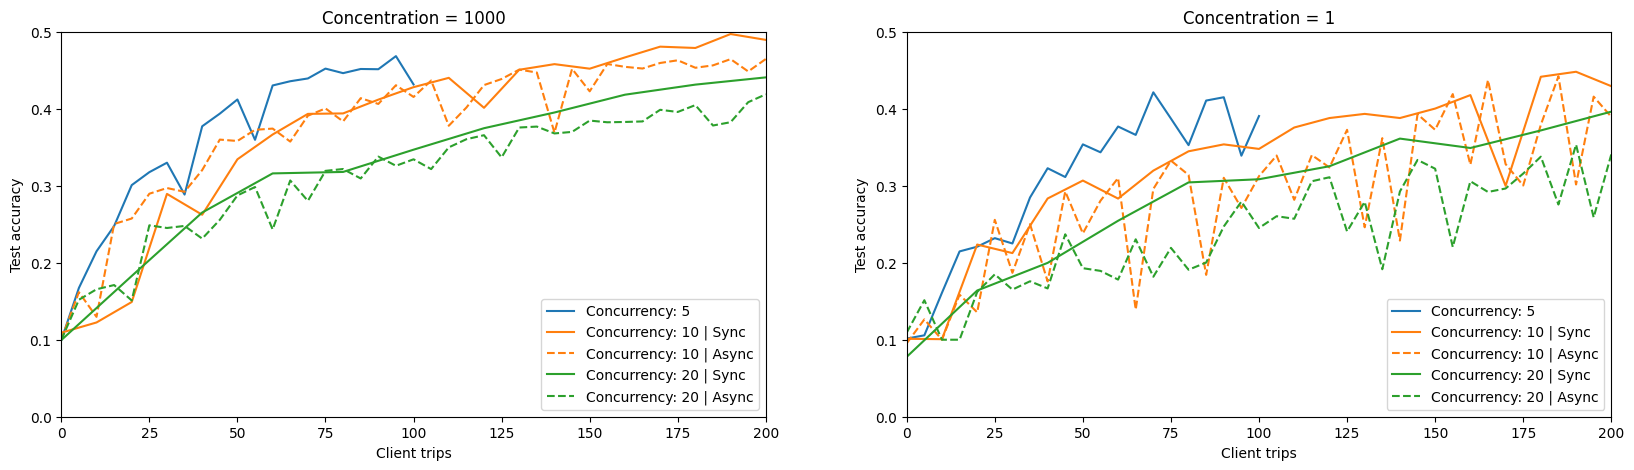

In [9]:
import matplotlib.pyplot as plt

fig,axs =  plt.subplots(1,2,figsize=(20,5))

axs[1].set_title("Concentration = 1")

for concurrency, colour in zip([5,10,20],["tab:blue","tab:orange","tab:green"]):
  if concurrency>5:
    client_trips, accs = get_simulation_data(False,concurrency,1)
    axs[1].plot(client_trips,accs, label=f"Concurrency: {concurrency} | Sync", c=colour)
    client_trips, accs = get_simulation_data(True,concurrency,1)
    axs[1].plot(client_trips,accs, label=f"Concurrency: {concurrency} | Async", c=colour, linestyle="--")
  else:
    client_trips, accs = get_simulation_data(False,concurrency,1)
    axs[1].plot(client_trips,accs, label=f"Concurrency: {concurrency}", c=colour)

# axs[1].set_title("Concentration = 10")

# for concurrency, colour in zip([5,10,20],["tab:blue","tab:orange","tab:green"]):
#   if concurrency>5:
#     client_trips, accs = get_simulation_data(False,concurrency,10)
#     axs[1].plot(client_trips,accs, label=f"Sync. Concurrency: {concurrency}", c=colour)
#     client_trips, accs = get_simulation_data(True,concurrency,10)
#     axs[1].plot(client_trips,accs, label=f"Async. Concurrency: {concurrency}", c=colour, linestyle="--")
#   else:
#     client_trips, accs = get_simulation_data(False,concurrency,10)
#     axs[1].plot(client_trips,accs, label=f"Concurrency: {concurrency}", c=colour)

axs[0].set_title("Concentration = 1000")
for concurrency, colour in zip([5,10,20],["tab:blue","tab:orange","tab:green"]):
  if concurrency>5:
    client_trips, accs = get_simulation_data(False,concurrency,1000)
    axs[0].plot(client_trips,accs, label=f"Concurrency: {concurrency} | Sync", c=colour)
    client_trips, accs = get_simulation_data(True,concurrency,1000)
    axs[0].plot(client_trips,accs, label=f"Concurrency: {concurrency} | Async", c=colour, linestyle="--")
  else:
    client_trips, accs = get_simulation_data(False,concurrency,1000)
    axs[0].plot(client_trips,accs, label=f"Concurrency: {concurrency}", c=colour)

for a in axs:
  a.set_xlabel("Client trips")
  a.set_ylabel("Test accuracy")
  a.legend()
  a.set_ylim(0,0.5)
  a.set_xlim(0,200)
fig.show()